# Import packages

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import auc, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
import pickle
import shap
from sklearn.cluster import KMeans
from pygam import LinearGAM, s
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.ndimage import gaussian_filter1d

C:\Users\msc213\AppData\Local\anaconda3\envs\Gene_prioritization\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Define Functions

In [2]:
def create_XY_train(df, filter=None):
    train_features = [
        "genes_in_locus",
        "credset_size",
        "genes_within_50kb",
        "genes_within_100kb",
        "genes_within_250kb",
        "Highest_PIP",
        "rel_MAGMA_Z",
        "weighted_distance",
        "TSS_distance",
        "VEP_max",
        "CADD_sum",
        "CLPP_GTEX_tissue_weighted_eQTL_sum",
        "RoadmapEpi_sum",
        "HACER_PRO-seq_GRO-seq_sum",
        "Promoter_sum",
        "F5_ep_sum",
        "Jung_HiC_sum",
        "GeneHancer_sum",
        "EpiMap_sum",
        "mean_CLPP_eQTL_eQTLCatalog_max",
        "ABC_CRISPR_sum",
        "ABC_EP_sum",
        "max_CLPP_rQTL_eQTLCatalog_max",
        "Javierre_HiC_sum",
        "HACER_CAGE_max",
        "CLPP_eQTLgen_sum",
        "cicero_sum",
    ]
    if filter != None:
        df = df[df["distance"] <= int(filter)]
    df = df.groupby("filename").apply(create_relative_annotation)
    na_columns = df[train_features].columns[df[train_features].isna().any()].tolist()
    df[na_columns] = df[na_columns].fillna(0)
    train_X = df[train_features]
    train_y = list(df["TP"])
    return train_X, train_y, df


def create_relative_annotation(genes):
    for feature in genes.columns:
        if len(genes) < 1:
            continue
        if "rel_" in feature:
            continue
        if "distance" in feature:
            maxval = max(genes[feature].astype(float))
            minval = min(genes[feature].astype(float))
            if maxval == minval:
                genes["rel_" + feature] = 1
            else:
                genes["rel_" + feature] = maxval - genes[feature]
                genes["rel_" + feature] = genes["rel_" + feature] / float(
                    maxval - minval
                )
        elif any(x in feature for x in ["max", "sum", "PoPS", "MAGMA_Z"]):
            maxval = max(genes[feature].astype(float))
            minval = min(genes[feature].astype(float))
            if maxval == minval and abs(maxval) > 0.0:
                genes["rel_" + feature] = 1
            elif maxval == 0.0:
                genes[f"rel_{feature}"] = 0
            else:
                genes[f"rel_{feature}"] = (genes[feature].astype(float) - minval) / (maxval - minval)
        genes['no_genes'] = len(genes)
    return genes

def create_precision_recalls(df, scorecol, TP_col, locbased=False, threshold=None):
    maxval = max(df[scorecol])
    minval = min(df[scorecol])
    precisions = []
    recalls = [0]
    if not 'uniqTP' in df.columns:
        df['uniqTP'] = df['symbol'] + df['phenotype']
    if locbased == False:
        tdf = df.sort_values(scorecol, ascending= False)
        cumsum = np.cumsum(tdf[TP_col])
        rank = np.arange(len(cumsum)) + 1
        Num = sum(tdf[TP_col])
        precisions = cumsum / rank
        recalls = cumsum / Num
        precisions = list(precisions)
        recalls = list(recalls)
        recalls.insert(0,0)
        precisions.insert(0,precisions[0])

        if threshold != None:
            tdf = df[df[scorecol] >= threshold]
            if len(tdf) == 0:
                thresholded_recall = 0
            else:
                good = sum(tdf[TP_col])
                precision = round(good/len(tdf),5)
                thresholded_recall = round(good/Num, 5)     
            
    else:
        tps = set(df[df[TP_col] == 1]['uniqTP'] )
        for i in np.linspace(maxval +0.01, minval -0.01, 5000):
            tdf = df[df[scorecol] >= i]
            if len(tdf) == 0:
                continue
            good = sum(tdf[TP_col]) 
            precision = round(good/len(tdf), 5)
            recall = round(len(set(tdf[tdf[TP_col] == 1]['uniqTP']))/len(tps), 5)
            if len(precisions) == 0:
                precisions.append(precision)
            if recall == recalls[-1]:
                continue
            precisions.append(precision)
            recalls.append(recall)   
        if threshold != None:
            tdf = df[df[scorecol] >= threshold]
            if len(tdf) == 0:
                thresholded_recall = 0
            else:
                good = sum(tdf[TP_col]) 
                precision = round(good/len(tdf), 5)
                thresholded_recall = round(len(set(tdf[tdf[TP_col] == 1]['uniqTP']))/len(tps), 5)
    if threshold != None:
        return(precisions, recalls, thresholded_recall)
    return(precisions, recalls)

def create_precision_recalls_cS2G(df, scorecol, TP_col):
    maxval = max(df[scorecol])
    minval = min(df[scorecol])
    precisions = []
    recalls = [0]
    tps = df[df[TP_col] == 1]['uniqTP'] 
    for i in np.linspace(maxval +0.01, minval -0.01, 500):
        tdf = df[df[scorecol] >= i]
        if len(tdf) == 0:
            continue
        good = sum(tdf[TP_col]) 
        precision = round(good/len(tdf), 5)
        recall = round(len(tdf[tdf[TP_col] == 1]['uniqTP'])/len(tps), 5)
        if len(precisions) == 0:
            precisions.append(precision)
        if recall == recalls[-1]:
            continue
        precisions.append(precision)
        recalls.append(recall)   
    return(precisions, recalls)    

            
def simulate_random_predictor(value_counts, TPs):
    correct = 0
    for i in value_counts:
        x = random.randint(1, i)
        if x == i:
            correct +=1
    precision = correct/TPs        
    return precision

def bootstrap_df(df, feats, n_samples, binar = False):
    rats = []
    cis = []
    ratios = {k: [] for k in feats}
    for i in range(n_samples):
        sample = df.sample(frac=1, replace=True)
        if len(sample[ sample['TP'] ==1]) ==0:
            continue
        for feature in feats:
            if binar == False:
                sample_tp_1 = sample[sample['TP'] == 1][feature]
                sample_tp_0 = sample[sample['TP'] == 0][feature]
            else:
                sample_tp_1 = sample[sample['TP'] == 1][feature].astype(int)
                sample_tp_0 = sample[sample['TP'] == 0][feature].astype(int) 
            x = ratios[feature]
            x.append(np.mean(list(sample_tp_1)) / np.mean(list(sample_tp_0)))
            ratios[feature] = x
    for feature in feats:      
        lower_ci = np.percentile(ratios[feature], 2.5)
        upper_ci = np.percentile(ratios[feature], 97.5)
        cis.append([lower_ci, upper_ci])
        if binar == False:
            rats.append(np.mean(df[df['TP'] == 1][feature])/np.mean(df[df['TP'] == 0][feature]))
        else:
            rats.append(np.mean(df[df['TP'] == 1][feature].astype(int))/np.mean(df[df['TP'] == 0][feature].astype(int)))
    data = {'Columns': feats, 'Mean': rats, 'CI_lower': [ci[0] for ci in cis], 'CI_upper': [ci[1] for ci in cis]}
    pltdf = pd.DataFrame(data)
    return pltdf

def plot_ratios(pltdf, Bin=False):
    pltdf['type'] = [
        'QTL', 'Pathogenicity prediction', 'Pathogenicity prediction', 'Gene-enhancer links',
        'Gene-enhancer links', 'Chromatin interaction', 'Positional', 'Interaction modeling',
        'QTL', 'QTL', 'Gene-enhancer links', 'QTL', 'Interaction modeling', 'Gene-enhancer links',
        'Chromatin interaction', 'Gene-enhancer links', 'Gene-enhancer links', 'Interaction modeling',
        'Positional', 'Positional', 'Other', 'Other'
    ]

    # Define the order of the types for sorting and their respective colors
    type_order = [
        'Pathogenicity prediction',
        'Gene-enhancer links',
        'Chromatin interaction',
        'Interaction modeling',
        'Positional',
        'QTL',
        'Other',
    ]

    type_colors = {
        'Pathogenicity prediction': '#1f77b4',  # Blue
        'QTL': '#e377c2',  # Pink
        'Chromatin interaction': '#2ca02c',  # Green
        'Gene-enhancer links': '#ff7f0e',  # Orange
        'Interaction modeling': '#d62728',  # Red
        'Positional': '#9467bd',  # Purple
        'Other': '#7f7f7f',  # Grey
    }

    pltdf['meanoftype'] = pltdf.groupby('type')['Mean'].transform('mean')

    # Sort the DataFrame by 'meanoftype' and then by 'Mean' within each type
    pltdf = pltdf.sort_values(by=['meanoftype', 'type', 'Mean'], ascending=[False, False, False])

    # Reset the index
    pltdf = pltdf.reset_index()

    # Set Seaborn style
    plt.figure(figsize=(10, 8))
    ax = sns.stripplot(data=pltdf, x="Mean", y="Columns", size=10, jitter=False, linewidth=1, edgecolor="w", palette=[type_colors[type] for type in pltdf['type']])

    # Set y-axis labels using the full "feats" list
    featnames = [Feature_dict[x].replace(' score', '') for x in pltdf['Columns']]
    ax.set_yticklabels(featnames, fontsize = 13)

    # Set x-axis limits and labels
    ax.set_xlim(0.75, max(pltdf['CI_upper'] + 0.25))  # Set the x-axis limits from 0.75 to 4
    ax.set_xlabel("Highest score ratio", fontsize = 16)
    ax.set_ylabel("")

    # Add a vertical dashed and slightly opaque black line at x=1
    ax.axvline(x=1, color='black', linestyle='dashed', alpha=0.75)

    for i, row in pltdf.iterrows():
        x = row["Mean"]
        ci_lower = row["CI_lower"]
        ci_upper = row["CI_upper"]
        color = type_colors[row["type"]]
        ax.errorbar(x=[x], y=[i], xerr=[[x - ci_lower], [ci_upper - x]], color=color, fmt='o', markersize=0)

    # Set a title for the plot
    ax.set_title('Ratio score in locus being the causal vs non-causal', fontsize = 18)
    if Bin:
        ax.set_title('Ratio highest score in locus causal gene vs non-causal gene', fontsize=16)
    # Create a legend with unique type entries and their corresponding colors
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, label=type, markerfacecolor=color) for type, color in type_colors.items()]
    ax.legend(handles=handles, title="Legend")
    ax.set_xlim(right=6)
    # Remove vertical gridlines
    ax.xaxis.grid(False)

    # Remove left and bottom spines
    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.show()
    
def plot_precision_recall(df, setname):
    #FLAMES predictions
    precision,recall,thresh_rec = create_precision_recalls(df, 'FLAMES_scaled', 'TP', threshold=0.1)
    auprc = auc(recall, precision)

    #XGB predictions
    precisionxgb,recallxgb = create_precision_recalls(df, 'XGB_scaled', 'TP')
    auprcxgb = auc(recallxgb, precisionxgb)

    #cS2G predictions
    precision_cS2G, recall_cS2G = create_precision_recalls_cS2G(df, 'weighted_cS2G_score', 'TP')
    cS2G_auprc = auc(recall_cS2G, precision_cS2G)

    #L2G predictions
    precision_L2G, recall_L2G = create_precision_recalls(df, 'Overall L2G score', 'TP')
    L2G_auprc = auc(recall_L2G, precision_L2G)

    #FLAMES with pathways predictions
    precision2,recall2 = create_precision_recalls(df, 'FLAMES_scaled_with_path', 'TP')
    auprc2 = auc(recall2, precision2)

    #PoPS predictions
    pops_predict = df[df['rel_PoPS_Score'] ==1]
    pops_p = sum(pops_predict['TP'])/len(df.groupby('filename').filter(lambda group: group['rel_PoPS_Score'].sum() != 0)['filename'].unique())
    pops_r = sum(pops_predict['TP'])/ sum(df['TP'])

    #PoPS with pathway predictions
    pops_predict = df[df['rel_PoPS_path'] ==1]
    pops_path_p = sum(pops_predict['TP'])/len(df.groupby('filename').filter(lambda group: group['rel_PoPS_Score'].sum() != 0)['filename'].unique())
    pops_path_r = sum(pops_predict['TP'])/ sum(df['TP'])

    # Magma predictions
    magma_predict = df[df['rel_MAGMA_Z'] ==1]
    mgm_p = sum(magma_predict['TP'])/len(df.groupby('filename').filter(lambda group: group['rel_MAGMA_Z'].sum() != 0)['filename'].unique())
    mgm_r = sum(magma_predict['TP'])/ sum(df['TP'])

    #Closest gene predictions
    max_distance = df.groupby('filename')['rel_weighted_distance'].transform('max')
    closest_predict = df[df['rel_weighted_distance'] == max_distance]
    cg_p = sum(closest_predict['TP'])/len(closest_predict)
    cg_r = sum(closest_predict['TP'])/ sum(df['TP'])

    #FLAMES predictions & Closest +  PoPS
    clos_pops = sum(df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int)*df['TP'].astype(int))/ sum(df['TP'])
    if sum(df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int)) >0:
        clos_pops_p = sum(df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int)*df['TP'].astype(int))/sum(df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int))
    else:
        clos_pops_p = 0

    clos_pops_path = sum(df['rel_PoPS_path'].astype(int)*df['rel_weighted_distance'].astype(int)*df['TP'].astype(int))/ sum(df['TP'])
    if sum(df['rel_PoPS_path'].astype(int)*df['rel_weighted_distance'].astype(int)) >0:
        clos_pops_path_p = sum(df['rel_PoPS_path'].astype(int)*df['rel_weighted_distance'].astype(int)*df['TP'].astype(int))/sum(df['rel_PoPS_path'].astype(int)*df['rel_weighted_distance'].astype(int))
    else:
        clos_pops_path_p = 0

    pops_predict = df[df['FLAMES_causal'] ==1]
    FLAMES_p = sum(pops_predict['TP'])/len(set(df['filename']))
    FLAMES_r = sum(pops_predict['TP'])/ sum(df['TP'])
    pops_predict = df[df['FLAMES_causal_path'] ==1]
    FLAMESpath_p = sum(pops_predict['TP'])/len(set(df['filename']))
    FLAMESpath_r = sum(pops_predict['TP'])/ sum(df['TP'])

    #best L2G
    predictions = df[df['L2G_best'] ==1]
    L2G_p = sum(predictions['TP'])/len(set(df['filename']))
    L2G_r = sum(predictions['TP'])/ sum(df['TP'])


    #FLAMES_recommended
    thresh = 0.248
    fdf = df[df['FLAMES_raw_path'] > 0.136]
    rec_p = sum(fdf[fdf['FLAMES_scaled_with_path'] > thresh]['TP'] * fdf[fdf['FLAMES_scaled_with_path'] > thresh]['FLAMES_causal_path']) / sum(fdf[fdf['FLAMES_scaled_with_path']> thresh]['FLAMES_causal_path'])
    rec_r = sum(fdf[fdf['FLAMES_scaled_with_path'] > thresh]['TP'] * fdf[fdf['FLAMES_scaled_with_path'] > thresh]['FLAMES_causal_path']) / sum( df['TP'])



    #Random predictor
    value_counts = df.groupby(['locusname', 'phenotype']).size().reset_index(name='count')
    value_counts['random'] = 1/value_counts['count']
    random_precision = sum(value_counts['random'])/sum(df['TP'])

    # Create the PRC plot
    plt.figure(figsize=(10, 8))
    plt.step(recall2, precision2, color='g', alpha=1, where='pre', label = f'FLAMES ({auprc2.round(2)})')
    plt.step(recall, precision, color='r', alpha=1, where='pre', label = f'FLAMES \npath. naive ({auprc.round(2)})')
    plt.step(recallxgb, precisionxgb, color='m', alpha=1, where='pre', label = f'XGB ({auprcxgb.round(2)})')
    plt.step(recall_L2G, precision_L2G, color='b', alpha=1, where='pre', label = f'L2G ({L2G_auprc.round(2)})')
    plt.step(recall_cS2G, precision_cS2G, color='y', alpha=1, where='pre', label = f'cS2G ({cS2G_auprc.round(2)})')


    plt.plot(rec_r, rec_p, 'gD', markersize=9, label = 'FLAMES recommended', markeredgecolor ='black', markerfacecolor='orange')
    plt.plot(FLAMESpath_r, FLAMESpath_p, 'gD', markersize=9, label = 'Highest FLAMES', markeredgecolor ='black')
    plt.plot(FLAMES_r, FLAMES_p, 'rD', markersize=9, label = 'Highest FLAMES \npath. naive', markeredgecolor ='black')
    plt.plot(L2G_r, L2G_p, 'bo', label = 'Highest L2G', markeredgecolor ='black') 
    plt.plot(pops_path_r, pops_path_p, 'w^', markersize=9, label = 'Highest PoPS', markeredgecolor ='black')
    plt.plot(clos_pops_path, clos_pops_path_p, 'w^', markersize = 9, label = 'Closest+PoPS', markeredgecolor ='black', markerfacecolor='grey')
    plt.plot(pops_r, pops_p, 'ws', markersize=8, label = 'Highest PoPS\npath naive', markeredgecolor ='black')
    plt.plot(clos_pops, clos_pops_p, 'ws', markersize=8, label = 'Closest+PoPS \npath. naive', markeredgecolor ='black', markerfacecolor='grey')
    plt.plot(cg_r, cg_p, 'kX', markersize=9, label = 'Closest gene', markeredgecolor ='black')
    plt.plot(mgm_r, mgm_p, 'cp', markersize=9, label = 'Highest MAGMA-Z', markeredgecolor ='black')
    plt.plot(random_precision, random_precision, 'kx', label = 'Random predictor', markeredgecolor ='black') 


    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title(f'Precision-Recall Curve {setname} set', fontsize=18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Method (AUPRC):')
    plt.legend(frameon=False, fontsize = 15)
    plt.legend(loc="lower left", ncol=4, bbox_to_anchor=(0.05, -0.3))
    plt.xticks(np.arange(0.1, 1.001 , 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    plt.savefig(os.path.join('benchmarking_results', '_'.join(setname.split(' ')) + '.svg'), format='svg')
    plt.show()

    plt.clf()
    # Create the PRC plot
    plt.figure(figsize=(10, 8))
    plt.step(recall2, precision2, color='g', alpha=1, where='pre', label = f'FLAMES ({auprc2.round(2)})')
    plt.step(recallxgb, precisionxgb, color='m', alpha=1, where='pre', label = f'XGB ({auprcxgb.round(2)})')
    plt.step(recall_L2G, precision_L2G, color='b', alpha=1, where='pre', label = f'L2G ({L2G_auprc.round(2)})')
    plt.step(recall_cS2G, precision_cS2G, color='y', alpha=1, where='pre', label = f'cS2G ({cS2G_auprc.round(2)})')


    plt.plot(rec_r, rec_p, 'gD', markersize=9, label = 'FLAMES recommended', markeredgecolor ='black', markerfacecolor='orange')
    plt.plot(FLAMESpath_r, FLAMESpath_p, 'gD', markersize=9, label = 'Highest FLAMES', markeredgecolor ='black')
    plt.plot(L2G_r, L2G_p, 'bo', label = 'Highest L2G', markeredgecolor ='black') 
    plt.plot(pops_path_r, pops_path_p, 'w^', markersize=9, label = 'Highest PoPS', markeredgecolor ='black')
    plt.plot(clos_pops_path, clos_pops_path_p, 'w^', markersize = 9, label = 'Closest+PoPS', markeredgecolor ='black', markerfacecolor='grey')
    plt.plot(cg_r, cg_p, 'kX', markersize=9, label = 'Closest gene', markeredgecolor ='black')
    plt.plot(mgm_r, mgm_p, 'cp', markersize=9, label = 'Highest MAGMA-Z', markeredgecolor ='black')
    plt.plot(random_precision, random_precision, 'kx', label = 'Random predictor', markeredgecolor ='black') 


    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title(f'Precision-Recall Curve {setname} set', fontsize=18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Method (AUPRC):')
    plt.legend(frameon=False, fontsize = 15)
    plt.legend(loc="lower left", ncol=4, bbox_to_anchor=(0.05, -0.3))
    plt.xticks(np.arange(0.1, 1.001 , 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    plt.savefig(os.path.join('benchmarking_results', '_'.join(setname.split(' ')) + '_all.svg'), format='svg')
    plt.show()
    return

# Set path to FLAMES_supplemental_data

In [3]:
basedir = os.getcwd()

# Create plots of expert curated & FLAMES distributions of annotations

In [4]:
# create a dict for full annotation names in plot
Feature_dict ={'rel_CLPP_GTEX_tissue_weighted_eQTL_sum': "Summed tissue weighted GTEx eQTL scores",'rel_VEP_max':'Maximum VEP score', 'rel_CADD_sum': 'Summed CADD score',
              'rel_HACER_PRO-seq_GRO-seq_sum':'Summed HACER PRO/GRO-seq score', 'rel_RoadmapEpi_sum':'Summed Roadmap Epigenetics score', 'rel_Jung_HiC_sum':'summed Jung HiC score', 'rel_Promoter_sum':'sum of PIPs of variants in promoter', 'rel_ABC_EP_sum':'summed Enhancer-Promoter Activity-by-contact scores', 'rel_mean_CLPP_eQTL_eQTLCatalog_max':'maximum score of tissue averaged eQTL-catalog eQTLs', 'rel_max_CLPP_rQTL_eQTLCatalog_max':'maximum score of higest eQTL-catalog rQTL in any tissue',
              'rel_GeneHancer_sum':'summed GeneHancer score','rel_CLPP_eQTLgen_sum':'summed eQTLgen eQTL score',
               'rel_ABC_CRISPR_sum':'summed CRISPR Activity-by-contact score','rel_HACER_CAGE_max':'maximum HACER CAGE score','rel_Javierre_HiC_sum':'summed Javierre HiC score','rel_F5_ep_sum':'summed FANTHOM5 enhancer-promoter correlation score',
               'rel_EpiMap_sum':'summed EpiMap score','rel_cicero_sum':'summed whole-blood CICERO score','rel_weighted_distance':'distance to gene from centroid of credible set',
               'rel_weighted_TSS_distance':'distance to gene TSS from centroid of credible set','rel_MAGMA_Z':'MAGMA Z','rel_PoPS_Score':'PoPS score', 'rel_sum':'summed functional annotations', 'weighted_distance':'distance to gene from centroid of credible set'}


rel_CLPP_GTEX_tissue_weighted_eQTL_sum


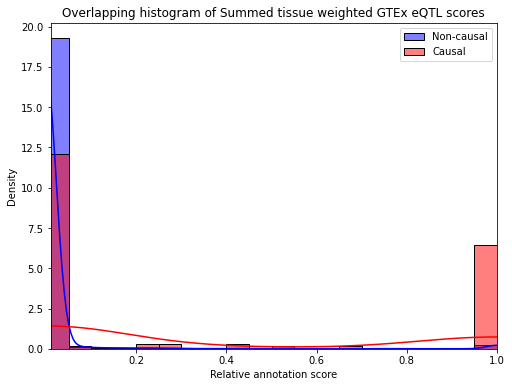

rel_VEP_max


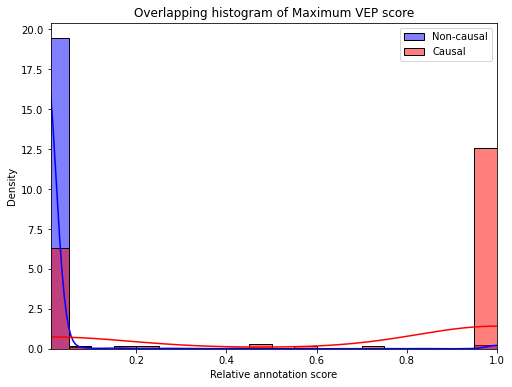

rel_CADD_sum


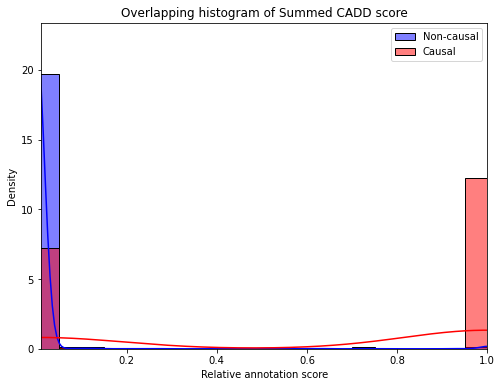

rel_HACER_PRO-seq_GRO-seq_sum


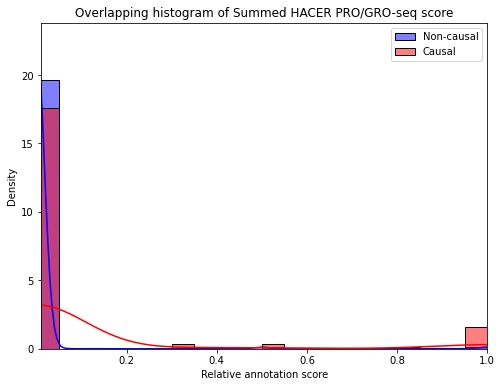

rel_RoadmapEpi_sum


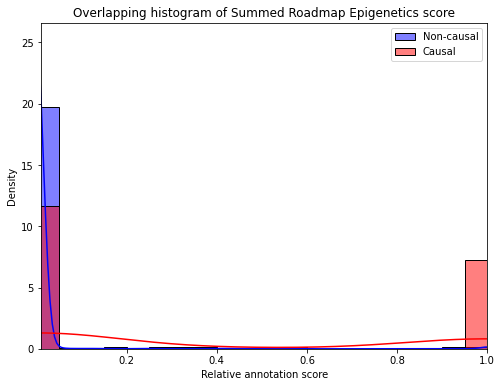

rel_Jung_HiC_sum


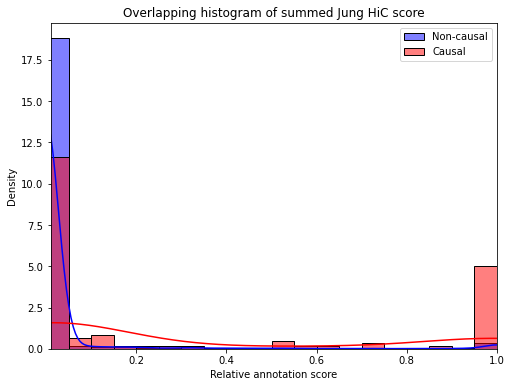

rel_Promoter_sum


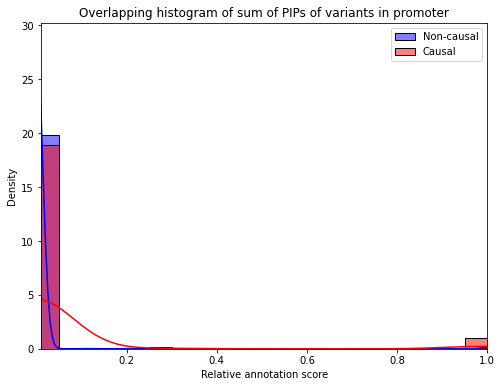

rel_ABC_EP_sum


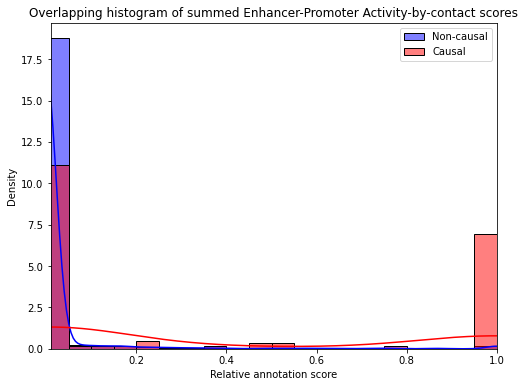

rel_mean_CLPP_eQTL_eQTLCatalog_max


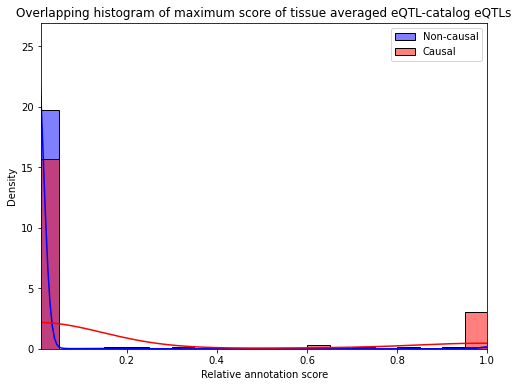

rel_max_CLPP_rQTL_eQTLCatalog_max


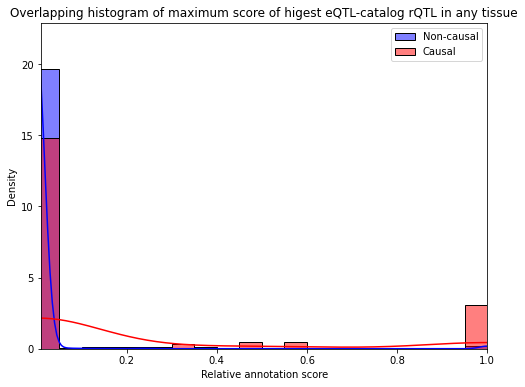

rel_GeneHancer_sum


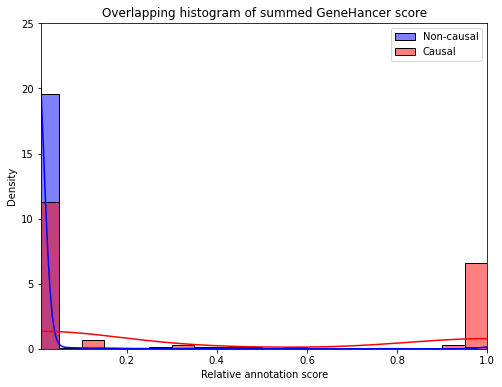

rel_CLPP_eQTLgen_sum


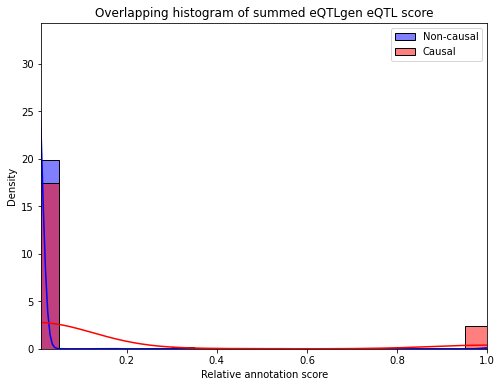

rel_ABC_CRISPR_sum


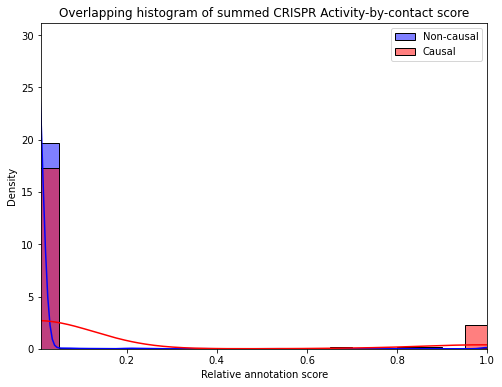

rel_HACER_CAGE_max


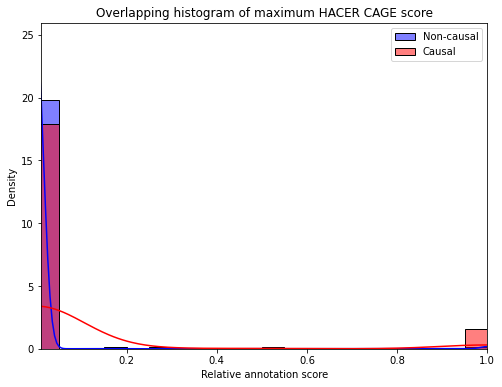

rel_Javierre_HiC_sum


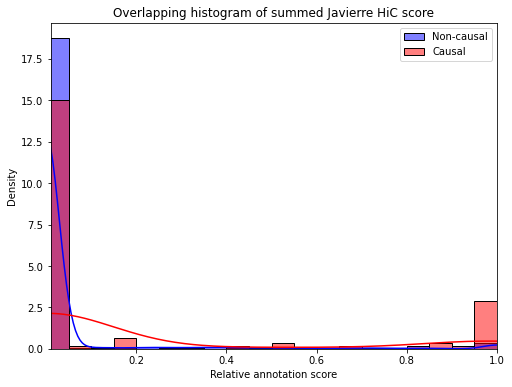

rel_F5_ep_sum


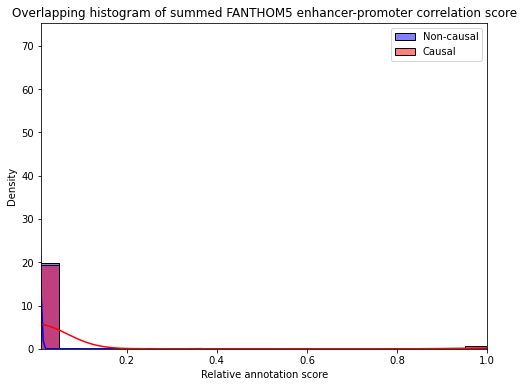

rel_EpiMap_sum


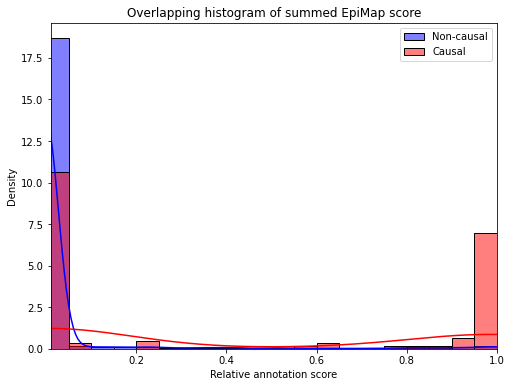

rel_cicero_sum


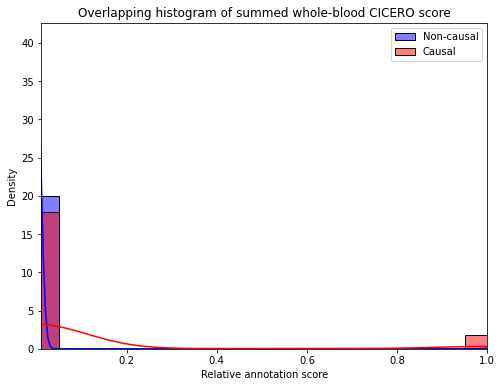

rel_weighted_distance


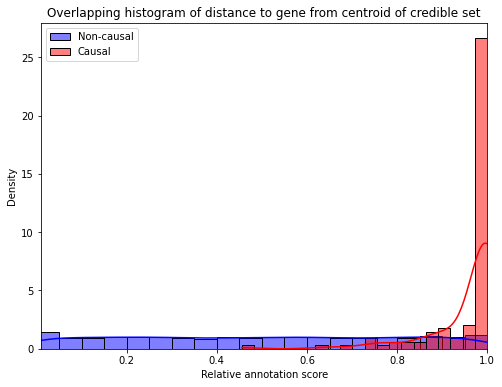

rel_weighted_TSS_distance


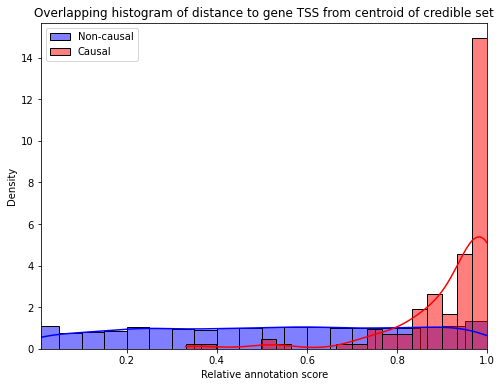

rel_MAGMA_Z


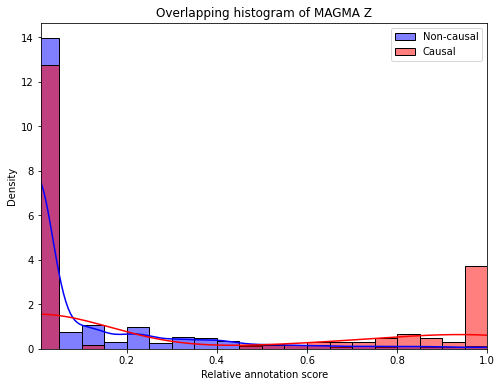

rel_PoPS_Score


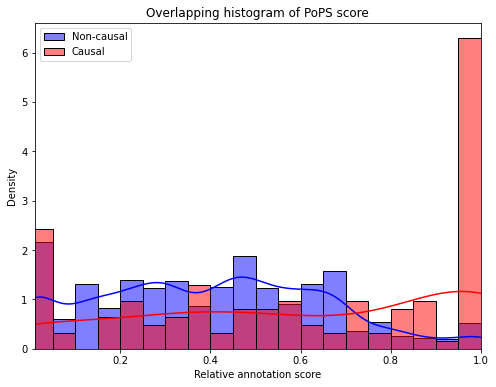

rel_sum


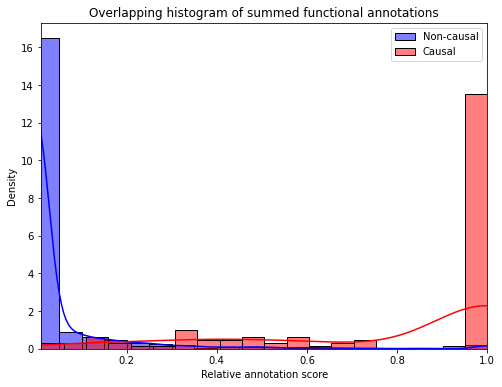

In [5]:
# L2G data
# set data path
data = os.path.join(basedir,'annotated_loci','all_L2G.csv')
df = pd.read_csv(data)

# drop duplicate rows
df = df.drop(df.columns[0], axis=1)
df = df.drop_duplicates()

# Select variables with 'rel' in their names
selected_features = [x for x in df.columns if 'rel' in x and not 'PoPS' in x and not 'dist' in x and not 'MAGMA' in x]
rel_vars = df[selected_features].copy()
rel_vars['sum'] = rel_vars.sum(axis=1)

# create a summed annotation scores
df['sum'] = rel_vars['sum']

#recreate loci as used in training of FLAMES
train_X, train_y, df = create_XY_train(df, 750000)

#create a plot per annotation
for feature in ['rel_CLPP_GTEX_tissue_weighted_eQTL_sum', 'rel_VEP_max', 'rel_CADD_sum', 'rel_HACER_PRO-seq_GRO-seq_sum','rel_RoadmapEpi_sum','rel_Jung_HiC_sum','rel_Promoter_sum','rel_ABC_EP_sum','rel_mean_CLPP_eQTL_eQTLCatalog_max','rel_max_CLPP_rQTL_eQTLCatalog_max','rel_GeneHancer_sum','rel_CLPP_eQTLgen_sum','rel_ABC_CRISPR_sum','rel_HACER_CAGE_max','rel_Javierre_HiC_sum','rel_F5_ep_sum','rel_EpiMap_sum','rel_cicero_sum','rel_weighted_distance','rel_weighted_TSS_distance', 'rel_MAGMA_Z', 'rel_PoPS_Score', 'rel_sum']:  # Exclude the last column (TP)
    print(feature)
    plt.figure(figsize=(8, 6))
    sns.histplot(df[df['TP'] == 0][feature], bins=20, color='blue', label='Non-causal', kde=True, stat='density')
    sns.histplot(df[df['TP'] == 1][feature], bins=20, color='red', label='Causal', kde=True, stat='density')
    plt.xlabel('Relative annotation score')
    plt.ylabel('Density')
    plt.title(f'Overlapping histogram of {Feature_dict[feature]}')
    plt.legend()
    plt.xlim(0.01, 1)  # Set the x-axis limit to exclude the 0 bin
    plt.show()

rel_CLPP_GTEX_tissue_weighted_eQTL_sum


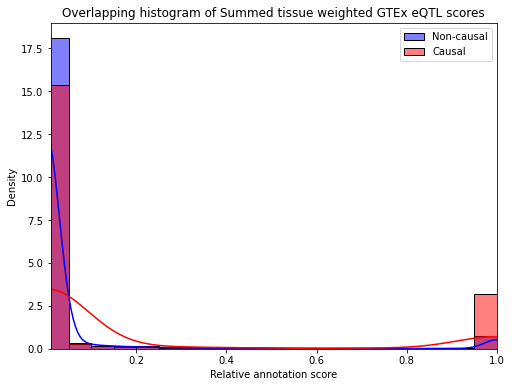

rel_VEP_max


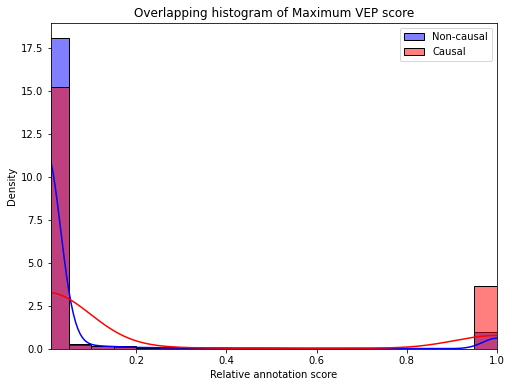

rel_CADD_sum


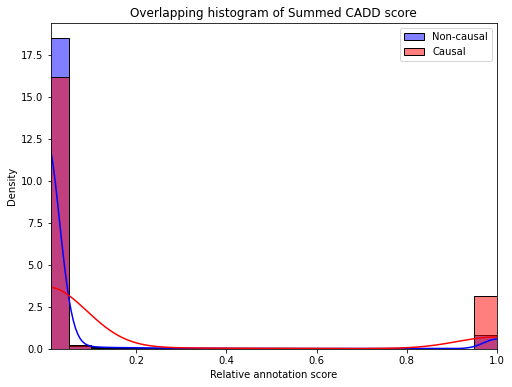

rel_HACER_PRO-seq_GRO-seq_sum


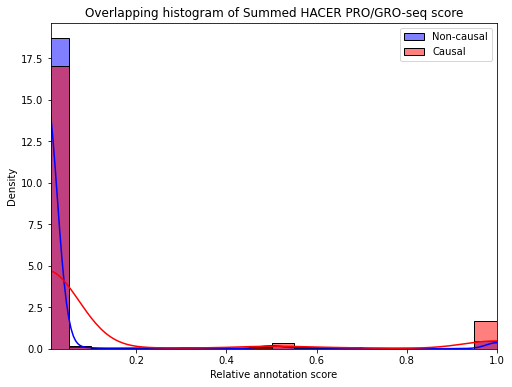

rel_RoadmapEpi_sum


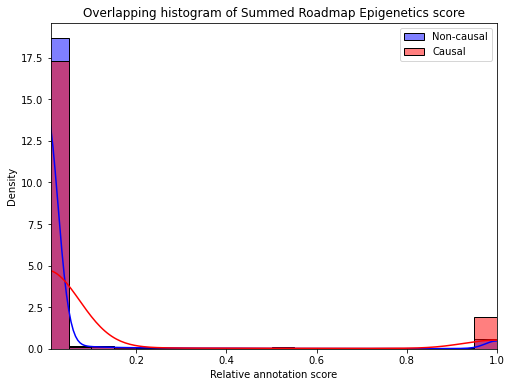

rel_Jung_HiC_sum


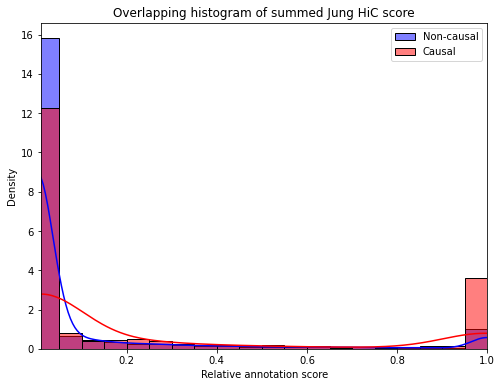

rel_Promoter_sum


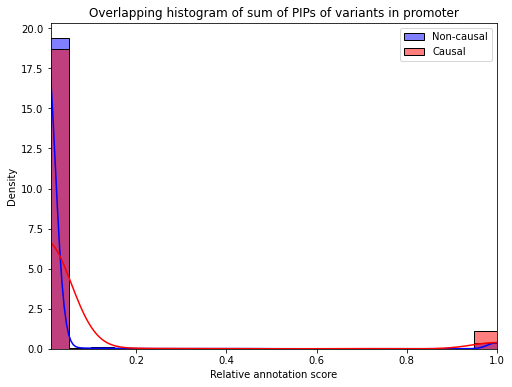

rel_ABC_EP_sum


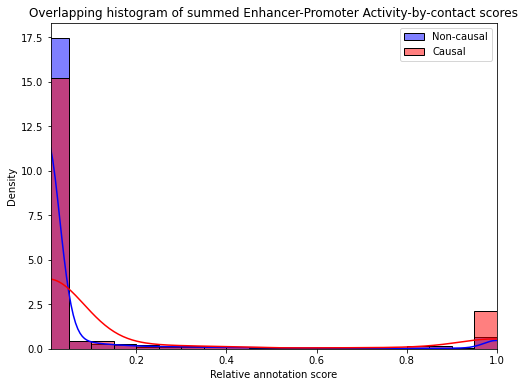

rel_mean_CLPP_eQTL_eQTLCatalog_max


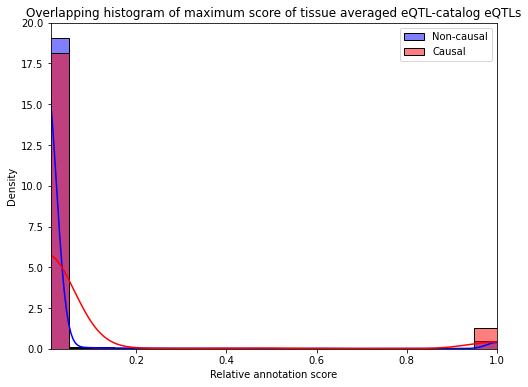

rel_max_CLPP_rQTL_eQTLCatalog_max


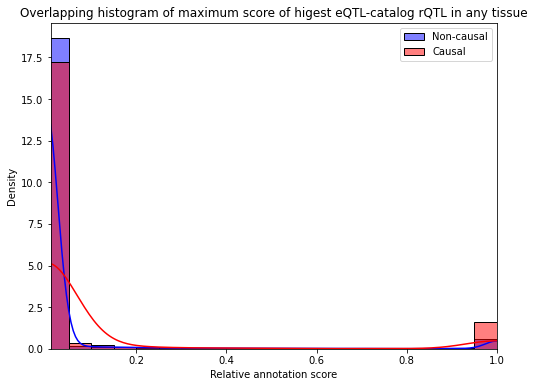

rel_GeneHancer_sum


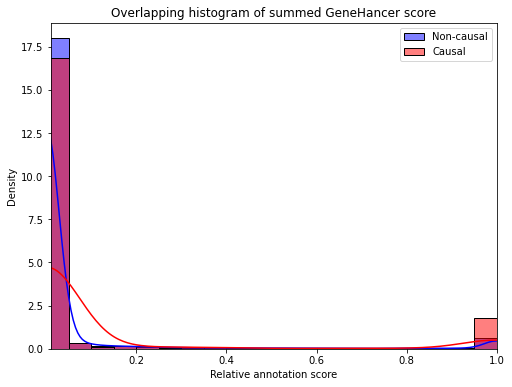

rel_CLPP_eQTLgen_sum


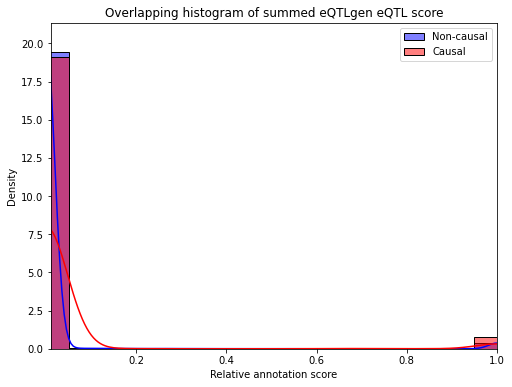

rel_ABC_CRISPR_sum


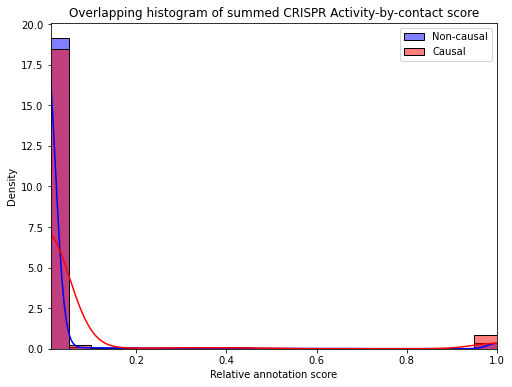

rel_HACER_CAGE_max


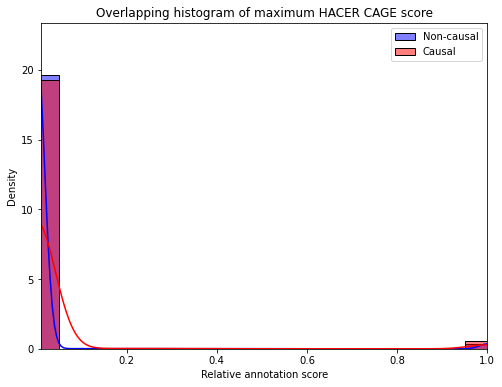

rel_Javierre_HiC_sum


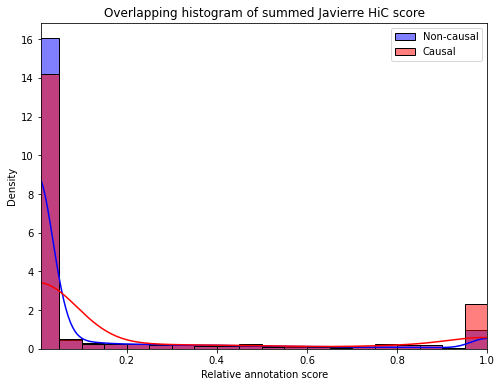

rel_F5_ep_sum


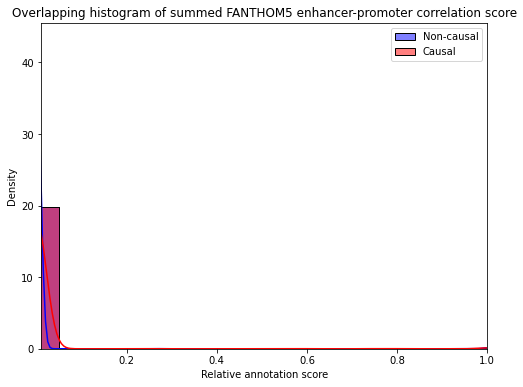

rel_EpiMap_sum


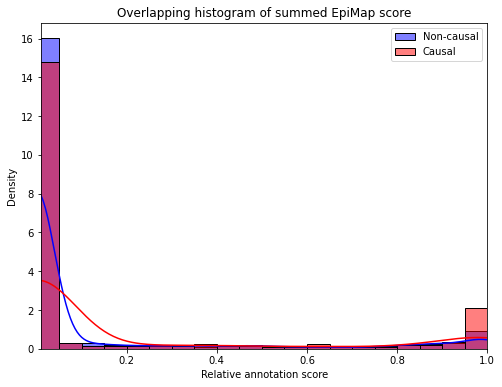

rel_cicero_sum


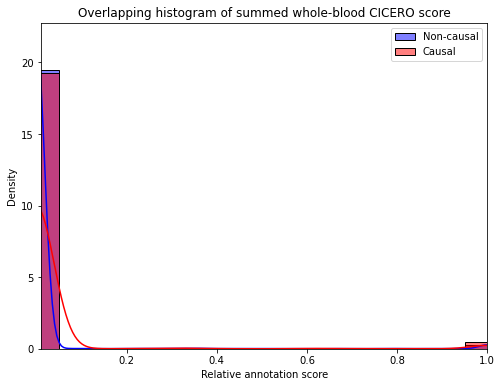

rel_weighted_distance


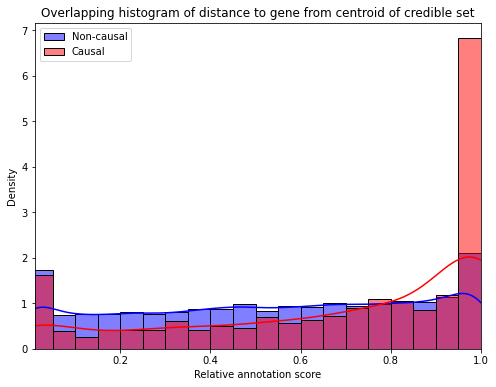

rel_weighted_TSS_distance


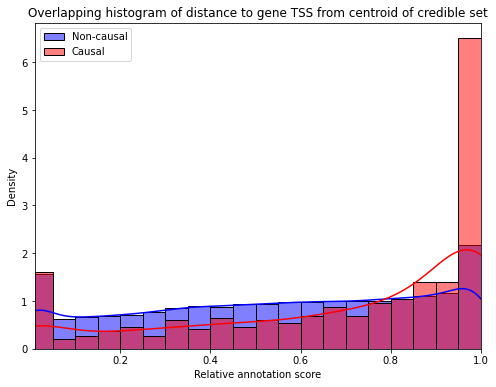

rel_MAGMA_Z


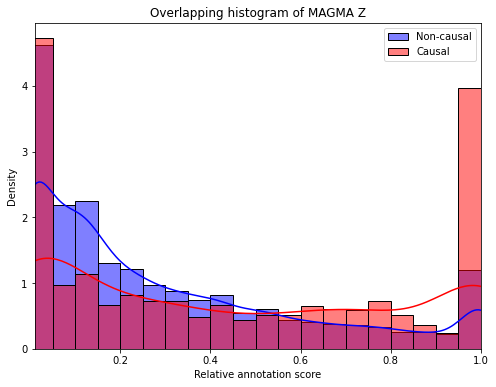

rel_PoPS_Score


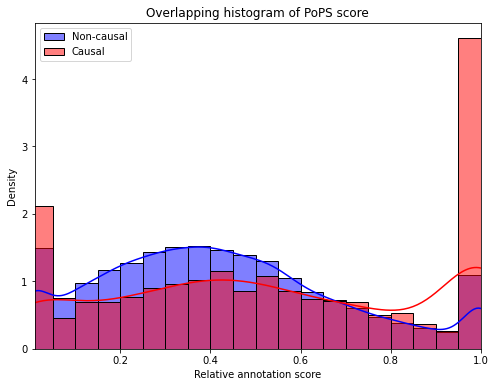

rel_sum


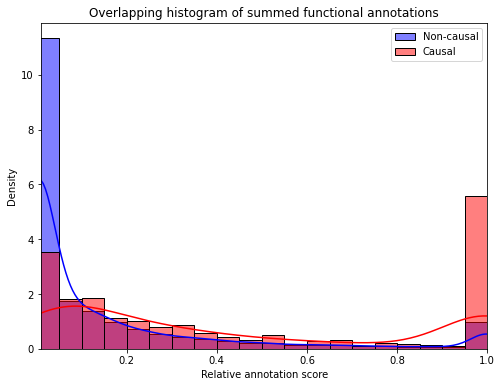

In [6]:
# FLAMES data
# set data path
data = data = os.path.join(basedir,'annotated_loci','all_FLAMES.csv')
df = pd.read_csv(data)

# drop duplicate rows
df = df.drop(df.columns[0], axis=1)
df = df.drop_duplicates()

# Select variables with 'rel' in their names
selected_features = [x for x in df.columns if 'rel' in x and not 'PoPS' in x and not 'dist' in x and not 'MAGMA' in x]
rel_vars = df[selected_features].copy()
rel_vars['sum'] = rel_vars.sum(axis=1)

# create a summed annotation scores
df['sum'] = rel_vars['sum']

#recreate loci as used in training of FLAMES
train_X, train_y, df = create_XY_train(df, 750000)

#create a plot per annotation
for feature in ['rel_CLPP_GTEX_tissue_weighted_eQTL_sum', 'rel_VEP_max', 'rel_CADD_sum', 'rel_HACER_PRO-seq_GRO-seq_sum','rel_RoadmapEpi_sum','rel_Jung_HiC_sum','rel_Promoter_sum','rel_ABC_EP_sum','rel_mean_CLPP_eQTL_eQTLCatalog_max','rel_max_CLPP_rQTL_eQTLCatalog_max','rel_GeneHancer_sum','rel_CLPP_eQTLgen_sum','rel_ABC_CRISPR_sum','rel_HACER_CAGE_max','rel_Javierre_HiC_sum','rel_F5_ep_sum','rel_EpiMap_sum','rel_cicero_sum','rel_weighted_distance','rel_weighted_TSS_distance', 'rel_MAGMA_Z', 'rel_PoPS_Score', 'rel_sum']:  # Exclude the last column (TP)
    print(feature)
    plt.figure(figsize=(8, 6))
    sns.histplot(df[df['TP'] == 0][feature], bins=20, color='blue', label='Non-causal', kde=True, stat='density')
    sns.histplot(df[df['TP'] == 1][feature], bins=20, color='red', label='Causal', kde=True, stat='density')
    plt.xlabel('Relative annotation score')
    plt.ylabel('Density')
    plt.title(f'Overlapping histogram of {Feature_dict[feature]}')
    plt.legend()
    plt.xlim(0.01, 1)  # Set the x-axis limit to exclude the 0 bin
    plt.show()

In [ ]:
# create a dict for full annotation names in plot
Feature_dict ={'rel_CLPP_GTEX_tissue_weighted_eQTL_sum': "Summed GTEx",'rel_VEP_max':'Maximum VEP', 
               'rel_CADD_sum': 'Summed CADD','rel_HACER_PRO-seq_GRO-seq_sum':'Summed HACER PRO/GRO-seq', 
               'rel_RoadmapEpi_sum':'Summed Roadmap Epigenetics', 'rel_Jung_HiC_sum':'summed Jung HiC', 
               'rel_Promoter_sum':'Summed Promoter', 'rel_ABC_EP_sum':'Summed EP ABC', 
               'rel_mean_CLPP_eQTL_eQTLCatalog_max':'Maximum eQTL Catalog eQTL', 
               'rel_max_CLPP_rQTL_eQTLCatalog_max':'Maximum eQTL Catalog rQTL',
               'rel_GeneHancer_sum':'Summed GeneHancer','rel_CLPP_eQTLgen_sum':'Summed eQTLgen',
               'rel_ABC_CRISPR_sum':'Summed CRISPR ABC','rel_HACER_CAGE_max':'Maximum HACER CAGE',
               'rel_Javierre_HiC_sum':'Summed Javierre HiC','rel_F5_ep_sum':'Summed FANTHOM5 EP',
               'rel_EpiMap_sum':'Summed EpiMap','rel_cicero_sum':'Summed CICERO',
               'rel_weighted_distance':'Dist. to gene from credset',
               'rel_weighted_TSS_distance':'Dist. to gene TSS from credset',
               'rel_MAGMA_Z':'MAGMA Z','rel_PoPS_Score':'PoPS', 'rel_sum':'summed functional annotations', 
               'weighted_distance':'distance to gene from centroid of credible set'}


In [9]:
# This takes a few minutes
feats = feats = [x for x in Feature_dict.keys() if  not 'rel_sum' in x and 'rel' in x]
plt_binFLAMES = bootstrap_df(df,feats, 1000, binar=True)


Passing `palette` without assigning `hue` is deprecated.
FixedFormatter should only be used together with FixedLocator


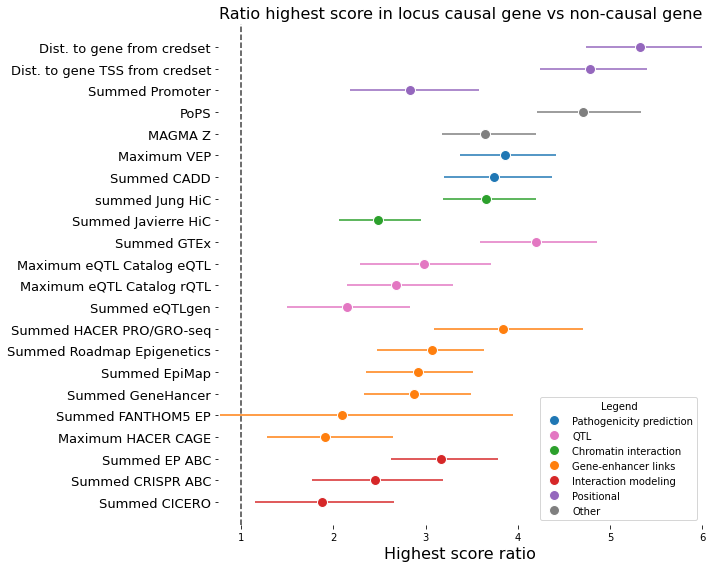

In [13]:
plot_ratios(plt_binFLAMES, Bin=True)

# Create plots of benchmarks

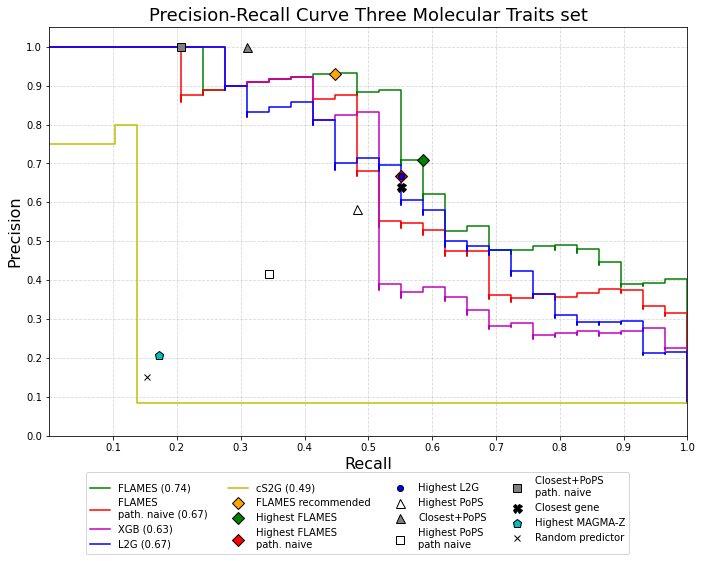

<Figure size 432x288 with 0 Axes>

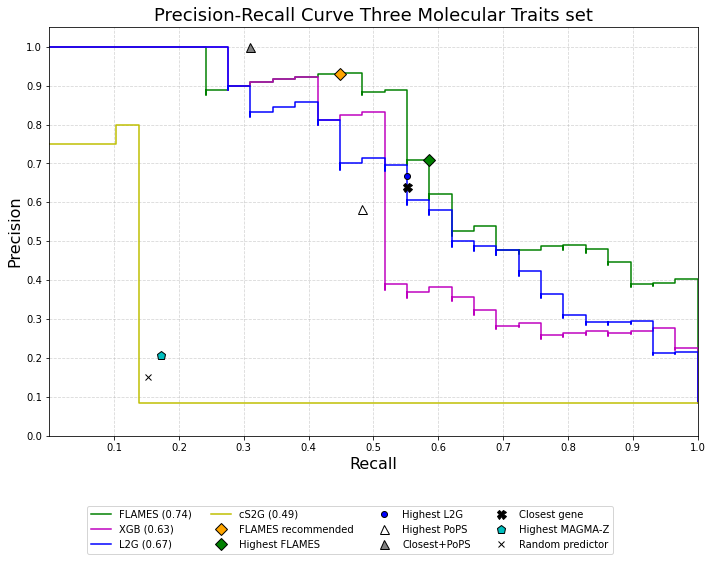

In [4]:
# 3 molecular traits benchmark
df = pd.read_csv(os.path.join('benchmarking_results', '3_mol_traits', 'results_3MT.tsv'), sep='\t')
df['locusname'] = df['filename']
plot_precision_recall(df, 'Three Molecular Traits')

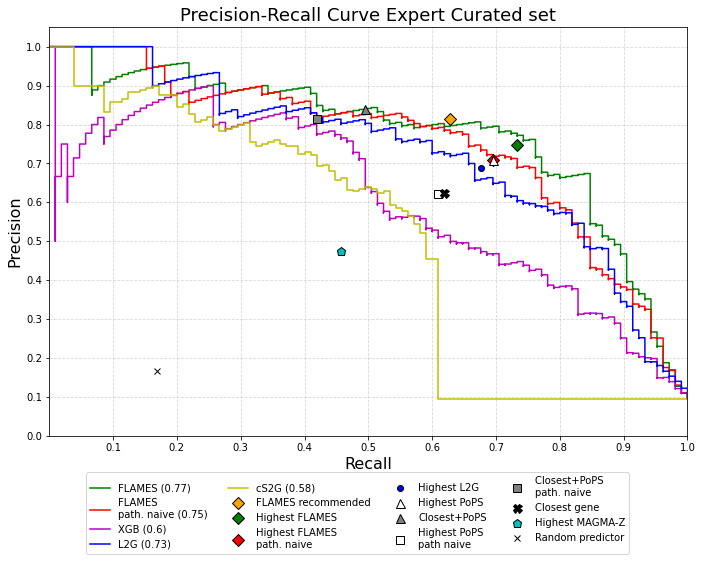

<Figure size 432x288 with 0 Axes>

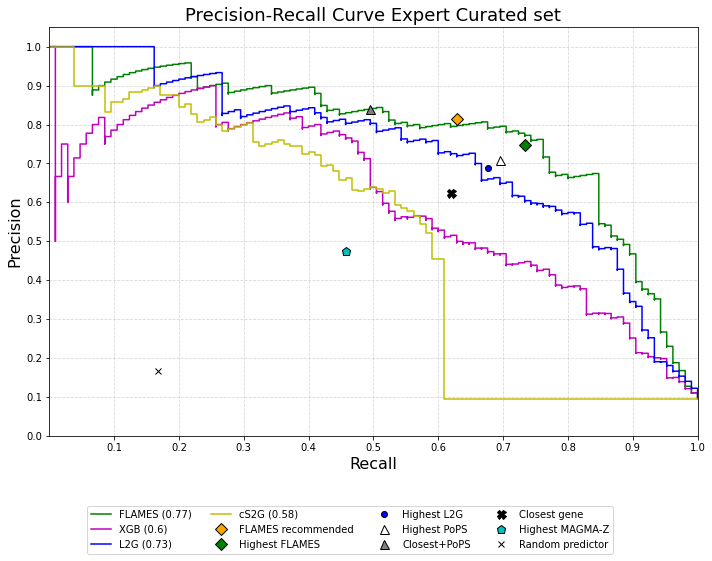

In [11]:
# L2G benchmark
df = pd.read_csv(os.path.join('benchmarking_results', 'L2G', 'results_L2G.tsv'), sep='\t')
df['locusname'] = df['filename']
keeps = set(df[df['TP'] == 1]['locusname'])
df = df[df['locusname'].isin(keeps)]
plot_precision_recall(df, 'Expert Curated')

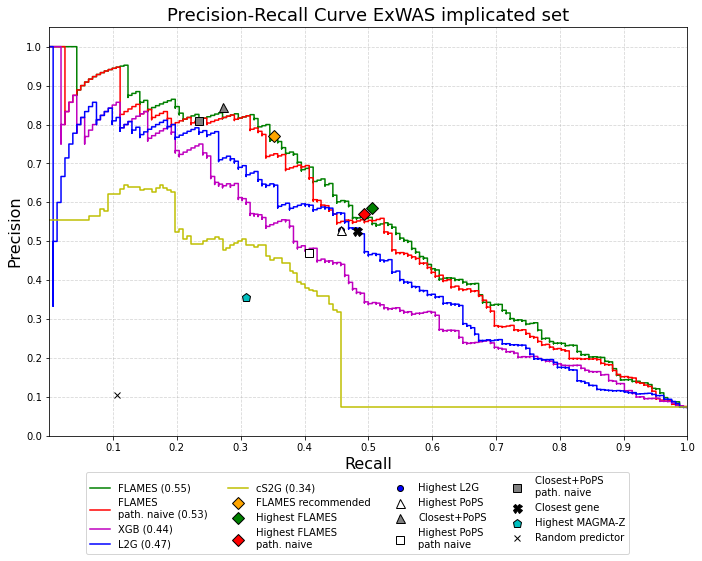

<Figure size 432x288 with 0 Axes>

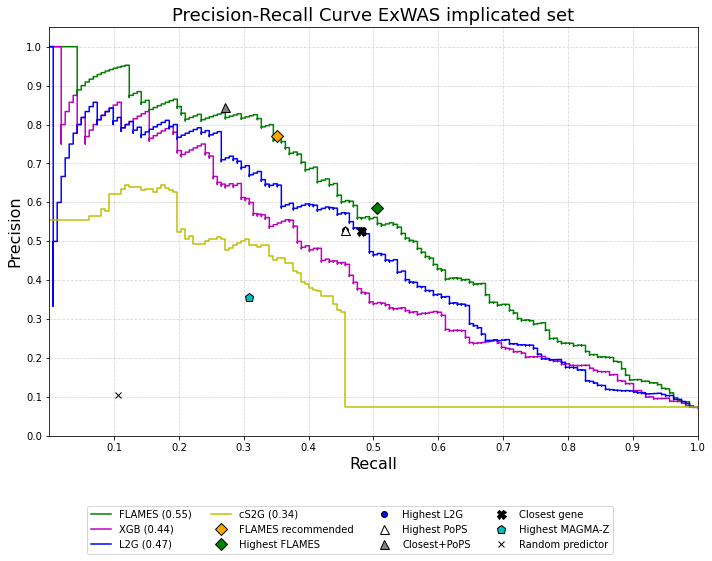

In [12]:
# ExWAS implicated benchmark
df = pd.read_csv(os.path.join('benchmarking_results', '9_pheno', 'results_9_pheno.tsv'), sep='\t')
df['locusname'] = df['filename']
plot_precision_recall(df, 'ExWAS implicated')

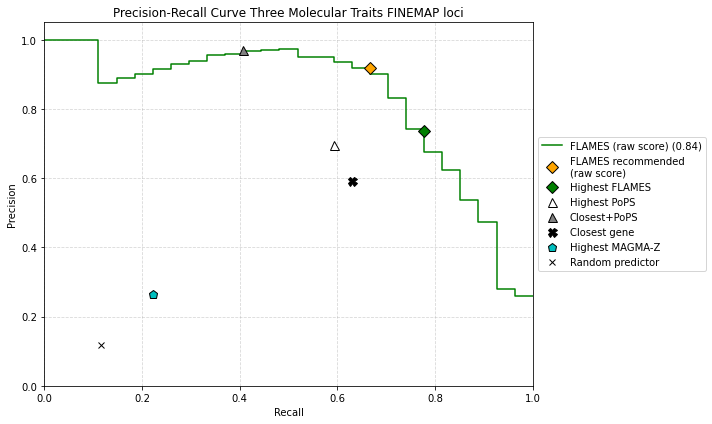

In [6]:
df = pd.read_csv(os.path.join('annotated_loci', '3MT_finemap.csv'))
                 
#PoPS predictions
pops_predict = df[df['rel_PoPS_Score'] ==1]
pops_p = sum(pops_predict['TP'])/len(set(df['filename']))
pops_r = len(set(pops_predict[pops_predict['TP'] == 1 ]['uniqTP']))/ len(set(df[df['TP'] == 1]['uniqTP']))

#Magma predictions
magma_predict = df[df['rel_MAGMA_Z'] ==1]
mgm_p = sum(magma_predict['TP'])/sum(df['rel_MAGMA_Z'].astype(int))
mgm_r = len(set(magma_predict[magma_predict['TP'] == 1]['uniqTP']))/ len(set(df[df['TP'] ==1]['uniqTP']))

#Closest gene predictions
closest_predict = df[df['rel_weighted_distance'] ==1]
cg_p = sum(closest_predict['TP'])/sum(df['rel_weighted_distance'].astype(int))
cg_r = len(set(closest_predict[closest_predict['TP'] == 1]['uniqTP']))/ len(set(df[df['TP'] ==1]['uniqTP']))

#Random predictor
value_counts = df.groupby(['filename', 'phenotype']).size().reset_index(name='count')
value_counts['random'] = 1/value_counts['count']
random_precision = sum(value_counts['random'])/sum(df['TP'])

#FLAMES predictions
precision,recall = create_precision_recalls(df, 'FLAMES_raw', 'TP', True)
auprc = auc(recall, precision)

#FLAMES predictions & Closest +  PoPS
clos_pops = len(set(df[df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int)*df['TP'].astype(int)==1]['uniqTP']))/ len(set(df[df['TP'] == 1]['uniqTP']))
if sum(df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int)) >0:
    clos_pops_p = sum(df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int)*df['TP'].astype(int))/sum(df['rel_PoPS_Score'].astype(int)*df['rel_weighted_distance'].astype(int))
else:
    clos_pops_p = 0  

pops_predict = df[df['FLAMES_causal'] ==1]
FLAMES_p = sum(pops_predict['TP'])/len(pops_predict)
FLAMES_r = len(set(pops_predict[pops_predict['TP'] == 1]['uniqTP']))/ len(set(df[df['TP'] ==1]['uniqTP']))

#FLAMES_recommended
rec_df = df[df['FLAMES_raw'] > 0.307]
rec_p = sum(rec_df['TP'] * rec_df['FLAMES_causal']) / sum(rec_df['FLAMES_causal'])
rec_r = len(set(rec_df[rec_df['TP'] * rec_df['FLAMES_causal'] == 1]['uniqTP'])) / len(set( df[df['TP'] == 1]['uniqTP']))

# Create the PRC plot
plt.figure(figsize=(10, 6))
plt.step(recall, precision, color='g', alpha=1, where='pre', label = f'FLAMES (raw score) ({auprc.round(2)})')

plt.plot(rec_r, rec_p, 'gD', markersize=9, label = 'FLAMES recommended\n(raw score)', markeredgecolor ='black', markerfacecolor='orange')
plt.plot(FLAMES_r, FLAMES_p, 'gD', markersize=9, label = 'Highest FLAMES', markeredgecolor ='black')
plt.plot(pops_r, pops_p, 'w^', markersize=9, label = 'Highest PoPS', markeredgecolor ='black')
plt.plot(clos_pops, clos_pops_p, 'w^', markersize = 9, label = 'Closest+PoPS', markeredgecolor ='black', markerfacecolor='grey')
plt.plot(cg_r, cg_p, 'kX', markersize=9, label = 'Closest gene', markeredgecolor ='black')
plt.plot(mgm_r, mgm_p, 'cp', markersize=9, label = 'Highest MAGMA-Z', markeredgecolor ='black')
plt.plot(random_precision, random_precision, 'kx', label = 'Random predictor', markeredgecolor ='black') 
         
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Three Molecular Traits FINEMAP loci')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Method (AUPRC):')
plt.legend(frameon=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Calibration figure

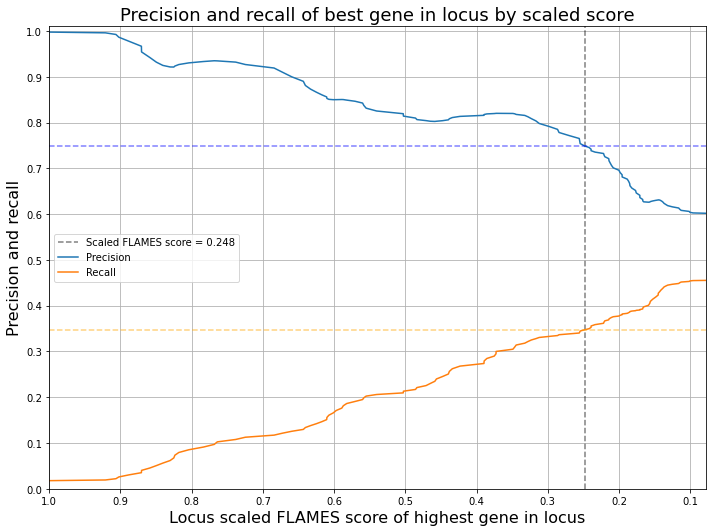

In [4]:
df = pd.read_csv(os.path.join('benchmarking_results', 'calibration', 'calibration.tsv'), sep='\t')
tempdf = df[df['FLAMES_causal'] == 1]
tempdf = tempdf[tempdf['FLAMES_raw'] > 0.136]
tempdf = tempdf.sort_values('FLAMES_scaled', ascending= False)
cumsum = np.cumsum(tempdf['TP'])
rank = np.arange(len(cumsum)) + 1
Num = sum(df['TP'])
precisions = cumsum / rank
recalls = cumsum / Num

precisions = gaussian_filter1d(precisions, sigma=3)
recalls = gaussian_filter1d(recalls, sigma=3)

# Sample data
x = tempdf['FLAMES_scaled']
plt.figure(figsize=(10, 7.5))

prec = list(precisions)[len(tempdf[tempdf['FLAMES_scaled'] > 0.248])-1]
rec = list(recalls)[len(tempdf[tempdf['FLAMES_scaled'] > 0.248])-1]
plt.axvline(x=0.248, color='black',  alpha = 0.5, linestyle='--', label=f'Scaled FLAMES score = {0.248:.3f}')

# Plot the data
plt.plot(x, precisions, label='Precision')
plt.plot(x, recalls, label='Recall')

plt.gca().invert_xaxis()
# Add labels and title
plt.ylabel('Precision and recall', fontsize=16)
plt.xlabel('Locus scaled FLAMES score of highest gene in locus', fontsize=16)
plt.title('Precision and recall of best gene in locus by scaled score', fontsize=18)
plt.legend()

# Plot horizontal lines at the intersection points
plt.axhline(y=prec, color='blue',alpha=0.5 ,linestyle='--')
plt.axhline(y=rec,alpha=0.5, color='orange', linestyle='--')

plt.ylim([0.0, 1.01])
plt.xlim([max(x), min(x)])
plt.xticks(np.arange(0.1, 1.001 , 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))

# Enable grid
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join('benchmarking_results', 'calibration','Calibration'+'.svg'), format='svg')
# Show plot
plt.show()

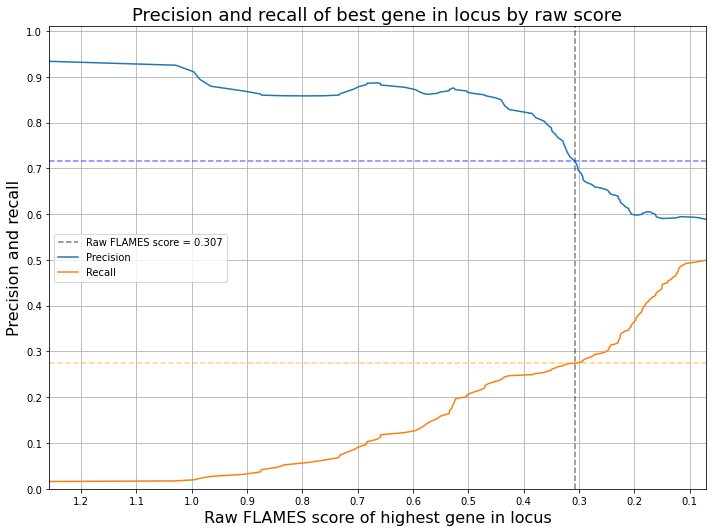

In [5]:
tempdf = df[df['FLAMES_causal'] == 1]
tempdf = tempdf.sort_values('FLAMES_raw', ascending= False)
cumsum = np.cumsum(tempdf['TP'])
rank = np.arange(len(cumsum)) + 1
Num = sum(df['TP'])
precisions = cumsum / rank
recalls = cumsum / Num
precisions = gaussian_filter1d(precisions, sigma=3)
recalls = gaussian_filter1d(recalls, sigma=3)

x = tempdf['FLAMES_raw']
plt.figure(figsize=(10, 7.5))

prec = list(precisions)[len(tempdf[tempdf['FLAMES_raw'] > 0.307])-1]
rec = list(recalls)[len(tempdf[tempdf['FLAMES_raw'] > 0.307])-1]
plt.axvline(x=0.307, color='black',  alpha = 0.5, linestyle='--', label=f'Raw FLAMES score = {0.307:.3f}')

# # Plot the data
plt.plot(x, precisions, label='Precision')
plt.plot(x, recalls, label='Recall')

plt.gca().invert_xaxis()
# Add labels and title
plt.ylabel('Precision and recall', fontsize=16)
plt.xlabel('Raw FLAMES score of highest gene in locus', fontsize=16)
plt.title('Precision and recall of best gene in locus by raw score', fontsize=18)
plt.legend()

# Plot horizontal lines at the intersection points
plt.axhline(y=prec, color='blue',alpha=0.5 ,linestyle='--')
plt.axhline(y=rec,alpha=0.5, color='orange', linestyle='--')

plt.ylim([0.0, 1.01])
plt.xlim([max(x), min(x)])
plt.xticks(np.arange(0.1, 1.3 , 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))

# Enable grid
plt.grid(True)
# Show plot
plt.tight_layout()
plt.savefig(os.path.join('benchmarking_results', 'calibration','Calibration_raw'+'.svg'), format='svg')
plt.show()

# SCZ clustering analysis

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


0.24270832209049648


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


0.18990747003249858


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


0.1887992772708299
Optimum_number of clusters = 2


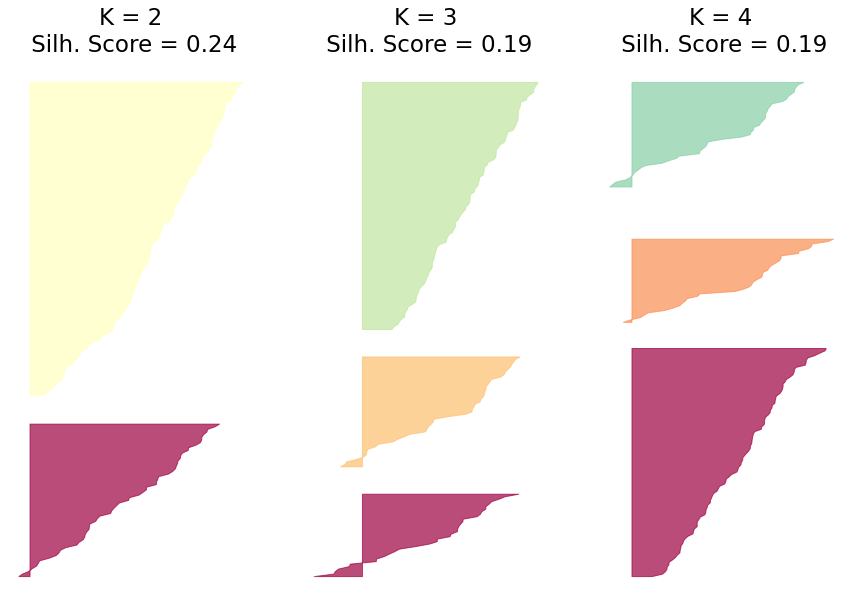

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


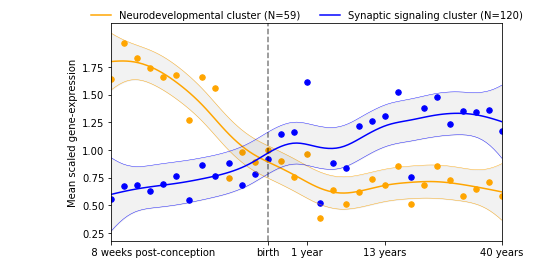

In [104]:
FLAMES_SCZ = ["ENSG00000079841", "ENSG00000151067", "ENSG00000152127", "ENSG00000119772", "ENSG00000251322", "ENSG00000186487", "ENSG00000180530", "ENSG00000198597", "ENSG00000060069", "ENSG00000196628", "ENSG00000187323", "ENSG00000153944", "ENSG00000140945", "ENSG00000162702", "ENSG00000127152", "ENSG00000149527", "ENSG00000151320", "ENSG00000184304", "ENSG00000118946", "ENSG00000133107", "ENSG00000075035", "ENSG00000257860", "ENSG00000184752", "ENSG00000257242", "ENSG00000121749", "ENSG00000162989", "ENSG00000138430", "ENSG00000170396", "ENSG00000156269", "ENSG00000135298", "ENSG00000188107", "ENSG00000170624", "ENSG00000112893", "ENSG00000184349", "ENSG00000164199", "ENSG00000150625", "ENSG00000109452", "ENSG00000164100", "ENSG00000177565", "ENSG00000119042", "ENSG00000182447", "ENSG00000185565", "ENSG00000114439", "ENSG00000114861", "ENSG00000189283", "ENSG00000168016", "ENSG00000144642", "ENSG00000131374", "ENSG00000144619", "ENSG00000036257", "ENSG00000133687", "ENSG00000183454", "ENSG00000188641", "ENSG00000067082", "ENSG00000160563", "ENSG00000119121", "ENSG00000153707", "ENSG00000171045", "ENSG00000155090", "ENSG00000156103", "ENSG00000178538", "ENSG00000117569", "ENSG00000183117", "ENSG00000122778", "ENSG00000131558", "ENSG00000183166", "ENSG00000185274", "ENSG00000105866", "ENSG00000122584", "ENSG00000172260", "ENSG00000152822", "ENSG00000146416", "ENSG00000152894", "ENSG00000118689", "ENSG00000172461", "ENSG00000196422", "ENSG00000184588", "ENSG00000138311", "ENSG00000183715", "ENSG00000120451", "ENSG00000023171", "ENSG00000149295", "ENSG00000187398", "ENSG00000138821", "ENSG00000115392", "ENSG00000204683", "ENSG00000176454", "ENSG00000158445", "ENSG00000140564", "ENSG00000171604", "ENSG00000182732", "ENSG00000168993", "ENSG00000105894", "ENSG00000173114", "ENSG00000133878", "ENSG00000152092", "ENSG00000159640", "ENSG00000221914", "ENSG00000109956", "ENSG00000169554", "ENSG00000170571", "ENSG00000080854", "ENSG00000180828", "ENSG00000152932", "ENSG00000136928", "ENSG00000006740", "ENSG00000198822", "ENSG00000145335", "ENSG00000139746", "ENSG00000117020", "ENSG00000164588", "ENSG00000120658", "ENSG00000142599", "ENSG00000105926", "ENSG00000165995", "ENSG00000121621", "ENSG00000109572", "ENSG00000115844", "ENSG00000196141", "ENSG00000144040", "ENSG00000166886", "ENSG00000037749", "ENSG00000081189", "ENSG00000139116", "ENSG00000137075", "ENSG00000081248", "ENSG00000268182", "ENSG00000154822", "ENSG00000162374", "ENSG00000065609", "ENSG00000100346", "ENSG00000136895", "ENSG00000116127", "ENSG00000110931", "ENSG00000137843", "ENSG00000140526", "ENSG00000002822", "ENSG00000108953", "ENSG00000070961", "ENSG00000130449", "ENSG00000080644", "ENSG00000197933", "ENSG00000128487", "ENSG00000144290", "ENSG00000162869", "ENSG00000048828", "ENSG00000131409", "ENSG00000120899", "ENSG00000130173", "ENSG00000118007", "ENSG00000154146", "ENSG00000135250", "ENSG00000145075", "ENSG00000125107", "ENSG00000112659", "ENSG00000066248", "ENSG00000163637", "ENSG00000116329", "ENSG00000179912", "ENSG00000115896", "ENSG00000104885", "ENSG00000167720", "ENSG00000101445", "ENSG00000171735", "ENSG00000250091", "ENSG00000102858", "ENSG00000255150", "ENSG00000174437", "ENSG00000157782", "ENSG00000166716", "ENSG00000180900", "ENSG00000172831", "ENSG00000166484", "ENSG00000141759", "ENSG00000150967", "ENSG00000103723", "ENSG00000130779", "ENSG00000115073", "ENSG00000120738", "ENSG00000126456"]
df_rows = pd.read_csv(os.path.join('Clusters', 'BRAINSPAN', 'genes_matrix_csv','rows_metadata.csv'))
df_cols = pd.read_csv(os.path.join('Clusters', 'BRAINSPAN', 'genes_matrix_csv', 'columns_metadata.csv'))
colno = df_cols['column_num']
names=df_rows['ensembl_gene_id']
df_brainspan = pd.read_csv(os.path.join('Clusters', 'BRAINSPAN', 'genes_matrix_csv', 'expression_matrix.csv.gz'), header= None, names = colno)
keep_structures = []
df_cortex = []
for index, row in df_cols.iterrows():
    if 'CORTEX' in row['structure_name'].upper():
        df_cortex.append('yes')
    else:
        df_cortex.append('no')
df_cols['cortex'] = df_cortex
df_cols['group'] = df_cols['age'] + df_cols['cortex']

group_df = df_cols.set_index('column_num')['group']

# Merge the data and group DataFrames using an appropriate key (e.g., index)
merged_df = df_brainspan.transpose().join(group_df)

# Group by the 'group' column and calculate row-wise mean within each group
grouped_df = merged_df.groupby('group').mean()
filtered_df = grouped_df[~grouped_df.index.str.contains('no')]
filtered_df.columns = df_rows['ensembl_gene_id']
keepcols = [x for x in filtered_df.columns if x in FLAMES_SCZ]
filtered_df = filtered_df[keepcols]
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.div(filtered_df.mean())
rowwise_means = filtered_df.mean(axis=1)

# Reset the index to have 'group' as a regular column
rowwise_means = rowwise_means.reset_index()
rowwise_means['group'] = rowwise_means['group'].str.replace('yes', '')
rows = []
for x in df_cols['age']:
    if not x in rows:
        rows.append(x)
rowwise_means = rowwise_means.set_index('group').loc[rows].reset_index()

#Clustering analysis
data = filtered_df.transpose()

# Range of k values to test
range_n_clusters = [2, 3, 4]

# Initialize a subplot to display silhouette plots
plt.figure(figsize=(15, 10))
best_n = 0
best_s = 0
for i, n_clusters in enumerate(range_n_clusters):
    # Create a subplot with 1 row and 5 columns
    plt.subplot(1, len(range_n_clusters), i + 1)

    # Initialize the KMeans model with the current value of k
    kmeans = KMeans(n_clusters=n_clusters, random_state=len('random state'))
    cluster_labels = kmeans.fit_predict(data)

    # Calculate the silhouette score for the current clustering
    silhouette_avg = silhouette_score(data, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        # Aggregate the silhouette scores for samples in cluster j and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = plt.cm.Spectral(float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper + 10  # 10 for the 0 samples
    print(silhouette_avg)
    plt.title(f"K = {n_clusters}\n Silh. Score = {silhouette_avg:.2f}", fontsize = 23)
    plt.xlabel("Silhouette coefficient values")
    plt.gca().set_axis_off()
    if silhouette_avg > best_s:
        best_s = silhouette_avg
        best_n = n_clusters
print(f'Optimum_number of clusters = {best_n}')
plt.savefig('clusters_silho' +'.svg', format='svg')
plt.show()

# Choose the optimal number of clusters based on the Elbow Method
optimal_k = best_n  # Example, replace with your chosen value

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n, random_state=len('random_state'))
kmeans.fit(data)

# Get cluster assignments for each data point
labels = kmeans.labels_
labels = [1-x for x in labels]
#plot clusters
clust_df = []
for k  in range(best_n):
    mask = []
    keeps = []
    for i,x in enumerate(labels):
        if x == k:
            mask.append(True)
        else:
            mask.append(False)

    rowwise_means = filtered_df.loc[:, mask].mean(axis=1)

    # Reset the index to have 'group' as a regular column
    rowwise_means = rowwise_means.reset_index()
    rowwise_means['group'] = rowwise_means['group'].str.replace('yes', '')
    rows = []
    for x in df_cols['age']:
        if not x in rows:
            rows.append(x)
    rowwise_means = rowwise_means.set_index('group').loc[rows].reset_index()
    clust_df.append(rowwise_means)

f = plt.figure(figsize=(7, 4))
clust_values = []

for dfx in clust_df:
    y = dfx[0]
    x = [x for x in range(len(y))]
    data = pd.DataFrame([x,y])
    # Sample data

    # Create a GAM model with a smooth term
    gam = LinearGAM(s(0, lam=1))  # Use 's' to define a spline term

    # Fit the GAM model
    gam.fit(x, y)

    # Make predictions using the model
    x_new = np.array([6, 7, 8])
    y_pred = gam.predict(x_new)
    
    # Visualize the model
    xx = np.linspace(min(x), max(x), 100)
    yy = gam.predict(xx)
    ci = gam.confidence_intervals(xx)
    clust_values.append([xx, yy, ci[:,0], ci[:,1]])


# Plot each cluster, ammend this if you have more clusters
col = 'orange'
plt.plot(clust_values[1][0], clust_values[1][1], c=col, label=f'Neurodevelopmental cluster (N={sum(labels)})')
plt.plot(clust_values[1][0], clust_values[1][2], c=col, lw = .4)
plt.plot(clust_values[1][0], clust_values[1][3], c=col, lw = .4)
plt.fill_between(clust_values[1][0],  clust_values[1][2], clust_values[1][3], color="k", alpha=0.05)
plt.scatter([x for x in range(len(y))],clust_df[1][0], c=col, s=30)

col='b'
plt.plot(clust_values[0][0], clust_values[0][1], c=col, label=f'Synaptic signaling cluster (N={len(labels) - sum(labels)})')
plt.plot(clust_values[0][0], clust_values[0][2], c=col, lw = .4)
plt.plot(clust_values[0][0], clust_values[0][3], c=col, lw = .4)
plt.fill_between(clust_values[0][0],  clust_values[0][2], clust_values[0][3], color="k", alpha=0.05)
plt.scatter([x for x in range(len(y))],clust_df[0][0], c=col, s=30)


lbls = []
tcks = []
for i in [0,12, 15, 21,30]:
    lbls.append(rowwise_means['group'][i])
    tcks.append(x[i])
plt.axvline(x=12, color='black', linestyle='--', alpha=0.5)
plt.xticks(tcks, ['                           8 weeks post-conception', 'birth', '1 year', '13 years', '40 years'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=2, frameon=False)
plt.xlim(0,30)
plt.yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75])
plt.ylabel('Mean scaled gene-expression')
plt.savefig(os.path.join('Clusters', 'Cluster_expression.svg'), format='svg')

filepath = os.path.join(basedir, 'Clusters')
filtered_df = df_brainspan.transpose()

filtered_df.columns = df_rows['ensembl_gene_id']
filtered_df = filtered_df[keepcols]
filtered_df = filtered_df.div(filtered_df.mean())


df0 = filtered_df.iloc[:, [i for i, label in enumerate(labels) if label == 0]].mean(axis=1)
df1 = filtered_df.iloc[:, [i for i, label in enumerate(labels) if label == 1]].mean(axis=1)
df0 = pd.DataFrame(df0).rename(columns={0: 'expression'})
df1 = pd.DataFrame(df1).rename(columns={0: 'expression'})


pre = df_cols[df_cols['age'] == '8 pcw'][['column_num', 'structure_acronym', 'structure_name', 'structure_id']]
post = df_cols[df_cols['age'] == '40 yrs'][['column_num', 'structure_acronym', 'structure_name','structure_id']]
pre0 = pre.merge(df0, left_on='column_num', right_index=True, how = 'inner')

pre1 = pre.merge(df1, left_on='column_num', right_index=True, how = 'inner')
post0 = post.merge(df0, left_on='column_num', right_index=True, how = 'inner')
post1 = post.merge(df1, left_on='column_num', right_index=True, how = 'inner')

pre0.drop('column_num', axis=1, inplace=True)
pre1.drop('column_num', axis=1, inplace=True)
post0.drop('column_num', axis=1, inplace=True)
post1.drop('column_num', axis=1, inplace=True)


pre0.to_csv(os.path.join(filepath,'pre0.tsv'), sep='\t', index=False)
pre1.to_csv(os.path.join(filepath,'pre1.tsv'), sep='\t', index=False)
post0.to_csv(os.path.join(filepath,'post0.tsv'), sep='\t', index=False)
post1.to_csv(os.path.join(filepath,'post1.tsv'), sep='\t', index=False)


In [105]:
from scipy import stats

#test if timepoints are significantly different:
t_stat, p_value = stats.mannwhitneyu(pre1['expression'], pre0['expression'])
print('8 weeks pc cluster 1 vs cluster 2:')
print("u-statistic:", t_stat)
print("p-value:", p_value)

print('40 years weeks pc cluster 1 vs cluster 2:')
t_stat, p_value = stats.mannwhitneyu(post1['expression'], post0['expression'])
print("u-statistic:", t_stat)
print("p-value:", p_value)

8 weeks pc cluster 1 vs cluster 2:
u-statistic: 256.0
p-value: 1.5449101737495915e-06
40 years weeks pc cluster 1 vs cluster 2:
u-statistic: 0.0
p-value: 3.391821390825095e-06


In [79]:
import statsmodels.api as sm
import pandas as pd

def test_geneset(df, S1='S1',F='F', Br='Br', conditional=True):
    overlapping_genes = sum(df[S1]*df[F])
    if overlapping_genes ==0:
        return 1, 0, overlapping_genes
    if sum(df[S1]) < 2:
        return 1, 0, overlapping_genes
    #Init model
    if conditional:
        X = sm.add_constant(df[[S1, Br]])
    else:
        X = sm.add_constant(df[[S1]])
    model = sm.Logit(df[F], X)
    #Fit
    try:
        result = model.fit(disp=0)  # Setting disp=0 to suppress convergence messages
    except:
        return 1, 0, overlapping_genes
    # Get the p-values for the coefficients
    pval = result.pvalues[S1]
    beta = result.params[S1]
    return pval, beta, overlapping_genes

#Load SYNGO ontologies
syngo_ontologies = pd.read_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files' , 'SynGO_bulk_download_release_20231201', 'syngo_ontologies.txt'), sep='\t')
syngo_genes = pd.read_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files' , 'SynGO_bulk_download_release_20231201', 'syngo_genes.txt'), sep='\t')

#Load brain expressed genes
brain_expressed = ["HGNC:24517","HGNC:24023","HGNC:329","HGNC:26062","HGNC:24188","HGNC:17978","HGNC:10601","HGNC:16754","HGNC:26914","HGNC:26052","HGNC:3084","HGNC:20570","HGNC:42950","HGNC:37099","HGNC:24007","HGNC:25186","HGNC:25016","HGNC:42951","HGNC:30577","HGNC:33941","HGNC:1730","HGNC:20863","HGNC:4396","HGNC:29368","HGNC:4084","HGNC:9412","HGNC:10896","HGNC:25852","HGNC:8851","HGNC:29037","HGNC:19366","HGNC:19764","HGNC:28390","HGNC:27007","HGNC:12759","HGNC:12003","HGNC:29207","HGNC:24866","HGNC:2773","HGNC:30801","HGNC:19104","HGNC:6229","HGNC:16816","HGNC:32947","HGNC:24157","HGNC:11910","HGNC:29105","HGNC:26265","HGNC:20855","HGNC:25570","HGNC:18806","HGNC:8847","HGNC:16369","HGNC:17939","HGNC:9965","HGNC:3350","HGNC:29681","HGNC:33719","HGNC:17447","HGNC:16913","HGNC:12500","HGNC:16636","HGNC:2257","HGNC:2772","HGNC:8856","HGNC:26730","HGNC:11571","HGNC:9138","HGNC:3942","HGNC:29251","HGNC:13581","HGNC:24847","HGNC:25054","HGNC:2024","HGNC:23595","HGNC:9347","HGNC:29173","HGNC:25488","HGNC:29157","HGNC:29131","HGNC:27653","HGNC:17575","HGNC:28339","HGNC:26717","HGNC:28127","HGNC:29249","HGNC:26088","HGNC:21299","HGNC:30213","HGNC:25540","HGNC:28246","HGNC:27006","HGNC:28957","HGNC:18477","HGNC:26001","HGNC:5301","HGNC:29038","HGNC:24190","HGNC:31791","HGNC:14581","HGNC:28819","HGNC:3298","HGNC:25076","HGNC:9858","HGNC:18533","HGNC:3391","HGNC:29079","HGNC:14985","HGNC:5047","HGNC:25022","HGNC:18584","HGNC:28070","HGNC:25233","HGNC:3042","HGNC:16638","HGNC:25572","HGNC:18640","HGNC:19080","HGNC:15999","HGNC:6510","HGNC:3515","HGNC:18981","HGNC:20603","HGNC:11110","HGNC:25513","HGNC:25720","HGNC:8045","HGNC:34348","HGNC:11071","HGNC:25363","HGNC:15584","HGNC:4484","HGNC:25230","HGNC:28530","HGNC:11430","HGNC:9296","HGNC:10290","HGNC:3521","HGNC:15470","HGNC:871","HGNC:30813","HGNC:4370","HGNC:3377","HGNC:19691","HGNC:9683","HGNC:10660","HGNC:14957","HGNC:25743","HGNC:30857","HGNC:30246","HGNC:944","HGNC:18116","HGNC:6399","HGNC:28163","HGNC:25545","HGNC:7142","HGNC:25501","HGNC:12840","HGNC:25768","HGNC:20240","HGNC:5144","HGNC:29957","HGNC:25574","HGNC:18079","HGNC:19290","HGNC:30368","HGNC:13050","HGNC:10774","HGNC:13055","HGNC:30071","HGNC:17597","HGNC:30774","HGNC:26800","HGNC:3262","HGNC:18421","HGNC:25514","HGNC:4581","HGNC:25674","HGNC:26039","HGNC:19987","HGNC:26452","HGNC:28905","HGNC:24789","HGNC:6077","HGNC:13664","HGNC:17819","HGNC:18212","HGNC:20286","HGNC:9325","HGNC:10025","HGNC:2218","HGNC:28053","HGNC:26115","HGNC:21292","HGNC:6298","HGNC:13561","HGNC:29178","HGNC:28725","HGNC:29204","HGNC:15531","HGNC:19971","HGNC:29040","HGNC:26948","HGNC:22978","HGNC:10866","HGNC:727","HGNC:16853","HGNC:925","HGNC:28688","HGNC:18291","HGNC:17276","HGNC:25552","HGNC:9586","HGNC:26117","HGNC:12591","HGNC:29299","HGNC:28242","HGNC:7527","HGNC:7644","HGNC:8981","HGNC:19139","HGNC:16917","HGNC:12590","HGNC:3553","HGNC:18803","HGNC:20244","HGNC:25892","HGNC:25668","HGNC:3315","HGNC:10056","HGNC:3419","HGNC:9778","HGNC:30547","HGNC:6775","HGNC:25930","HGNC:28981","HGNC:25820","HGNC:6700","HGNC:29525","HGNC:15674","HGNC:12394","HGNC:20001","HGNC:12623","HGNC:2661","HGNC:29401","HGNC:19884","HGNC:7784","HGNC:28881","HGNC:12607","HGNC:19190","HGNC:16040","HGNC:29379","HGNC:13225","HGNC:25577","HGNC:363","HGNC:15469","HGNC:8781","HGNC:25412","HGNC:26882","HGNC:18531","HGNC:26004","HGNC:10782","HGNC:25374","HGNC:4906","HGNC:13058","HGNC:17302","HGNC:19661","HGNC:25346","HGNC:24757","HGNC:7327","HGNC:19342","HGNC:365","HGNC:20059","HGNC:24741","HGNC:4004","HGNC:26242","HGNC:9381","HGNC:16509","HGNC:24871","HGNC:2715","HGNC:26089","HGNC:20821","HGNC:29225","HGNC:5193","HGNC:6644","HGNC:9406","HGNC:25073","HGNC:30692","HGNC:14104","HGNC:954","HGNC:29222","HGNC:20193","HGNC:1745","HGNC:23758","HGNC:29192","HGNC:14373","HGNC:25791","HGNC:32213","HGNC:29535","HGNC:30207","HGNC:28689","HGNC:26477","HGNC:21393","HGNC:17662","HGNC:31703","HGNC:23496","HGNC:25403","HGNC:17981","HGNC:3516","HGNC:17990","HGNC:2186","HGNC:18666","HGNC:18241","HGNC:23319","HGNC:27637","HGNC:25512","HGNC:11446","HGNC:29501","HGNC:29141","HGNC:11546","HGNC:10537","HGNC:3231","HGNC:24472","HGNC:11186","HGNC:28713","HGNC:26804","HGNC:20824","HGNC:13300","HGNC:469","HGNC:4636","HGNC:4637","HGNC:344","HGNC:25916","HGNC:449","HGNC:31399","HGNC:6236","HGNC:6220","HGNC:24289","HGNC:8524","HGNC:6239","HGNC:20785","HGNC:21590","HGNC:29647","HGNC:8939","HGNC:25642","HGNC:572","HGNC:17641","HGNC:19006","HGNC:16290","HGNC:975","HGNC:26119","HGNC:7818","HGNC:20301","HGNC:799","HGNC:6822","HGNC:8923","HGNC:8853","HGNC:26323","HGNC:16861","HGNC:26618","HGNC:31984","HGNC:9379","HGNC:1916","HGNC:1008","HGNC:20566","HGNC:14579","HGNC:16673","HGNC:1372","HGNC:25200","HGNC:17348","HGNC:29039","HGNC:30740","HGNC:3360","HGNC:10761","HGNC:10740","HGNC:32070","HGNC:11644","HGNC:29277","HGNC:8984","HGNC:9986","HGNC:18801","HGNC:17429","HGNC:20073","HGNC:11967","HGNC:14277","HGNC:11713","HGNC:31814","HGNC:37210","HGNC:17947","HGNC:24511","HGNC:26153","HGNC:30778","HGNC:29044","HGNC:29876","HGNC:29877","HGNC:13534","HGNC:15698","HGNC:1962","HGNC:225","HGNC:6292","HGNC:9141","HGNC:30257","HGNC:19019","HGNC:1233","HGNC:2069","HGNC:19183","HGNC:17153","HGNC:19088","HGNC:29678","HGNC:25973","HGNC:19239","HGNC:29145","HGNC:682","HGNC:1237","HGNC:29036","HGNC:1043","HGNC:30132","HGNC:24644","HGNC:14572","HGNC:30780","HGNC:6997","HGNC:17410","HGNC:23059","HGNC:9343","HGNC:14580","HGNC:17601","HGNC:4035","HGNC:27647","HGNC:32063","HGNC:6256","HGNC:6270","HGNC:17813","HGNC:800","HGNC:8822","HGNC:24891","HGNC:2230","HGNC:7817","HGNC:15511","HGNC:12593","HGNC:28489","HGNC:8867","HGNC:12620","HGNC:9280","HGNC:7708","HGNC:25756","HGNC:20448","HGNC:32325","HGNC:26431","HGNC:3067","HGNC:16859","HGNC:34351","HGNC:10000","HGNC:13495","HGNC:18800","HGNC:30631","HGNC:18131","HGNC:9212","HGNC:804","HGNC:20461","HGNC:28051","HGNC:25565","HGNC:28793","HGNC:17060","HGNC:24903","HGNC:12645","HGNC:24248","HGNC:29125","HGNC:29434","HGNC:24663","HGNC:30423","HGNC:14049","HGNC:11953","HGNC:773","HGNC:13746","HGNC:23017","HGNC:77","HGNC:24238","HGNC:29327","HGNC:11441","HGNC:1392","HGNC:4341","HGNC:16810","HGNC:2750","HGNC:16789","HGNC:16792","HGNC:30281","HGNC:16790","HGNC:15494","HGNC:22393","HGNC:19678","HGNC:11313","HGNC:917","HGNC:24819","HGNC:2343","HGNC:13075","HGNC:29188","HGNC:29442","HGNC:18823","HGNC:19425","HGNC:27139","HGNC:17315","HGNC:14923","HGNC:25192","HGNC:25009","HGNC:11510","HGNC:9797","HGNC:19360","HGNC:20173","HGNC:9248","HGNC:262","HGNC:29093","HGNC:17053","HGNC:16914","HGNC:29866","HGNC:2172","HGNC:32349","HGNC:9888","HGNC:29043","HGNC:24239","HGNC:25573","HGNC:8751","HGNC:25433","HGNC:29923","HGNC:9100","HGNC:14585","HGNC:26319","HGNC:23143","HGNC:6250","HGNC:25594","HGNC:25593","HGNC:24548","HGNC:27010","HGNC:24682","HGNC:30534","HGNC:10439","HGNC:21305","HGNC:11768","HGNC:25355","HGNC:3418","HGNC:17168","HGNC:6896","HGNC:25873","HGNC:24008","HGNC:26512","HGNC:25470","HGNC:12000","HGNC:29046","HGNC:8070","HGNC:26802","HGNC:11304","HGNC:270","HGNC:30491","HGNC:6179","HGNC:9509","HGNC:1737","HGNC:30669","HGNC:19032","HGNC:4693","HGNC:17494","HGNC:32062","HGNC:32047","HGNC:16281","HGNC:13430","HGNC:20507","HGNC:20514","HGNC:27146","HGNC:9781","HGNC:29578","HGNC:18016","HGNC:41","HGNC:19405","HGNC:6546","HGNC:333","HGNC:26204","HGNC:29561","HGNC:31859","HGNC:25332","HGNC:12380","HGNC:8736","HGNC:29798","HGNC:6272","HGNC:23616","HGNC:18025","HGNC:11568","HGNC:20947","HGNC:15550","HGNC:4407","HGNC:1968","HGNC:11862","HGNC:14074","HGNC:10003","HGNC:14007","HGNC:1941","HGNC:26879","HGNC:28920","HGNC:393","HGNC:13030","HGNC:26970","HGNC:5048","HGNC:25484","HGNC:15513","HGNC:26486","HGNC:33759","HGNC:23713","HGNC:29583","HGNC:19578","HGNC:19575","HGNC:29360","HGNC:26049","HGNC:16966","HGNC:29150","HGNC:5387","HGNC:31406","HGNC:227","HGNC:8878","HGNC:17663","HGNC:19765","HGNC:23484","HGNC:23471","HGNC:16944","HGNC:20256","HGNC:6327","HGNC:17303","HGNC:2550","HGNC:17854","HGNC:17702","HGNC:19341","HGNC:19685","HGNC:29526","HGNC:17715","HGNC:28582","HGNC:7858","HGNC:23522","HGNC:23578","HGNC:9590","HGNC:19359","HGNC:2977","HGNC:11357","HGNC:20860","HGNC:1402","HGNC:23529","HGNC:31448","HGNC:32697","HGNC:23332","HGNC:1066","HGNC:8997","HGNC:23725","HGNC:23333","HGNC:28388","HGNC:26160","HGNC:23689","HGNC:4093","HGNC:11320","HGNC:29186","HGNC:23338","HGNC:14244","HGNC:17327","HGNC:16348","HGNC:6324","HGNC:19876","HGNC:2552","HGNC:13041","HGNC:13043","HGNC:13096","HGNC:13102","HGNC:13097","HGNC:23505","HGNC:9967","HGNC:24246","HGNC:13031","HGNC:13095","HGNC:20793","HGNC:23356","HGNC:23414","HGNC:23459","HGNC:17167","HGNC:23730","HGNC:28572","HGNC:6881","HGNC:30320","HGNC:21536","HGNC:3438","HGNC:25590","HGNC:8605","HGNC:23466","HGNC:23416","HGNC:17086","HGNC:30880","HGNC:29378","HGNC:19371","HGNC:23520","HGNC:18782","HGNC:494","HGNC:18194","HGNC:23506","HGNC:12313","HGNC:23711","HGNC:2511","HGNC:19410","HGNC:28908","HGNC:13907","HGNC:5043","HGNC:19761","HGNC:2939","HGNC:10986","HGNC:24236","HGNC:23508","HGNC:23419","HGNC:12711","HGNC:11471","HGNC:4922","HGNC:23298","HGNC:23519","HGNC:2190","HGNC:14453","HGNC:9226","HGNC:17425","HGNC:23421","HGNC:7865","HGNC:23530","HGNC:14899","HGNC:12568","HGNC:13733","HGNC:13564","HGNC:24268","HGNC:14891","HGNC:1530","HGNC:23526","HGNC:29162","HGNC:19123","HGNC:9315","HGNC:23513","HGNC:10705","HGNC:23528","HGNC:1463","HGNC:17582","HGNC:26320","HGNC:6284","HGNC:30074","HGNC:16493","HGNC:26911","HGNC:28651","HGNC:7999","HGNC:9990","HGNC:29197","HGNC:4575","HGNC:11141","HGNC:4335","HGNC:24105","HGNC:5407","HGNC:13328","HGNC:8598","HGNC:17688","HGNC:26736","HGNC:15677","HGNC:23428","HGNC:21746","HGNC:1162","HGNC:6572","HGNC:29082","HGNC:4861","HGNC:23434","HGNC:20707","HGNC:29503","HGNC:8888","HGNC:20714","HGNC:13824","HGNC:30031","HGNC:24001","HGNC:26559","HGNC:31668","HGNC:14882","HGNC:102","HGNC:4432","HGNC:1974","HGNC:25613","HGNC:20984","HGNC:9011","HGNC:10571","HGNC:23197","HGNC:7703","HGNC:17814","HGNC:10735","HGNC:29381","HGNC:26257","HGNC:16087","HGNC:1144","HGNC:10847","HGNC:7056","HGNC:15522","HGNC:15608","HGNC:4181","HGNC:9507","HGNC:28155","HGNC:28352","HGNC:25880","HGNC:26196","HGNC:167","HGNC:16466","HGNC:694","HGNC:103","HGNC:8022","HGNC:6057","HGNC:11539","HGNC:23494","HGNC:23664","HGNC:16699","HGNC:245","HGNC:7534","HGNC:3071","HGNC:2468","HGNC:17660","HGNC:24349","HGNC:25901","HGNC:78","HGNC:16060","HGNC:29063","HGNC:19022","HGNC:31670","HGNC:29319","HGNC:3341","HGNC:29152","HGNC:25794","HGNC:31793","HGNC:11804","HGNC:17054","HGNC:23531","HGNC:31365","HGNC:13831","HGNC:3689","HGNC:782","HGNC:14335","HGNC:9476","HGNC:25822","HGNC:28578","HGNC:14283","HGNC:4481","HGNC:8091","HGNC:30042","HGNC:28968","HGNC:33787","HGNC:28975","HGNC:18224","HGNC:2495","HGNC:12592","HGNC:26563","HGNC:33859","HGNC:23533","HGNC:49533","HGNC:23732","HGNC:1084","HGNC:23523","HGNC:3016","HGNC:21332","HGNC:6076","HGNC:19321","HGNC:13838","HGNC:29374","HGNC:18599","HGNC:17938","HGNC:16871","HGNC:28852","HGNC:29550","HGNC:14931","HGNC:26315","HGNC:15463","HGNC:5173","HGNC:1166","HGNC:24351","HGNC:3025","HGNC:14677","HGNC:26616","HGNC:24153","HGNC:19954","HGNC:16491","HGNC:562","HGNC:16476","HGNC:11405","HGNC:3074","HGNC:23596","HGNC:40022","HGNC:7640","HGNC:12986","HGNC:11386","HGNC:10451","HGNC:21161","HGNC:1571","HGNC:11120","HGNC:581","HGNC:10064","HGNC:17160","HGNC:19265","HGNC:12406","HGNC:30338","HGNC:29005","HGNC:1170","HGNC:1168","HGNC:1167","HGNC:19344","HGNC:28948","HGNC:2135","HGNC:21159","HGNC:30803","HGNC:30488","HGNC:20076","HGNC:2893","HGNC:24693","HGNC:701","HGNC:21445","HGNC:26222","HGNC:8779","HGNC:8971","HGNC:42400","HGNC:6257","HGNC:59","HGNC:6233","HGNC:17499","HGNC:4655","HGNC:9657","HGNC:18413","HGNC:15997","HGNC:30163","HGNC:7750","HGNC:16703","HGNC:25238","HGNC:23206","HGNC:14004","HGNC:17789","HGNC:1033","HGNC:26606","HGNC:26798","HGNC:26979","HGNC:26317","HGNC:1171","HGNC:8620","HGNC:26154","HGNC:25655","HGNC:2485","HGNC:24836","HGNC:13582","HGNC:6743","HGNC:29830","HGNC:10940","HGNC:17166","HGNC:19016","HGNC:27046","HGNC:25014","HGNC:29317","HGNC:594","HGNC:25596","HGNC:20660","HGNC:16842","HGNC:13996","HGNC:14962","HGNC:1969","HGNC:2385","HGNC:6882","HGNC:8857","HGNC:2857","HGNC:1953","HGNC:25990","HGNC:29091","HGNC:28959","HGNC:6696","HGNC:28720","HGNC:13504","HGNC:123","HGNC:6766","HGNC:20859","HGNC:9549","HGNC:2549","HGNC:7710","HGNC:23761","HGNC:14346","HGNC:19752","HGNC:18017","HGNC:3788","HGNC:32324","HGNC:339","HGNC:11327","HGNC:23053","HGNC:11814","HGNC:18328","HGNC:29600","HGNC:30739","HGNC:29151","HGNC:17896","HGNC:31092","HGNC:2717","HGNC:25018","HGNC:30098","HGNC:26034","HGNC:11514","HGNC:1165","HGNC:1181","HGNC:3650","HGNC:3575","HGNC:3574","HGNC:6058","HGNC:16448","HGNC:10254","HGNC:923","HGNC:33113","HGNC:4405","HGNC:25451","HGNC:28432","HGNC:17305","HGNC:1950","HGNC:10469","HGNC:25115","HGNC:3332","HGNC:27455","HGNC:25845","HGNC:23077","HGNC:3760","HGNC:11387","HGNC:936","HGNC:24300","HGNC:6279","HGNC:9355","HGNC:26757","HGNC:10433","HGNC:8009","HGNC:12950","HGNC:6864","HGNC:7010","HGNC:29829","HGNC:9310","HGNC:693","HGNC:1172","HGNC:9964","HGNC:18334","HGNC:14372","HGNC:18760","HGNC:5275","HGNC:1874","HGNC:26423","HGNC:29814","HGNC:3705","HGNC:24926","HGNC:28801","HGNC:3019","HGNC:24144","HGNC:10769","HGNC:30032","HGNC:20716","HGNC:28744","HGNC:28497","HGNC:18749","HGNC:15685","HGNC:11004","HGNC:18983","HGNC:30010","HGNC:966","HGNC:2531","HGNC:14219","HGNC:28842","HGNC:11276","HGNC:26197","HGNC:13721","HGNC:8636","HGNC:28456","HGNC:18381","HGNC:13606","HGNC:289","HGNC:27880","HGNC:30581","HGNC:29268","HGNC:358","HGNC:9003","HGNC:7716","HGNC:1937","HGNC:24283","HGNC:14479","HGNC:5542","HGNC:20820","HGNC:17589","HGNC:3681","HGNC:9245","HGNC:3338","HGNC:14295","HGNC:21070","HGNC:5987","HGNC:8059","HGNC:24531","HGNC:8777","HGNC:29114","HGNC:21726","HGNC:28999","HGNC:19079","HGNC:9786","HGNC:16653","HGNC:25687","HGNC:24564","HGNC:30178","HGNC:20898","HGNC:711","HGNC:26597","HGNC:28804","HGNC:6868","HGNC:12640","HGNC:51239","HGNC:18071","HGNC:16066","HGNC:8590","HGNC:2080","HGNC:19940","HGNC:18118","HGNC:27452","HGNC:20061","HGNC:29945","HGNC:28512","HGNC:9770","HGNC:30097","HGNC:2901","HGNC:30883","HGNC:24905","HGNC:15585","HGNC:3188","HGNC:6985","HGNC:4597","HGNC:23112","HGNC:19660","HGNC:29366","HGNC:2375","HGNC:34443","HGNC:4523","HGNC:25970","HGNC:26939","HGNC:29129","HGNC:23060","HGNC:30794","HGNC:7450","HGNC:26282","HGNC:29264","HGNC:2962","HGNC:4574","HGNC:29383","HGNC:22934","HGNC:14235","HGNC:4684","HGNC:25334","HGNC:16521","HGNC:2556","HGNC:7896","HGNC:795","HGNC:30578","HGNC:2735","HGNC:33788","HGNC:18357","HGNC:15672","HGNC:23695","HGNC:9689","HGNC:7656","HGNC:14908","HGNC:12625","HGNC:5298","HGNC:5951","HGNC:29165","HGNC:8575","HGNC:933","HGNC:29182","HGNC:14656","HGNC:4030","HGNC:10592","HGNC:10589","HGNC:12499","HGNC:7132","HGNC:25890","HGNC:26146","HGNC:23697","HGNC:2747","HGNC:23688","HGNC:30460","HGNC:19943","HGNC:14583","HGNC:4739","HGNC:29000","HGNC:17850","HGNC:13884","HGNC:14646","HGNC:11801","HGNC:9706","HGNC:28280","HGNC:14193","HGNC:4582","HGNC:11720","HGNC:10547","HGNC:11185","HGNC:29884","HGNC:24313","HGNC:5241","HGNC:29214","HGNC:20665","HGNC:12994","HGNC:8000","HGNC:26266","HGNC:13433","HGNC:26361","HGNC:16714","HGNC:3659","HGNC:26558","HGNC:18698","HGNC:17104","HGNC:26927","HGNC:23204","HGNC:17399","HGNC:7802","HGNC:13995","HGNC:598","HGNC:21532","HGNC:17941","HGNC:8143","HGNC:32326","HGNC:28119","HGNC:29560","HGNC:87","HGNC:25147","HGNC:921","HGNC:29193","HGNC:11045","HGNC:14540","HGNC:9824","HGNC:17072","HGNC:28624","HGNC:32443","HGNC:3720","HGNC:30879","HGNC:23078","HGNC:28206","HGNC:12425","HGNC:21640","HGNC:5188","HGNC:1184","HGNC:6218","HGNC:8023","HGNC:12642","HGNC:24970","HGNC:19423","HGNC:11955","HGNC:25338","HGNC:16758","HGNC:7126","HGNC:9629","HGNC:16693","HGNC:4400","HGNC:12628","HGNC:12009","HGNC:19138","HGNC:3353","HGNC:3033","HGNC:18371","HGNC:9719","HGNC:24818","HGNC:24539","HGNC:25526","HGNC:29228","HGNC:3182","HGNC:4068","HGNC:6375","HGNC:18889","HGNC:14920","HGNC:19108","HGNC:9338","HGNC:6698","HGNC:26524","HGNC:2350","HGNC:4473","HGNC:1785","HGNC:29288","HGNC:4586","HGNC:16461","HGNC:9678","HGNC:30796","HGNC:6643","HGNC:13819","HGNC:10956","HGNC:20175","HGNC:28139","HGNC:6541","HGNC:18290","HGNC:10869","HGNC:29062","HGNC:24649","HGNC:16617","HGNC:23098","HGNC:18984","HGNC:29252","HGNC:9853","HGNC:21259","HGNC:30795","HGNC:2736","HGNC:28338","HGNC:27281","HGNC:1049","HGNC:2973","HGNC:19349","HGNC:66","HGNC:15956","HGNC:2171","HGNC:17363","HGNC:19369","HGNC:29620","HGNC:17019","HGNC:25276","HGNC:7751","HGNC:33186","HGNC:13447","HGNC:26035","HGNC:28775","HGNC:33749","HGNC:26024","HGNC:1403","HGNC:17347","HGNC:18314","HGNC:654","HGNC:12775","HGNC:12774","HGNC:24458","HGNC:7133","HGNC:21166","HGNC:18268","HGNC:18809","HGNC:20766","HGNC:18650","HGNC:6252","HGNC:25031","HGNC:17067","HGNC:100","HGNC:11106","HGNC:23749","HGNC:24636","HGNC:29284","HGNC:10908","HGNC:24241","HGNC:16006","HGNC:11748","HGNC:9224","HGNC:11034","HGNC:10596","HGNC:172","HGNC:25920","HGNC:18966","HGNC:27465","HGNC:17590","HGNC:6851","HGNC:11569","HGNC:792","HGNC:29306","HGNC:1555","HGNC:5031","HGNC:17521","HGNC:8775","HGNC:29109","HGNC:4216","HGNC:24432","HGNC:9784","HGNC:13179","HGNC:29823","HGNC:11105","HGNC:18401","HGNC:28412","HGNC:26614","HGNC:13529","HGNC:20074","HGNC:11363","HGNC:29570","HGNC:9369","HGNC:11521","HGNC:7627","HGNC:6692","HGNC:8078","HGNC:29167","HGNC:6898","HGNC:2712","HGNC:6323","HGNC:23786","HGNC:24457","HGNC:30275","HGNC:14470","HGNC:4117","HGNC:16921","HGNC:10539","HGNC:25139","HGNC:12367","HGNC:14188","HGNC:17077","HGNC:21589","HGNC:29177","HGNC:18583","HGNC:12826","HGNC:11584","HGNC:29164","HGNC:18081","HGNC:28887","HGNC:30688","HGNC:13871","HGNC:24859","HGNC:16971","HGNC:1615","HGNC:17105","HGNC:16508","HGNC:7878","HGNC:6289","HGNC:9680","HGNC:28328","HGNC:20854","HGNC:25605","HGNC:30748","HGNC:37931","HGNC:6234","HGNC:16471","HGNC:26291","HGNC:18412","HGNC:15998","HGNC:11509","HGNC:17787","HGNC:9246","HGNC:25440","HGNC:13621","HGNC:25322","HGNC:29021","HGNC:26899","HGNC:814","HGNC:27409","HGNC:12492","HGNC:7971","HGNC:18258","HGNC:20064","HGNC:8750","HGNC:24600","HGNC:29102","HGNC:24025","HGNC:23837","HGNC:29670","HGNC:738","HGNC:34450","HGNC:26777","HGNC:18242","HGNC:14311","HGNC:9985","HGNC:25555","HGNC:30779","HGNC:2384","HGNC:23844","HGNC:17015","HGNC:9348","HGNC:29117","HGNC:16860","HGNC:30579","HGNC:2671","HGNC:25417","HGNC:20065","HGNC:13478","HGNC:25915","HGNC:28135","HGNC:4273","HGNC:33790","HGNC:17380","HGNC:30180","HGNC:19347","HGNC:10555","HGNC:25783","HGNC:26611","HGNC:9644","HGNC:17056","HGNC:3060","HGNC:9873","HGNC:18182","HGNC:14216","HGNC:22962","HGNC:25905","HGNC:5185","HGNC:13592","HGNC:7872","HGNC:18610","HGNC:9973","HGNC:19222","HGNC:8630","HGNC:18133","HGNC:29389","HGNC:1985","HGNC:28095","HGNC:9774","HGNC:14932","HGNC:7330","HGNC:2277","HGNC:25068","HGNC:15476","HGNC:1384","HGNC:16488","HGNC:30424","HGNC:25719","HGNC:8537","HGNC:8535","HGNC:1470","HGNC:15713","HGNC:17297","HGNC:13610","HGNC:32008","HGNC:29187","HGNC:1004","HGNC:10461","HGNC:25265","HGNC:30559","HGNC:2769","HGNC:18415","HGNC:50","HGNC:25823","HGNC:18076","HGNC:21044","HGNC:7215","HGNC:26784","HGNC:14002","HGNC:20085","HGNC:3257","HGNC:4657","HGNC:25774","HGNC:18481","HGNC:29563","HGNC:25406","HGNC:7673","HGNC:14251","HGNC:21298","HGNC:29397","HGNC:25436","HGNC:29411","HGNC:30339","HGNC:9846","HGNC:10790","HGNC:7163","HGNC:12558","HGNC:11958","HGNC:20082","HGNC:4131","HGNC:29308","HGNC:9177","HGNC:4426","HGNC:28068","HGNC:13159","HGNC:12925","HGNC:29810","HGNC:20320","HGNC:4288","HGNC:18246","HGNC:5984","HGNC:27351","HGNC:17796","HGNC:10530","HGNC:31830","HGNC:3687","HGNC:10519","HGNC:17272","HGNC:26360","HGNC:7453","HGNC:13533","HGNC:10069","HGNC:1779","HGNC:12734","HGNC:4466","HGNC:20485","HGNC:3765","HGNC:29991","HGNC:20595","HGNC:11057","HGNC:12504","HGNC:28361","HGNC:4983","HGNC:16969","HGNC:20367","HGNC:25037","HGNC:20418","HGNC:9971","HGNC:7648","HGNC:6757","HGNC:2700","HGNC:18514","HGNC:33792","HGNC:9988","HGNC:6774","HGNC:20596","HGNC:20291","HGNC:18621","HGNC:12739","HGNC:25340","HGNC:25266","HGNC:26164","HGNC:20369","HGNC:2854","HGNC:369","HGNC:25474","HGNC:20607","HGNC:16826","HGNC:8057","HGNC:20298","HGNC:23227","HGNC:30553","HGNC:20368","HGNC:20309","HGNC:5293","HGNC:11448","HGNC:23063","HGNC:20299","HGNC:20290","HGNC:18243","HGNC:14297","HGNC:17567","HGNC:26413","HGNC:870","HGNC:20312","HGNC:1990","HGNC:27067","HGNC:16987","HGNC:8660","HGNC:14267","HGNC:8661","HGNC:6352","HGNC:33830","HGNC:20604","HGNC:6346","HGNC:13599","HGNC:23386","HGNC:26387","HGNC:20308","HGNC:20327","HGNC:18537","HGNC:11270","HGNC:20297","HGNC:20295","HGNC:4453","HGNC:28899","HGNC:11197","HGNC:2033","HGNC:20908","HGNC:19134","HGNC:16746","HGNC:9861","HGNC:14132","HGNC:20322","HGNC:12873","HGNC:8653","HGNC:25904","HGNC:19082","HGNC:3671","HGNC:12016","HGNC:33717","HGNC:16034","HGNC:25482","HGNC:33877","HGNC:6601","HGNC:29822","HGNC:6126","HGNC:25576","HGNC:15607","HGNC:11189","HGNC:18598","HGNC:14576","HGNC:25653","HGNC:20328","HGNC:20329","HGNC:11749","HGNC:1720","HGNC:20332","HGNC:20311","HGNC:19274","HGNC:272","HGNC:18028","HGNC:587","HGNC:19299","HGNC:19280","HGNC:14460","HGNC:13011","HGNC:11465","HGNC:20153","HGNC:20246","HGNC:17563","HGNC:10526","HGNC:20155","HGNC:14265","HGNC:14943","HGNC:995","HGNC:23095","HGNC:16898","HGNC:19176","HGNC:20271","HGNC:20152","HGNC:556","HGNC:20156","HGNC:20272","HGNC:2319","HGNC:20258","HGNC:20273","HGNC:16031","HGNC:16879","HGNC:28781","HGNC:9795","HGNC:20165","HGNC:20146","HGNC:20275","HGNC:19666","HGNC:7886","HGNC:3811","HGNC:19828","HGNC:20338","HGNC:575","HGNC:20277","HGNC:675","HGNC:376","HGNC:19311","HGNC:19312","HGNC:17539","HGNC:17770","HGNC:20512","HGNC:20427","HGNC:11330","HGNC:10884","HGNC:23066","HGNC:9162","HGNC:19833","HGNC:20360","HGNC:19741","HGNC:19959","HGNC:20314","HGNC:3719","HGNC:20188","HGNC:19836","HGNC:20231","HGNC:10663","HGNC:20352","HGNC:20499","HGNC:6867","HGNC:11231","HGNC:14906","HGNC:16288","HGNC:19965","HGNC:25445","HGNC:9553","HGNC:19714","HGNC:4373","HGNC:15528","HGNC:20201","HGNC:19962","HGNC:8828","HGNC:20185","HGNC:8522","HGNC:19844","HGNC:19845","HGNC:19846","HGNC:17372","HGNC:9885","HGNC:19960","HGNC:17748","HGNC:20184","HGNC:19847","HGNC:10467","HGNC:9275","HGNC:7181","HGNC:23141","HGNC:19863","HGNC:9313","HGNC:17720","HGNC:375","HGNC:11274","HGNC:20099","HGNC:20150","HGNC:6913","HGNC:4019","HGNC:15465","HGNC:18669","HGNC:13527","HGNC:20130","HGNC:17733","HGNC:8964","HGNC:17793","HGNC:17964","HGNC:20761","HGNC:20217","HGNC:23233","HGNC:20182","HGNC:20148","HGNC:23243","HGNC:19956","HGNC:10787","HGNC:20318","HGNC:11070","HGNC:19970","HGNC:20267","HGNC:6861","HGNC:20284","HGNC:10002","HGNC:17427","HGNC:13180","HGNC:23244","HGNC:16761","HGNC:23247","HGNC:9158","HGNC:19854","HGNC:7179","HGNC:19856","HGNC:68","HGNC:32388","HGNC:20363","HGNC:17798","HGNC:20222","HGNC:7128","HGNC:179","HGNC:20210","HGNC:19964","HGNC:14282","HGNC:23787","HGNC:20106","HGNC:14077","HGNC:19743","HGNC:18633","HGNC:20347","HGNC:1189","HGNC:19038","HGNC:8010","HGNC:4646","HGNC:30652","HGNC:3761","HGNC:4115","HGNC:6273","HGNC:20423","HGNC:18197","HGNC:1928","HGNC:18884","HGNC:20186","HGNC:1442","HGNC:19858","HGNC:10434","HGNC:20498","HGNC:4519","HGNC:10978","HGNC:6177","HGNC:16658","HGNC:20344","HGNC:19966","HGNC:20491","HGNC:13266","HGNC:19753","HGNC:23788","HGNC:17098","HGNC:20346","HGNC:20187","HGNC:35459","HGNC:19710","HGNC:2641","HGNC:20234","HGNC:20113","HGNC:12856","HGNC:21064","HGNC:24163","HGNC:2961","HGNC:5253","HGNC:19667","HGNC:9833","HGNC:23789","HGNC:19957","HGNC:12033","HGNC:1738","HGNC:3299","HGNC:6897","HGNC:1991","HGNC:23790","HGNC:12830","HGNC:20760","HGNC:14950","HGNC:1188","HGNC:20137","HGNC:20362","HGNC:23792","HGNC:6189","HGNC:20141","HGNC:11551","HGNC:19897","HGNC:23794","HGNC:7410","HGNC:20127","HGNC:20511","HGNC:17043","HGNC:6814","HGNC:11164","HGNC:11171","HGNC:12496","HGNC:4083","HGNC:4079","HGNC:4868","HGNC:579","HGNC:29075","HGNC:29170","HGNC:25999","HGNC:13672","HGNC:20718","HGNC:10816","HGNC:10485","HGNC:26199","HGNC:28032","HGNC:30059","HGNC:31972","HGNC:31973","HGNC:26061","HGNC:20249","HGNC:26773","HGNC:9878","HGNC:32370","HGNC:19687","HGNC:11299","HGNC:16061","HGNC:19712","HGNC:28295","HGNC:25550","HGNC:4194","HGNC:25556","HGNC:20758","HGNC:15972","HGNC:26956","HGNC:28996","HGNC:6178","HGNC:24567","HGNC:12446","HGNC:14010","HGNC:29536","HGNC:9036","HGNC:34397","HGNC:15680","HGNC:20593","HGNC:25530","HGNC:19162","HGNC:1713","HGNC:16808","HGNC:26269","HGNC:17558","HGNC:31853","HGNC:26673","HGNC:16691","HGNC:11999","HGNC:6835","HGNC:29023","HGNC:1995","HGNC:16035","HGNC:18810","HGNC:31736","HGNC:7032","HGNC:25773","HGNC:28214","HGNC:24892","HGNC:17857","HGNC:25116","HGNC:28762","HGNC:11015","HGNC:8549","HGNC:16770","HGNC:20611","HGNC:17940","HGNC:31109","HGNC:3078","HGNC:28997","HGNC:12631","HGNC:17994","HGNC:29514","HGNC:2938","HGNC:13707","HGNC:28571","HGNC:11872","HGNC:30401","HGNC:6879","HGNC:4401","HGNC:7604","HGNC:7602","HGNC:16967","HGNC:25609","HGNC:23149","HGNC:18479","HGNC:24227","HGNC:30256","HGNC:25777","HGNC:25953","HGNC:188","HGNC:26954","HGNC:17384","HGNC:20709","HGNC:28379","HGNC:23594","HGNC:15447","HGNC:12626","HGNC:4867","HGNC:2454","HGNC:29003","HGNC:8096","HGNC:28002","HGNC:29666","HGNC:40028","HGNC:8767","HGNC:26040","HGNC:9700","HGNC:16490","HGNC:24175","HGNC:24321","HGNC:29635","HGNC:28698","HGNC:6840","HGNC:15484","HGNC:25662","HGNC:34453","HGNC:6845","HGNC:21326","HGNC:2077","HGNC:3649","HGNC:2256","HGNC:13233","HGNC:17855","HGNC:24012","HGNC:25965","HGNC:23193","HGNC:7608","HGNC:9021","HGNC:26921","HGNC:14059","HGNC:7754","HGNC:17867","HGNC:33753","HGNC:14560","HGNC:29286","HGNC:10741","HGNC:28221","HGNC:26114","HGNC:6632","HGNC:27652","HGNC:19703","HGNC:7216","HGNC:24695","HGNC:30386","HGNC:18448","HGNC:6827","HGNC:14497","HGNC:13593","HGNC:29862","HGNC:26763","HGNC:13081","HGNC:9935","HGNC:17752","HGNC:5001","HGNC:21205","HGNC:29567","HGNC:14885","HGNC:30300","HGNC:6115","HGNC:1957","HGNC:16989","HGNC:9875","HGNC:33888","HGNC:29172","HGNC:16876","HGNC:26925","HGNC:13519","HGNC:5980","HGNC:21744","HGNC:567","HGNC:1120","HGNC:11860","HGNC:24937","HGNC:10832","HGNC:8033","HGNC:10024","HGNC:29658","HGNC:28782","HGNC:33108","HGNC:1058","HGNC:6825","HGNC:30594","HGNC:30522","HGNC:30457","HGNC:9341","HGNC:12712","HGNC:16874","HGNC:1917","HGNC:30308","HGNC:5465","HGNC:28355","HGNC:26571","HGNC:11152","HGNC:24128","HGNC:24728","HGNC:14126","HGNC:14121","HGNC:14161","HGNC:6723","HGNC:9993","HGNC:680","HGNC:14180","HGNC:903","HGNC:14484","HGNC:17224","HGNC:11182","HGNC:14139","HGNC:14135","HGNC:18285","HGNC:30912","HGNC:14141","HGNC:21169","HGNC:10007","HGNC:11427","HGNC:20852","HGNC:14150","HGNC:14151","HGNC:14152","HGNC:14153","HGNC:14177","HGNC:14179","HGNC:14173","HGNC:18435","HGNC:14131","HGNC:14154","HGNC:11203","HGNC:12485","HGNC:14175","HGNC:23026","HGNC:14184","HGNC:27558","HGNC:34454","HGNC:2025","HGNC:29099","HGNC:29077","HGNC:14122","HGNC:6884","HGNC:7851","HGNC:16618","HGNC:27289","HGNC:30629","HGNC:8042","HGNC:4805","HGNC:11501","HGNC:28079","HGNC:8028","HGNC:12363","HGNC:9008","HGNC:14259","HGNC:20456","HGNC:20879","HGNC:24825","HGNC:28309","HGNC:8909","HGNC:3121","HGNC:2958","HGNC:10080","HGNC:33","HGNC:1591","HGNC:25849","HGNC:29203","HGNC:8816","HGNC:16639","HGNC:25178","HGNC:25404","HGNC:26386","HGNC:2051","HGNC:21198","HGNC:12996","HGNC:13005","HGNC:8194","HGNC:13056","HGNC:13146","HGNC:20812","HGNC:12963","HGNC:19009","HGNC:23845","HGNC:16264","HGNC:2348","HGNC:11745","HGNC:11808","HGNC:5014","HGNC:13234","HGNC:29576","HGNC:20254","HGNC:28154","HGNC:29422","HGNC:23716","HGNC:29478","HGNC:24434","HGNC:29032","HGNC:17378","HGNC:18222","HGNC:28368","HGNC:23","HGNC:24530","HGNC:12630","HGNC:4585","HGNC:20398","HGNC:13267","HGNC:29013","HGNC:30542","HGNC:37231","HGNC:29819","HGNC:41978","HGNC:41979","HGNC:30060","HGNC:7909","HGNC:30346","HGNC:41980","HGNC:26827","HGNC:19213","HGNC:29562","HGNC:25242","HGNC:41982","HGNC:15516","HGNC:41983","HGNC:41984","HGNC:22652","HGNC:697","HGNC:30045","HGNC:23000","HGNC:24119","HGNC:29644","HGNC:24342","HGNC:24641","HGNC:34404","HGNC:13308","HGNC:23807","HGNC:13188","HGNC:2418","HGNC:28989","HGNC:41985","HGNC:27087","HGNC:27088","HGNC:24615","HGNC:37233","HGNC:5195","HGNC:20060","HGNC:16064","HGNC:29419","HGNC:30565","HGNC:26144","HGNC:9395","HGNC:1407","HGNC:9889","HGNC:11969","HGNC:23091","HGNC:17557","HGNC:25677","HGNC:5200","HGNC:4664","HGNC:28283","HGNC:17699","HGNC:11453","HGNC:31326","HGNC:30417","HGNC:25906","HGNC:37453","HGNC:30004","HGNC:37491","HGNC:6914","HGNC:30500","HGNC:1769","HGNC:30844","HGNC:27380","HGNC:22234","HGNC:16835","HGNC:4917","HGNC:2985","HGNC:25295","HGNC:18327","HGNC:6877","HGNC:41989","HGNC:1656","HGNC:24510","HGNC:13114","HGNC:29653","HGNC:30489","HGNC:26496","HGNC:28458","HGNC:16974","HGNC:16867","HGNC:29008","HGNC:25300","HGNC:29010","HGNC:18539","HGNC:25821","HGNC:34407","HGNC:17933","HGNC:4010","HGNC:30261","HGNC:28710","HGNC:25781","HGNC:25848","HGNC:26987","HGNC:13487","HGNC:18062","HGNC:14884","HGNC:14644","HGNC:30697","HGNC:20598","HGNC:1543","HGNC:16762","HGNC:26759","HGNC:26087","HGNC:30758","HGNC:14310","HGNC:2584","HGNC:10524","HGNC:25701","HGNC:16710","HGNC:29168","HGNC:24678","HGNC:4389","HGNC:13870","HGNC:967","HGNC:7408","HGNC:2315","HGNC:29856","HGNC:29420","HGNC:18553","HGNC:28050","HGNC:9189","HGNC:19868","HGNC:4512","HGNC:6217","HGNC:2151","HGNC:13644","HGNC:29523","HGNC:25851","HGNC:14466","HGNC:26116","HGNC:1767","HGNC:24160","HGNC:19175","HGNC:2966","HGNC:621","HGNC:1381","HGNC:30263","HGNC:26741","HGNC:29564","HGNC:5227","HGNC:34408","HGNC:11078","HGNC:13724","HGNC:25836","HGNC:13723","HGNC:27089","HGNC:25070","HGNC:15943","HGNC:33755","HGNC:28159","HGNC:29285","HGNC:25787","HGNC:13722","HGNC:17157","HGNC:6522","HGNC:17163","HGNC:25807","HGNC:25557","HGNC:14240","HGNC:23329","HGNC:13488","HGNC:11729","HGNC:7774","HGNC:30264","HGNC:20","HGNC:25628","HGNC:10863","HGNC:29500","HGNC:18620","HGNC:10770","HGNC:25094","HGNC:25507","HGNC:19368","HGNC:1435","HGNC:13023","HGNC:29149","HGNC:555","HGNC:28043","HGNC:26041","HGNC:17211","HGNC:21197","HGNC:25706","HGNC:18452","HGNC:23328","HGNC:971","HGNC:1873","HGNC:29577","HGNC:6938","HGNC:37234","HGNC:13291","HGNC:19246","HGNC:18747","HGNC:17110","HGNC:29315","HGNC:12799","HGNC:23030","HGNC:24447","HGNC:29034","HGNC:26525","HGNC:4208","HGNC:24319","HGNC:7214","HGNC:5203","HGNC:23746","HGNC:15456","HGNC:16475","HGNC:11534","HGNC:29058","HGNC:28979","HGNC:16510","HGNC:13352","HGNC:24134","HGNC:14203","HGNC:11063","HGNC:13450","HGNC:25091","HGNC:7529","HGNC:28005","HGNC:37237","HGNC:1537","HGNC:27288","HGNC:1754","HGNC:27091","HGNC:21316","HGNC:11237","HGNC:2320","HGNC:1770","HGNC:28393","HGNC:13526","HGNC:23330","HGNC:30623","HGNC:29181","HGNC:6929","HGNC:20772","HGNC:25969","HGNC:28272","HGNC:28455","HGNC:4166","HGNC:1197","HGNC:2986","HGNC:25608","HGNC:14111","HGNC:81","HGNC:12851","HGNC:9001","HGNC:17340","HGNC:21067","HGNC:10289","HGNC:21329","HGNC:3003","HGNC:17809","HGNC:14398","HGNC:29026","HGNC:7188","HGNC:8574","HGNC:29176","HGNC:756","HGNC:1469","HGNC:29027","HGNC:28471","HGNC:20763","HGNC:26992","HGNC:7546","HGNC:30134","HGNC:9068","HGNC:17565","HGNC:18807","HGNC:12861","HGNC:29392","HGNC:17677","HGNC:28641","HGNC:16718","HGNC:29060","HGNC:21043","HGNC:29110","HGNC:24260","HGNC:51342","HGNC:28737","HGNC:2903","HGNC:3086","HGNC:34410","HGNC:11940","HGNC:14290","HGNC:23847","HGNC:9187","HGNC:17862","HGNC:11196","HGNC:4024","HGNC:805","HGNC:25522","HGNC:3228","HGNC:28212","HGNC:26516","HGNC:1918","HGNC:6230","HGNC:15977","HGNC:28128","HGNC:26169","HGNC:8863","HGNC:20072","HGNC:9937","HGNC:4169","HGNC:37239","HGNC:34491","HGNC:6844","HGNC:29096","HGNC:17241","HGNC:264","HGNC:26006","HGNC:7672","HGNC:29920","HGNC:30321","HGNC:30447","HGNC:27310","HGNC:2239","HGNC:15769","HGNC:25487","HGNC:9834","HGNC:11984","HGNC:3030","HGNC:6628","HGNC:17920","HGNC:11992","HGNC:17921","HGNC:33241","HGNC:9467","HGNC:18639","HGNC:12968","HGNC:13480","HGNC:368","HGNC:30615","HGNC:12621","HGNC:6258","HGNC:27904","HGNC:7873","HGNC:27314","HGNC:29858","HGNC:30989","HGNC:11894","HGNC:18085","HGNC:17074","HGNC:30521","HGNC:12565","HGNC:14937","HGNC:418","HGNC:28960","HGNC:11470","HGNC:25177","HGNC:25563","HGNC:3424","HGNC:28326","HGNC:15955","HGNC:29259","HGNC:4272","HGNC:26363","HGNC:4430","HGNC:25752","HGNC:7765","HGNC:8135","HGNC:30267","HGNC:28848","HGNC:18279","HGNC:17101","HGNC:29070","HGNC:21168","HGNC:16502","HGNC:30173","HGNC:12998","HGNC:1775","HGNC:99","HGNC:34412","HGNC:26991","HGNC:28291","HGNC:6600","HGNC:9823","HGNC:19889","HGNC:8854","HGNC:563","HGNC:20945","HGNC:1401","HGNC:23990","HGNC:9234","HGNC:7763","HGNC:9287","HGNC:23690","HGNC:9560","HGNC:22963","HGNC:11796","HGNC:7962","HGNC:27905","HGNC:17040","HGNC:17428","HGNC:30923","HGNC:4812","HGNC:16946","HGNC:28300","HGNC:2158","HGNC:12392","HGNC:33722","HGNC:4201","HGNC:6253","HGNC:24438","HGNC:865","HGNC:5210","HGNC:27258","HGNC:12419","HGNC:4474","HGNC:8011","HGNC:3526","HGNC:24990","HGNC:28417","HGNC:25418","HGNC:18315","HGNC:7221","HGNC:7220","HGNC:14068","HGNC:28459","HGNC:25416","HGNC:12511","HGNC:16984","HGNC:30480","HGNC:29066","HGNC:26472","HGNC:17883","HGNC:189","HGNC:24318","HGNC:4235","HGNC:24182","HGNC:26238","HGNC:7857","HGNC:9061","HGNC:23337","HGNC:29017","HGNC:2357","HGNC:6893","HGNC:18839","HGNC:24565","HGNC:8016","HGNC:12782","HGNC:32422","HGNC:1728","HGNC:7900","HGNC:30140","HGNC:16387","HGNC:14055","HGNC:11207","HGNC:30260","HGNC:18673","HGNC:1551","HGNC:8077","HGNC:11254","HGNC:17016","HGNC:8810","HGNC:27312","HGNC:9298","HGNC:14483","HGNC:1909","HGNC:25634","HGNC:26125","HGNC:1394","HGNC:28233","HGNC:24309","HGNC:14524","HGNC:19866","HGNC:24274","HGNC:1369","HGNC:2261","HGNC:4977","HGNC:7153","HGNC:7866","HGNC:2852","HGNC:18585","HGNC:10780","HGNC:24596","HGNC:16831","HGNC:11467","HGNC:18505","HGNC:7452","HGNC:9165","HGNC:9820","HGNC:19322","HGNC:7523","HGNC:28006","HGNC:25551","HGNC:20883","HGNC:18326","HGNC:2092","HGNC:16811","HGNC:10436","HGNC:24076","HGNC:1375","HGNC:622","HGNC:9277","HGNC:14347","HGNC:29241","HGNC:30212","HGNC:30915","HGNC:30172","HGNC:18676","HGNC:9552","HGNC:11107","HGNC:30884","HGNC:25141","HGNC:32427","HGNC:904","HGNC:9393","HGNC:1408","HGNC:16878","HGNC:21045","HGNC:24557","HGNC:3581","HGNC:27568","HGNC:28041","HGNC:24102","HGNC:35","HGNC:11204","HGNC:11331","HGNC:6545","HGNC:17147","HGNC:13877","HGNC:33758","HGNC:13309","HGNC:30268","HGNC:11075","HGNC:23133","HGNC:25984","HGNC:4587","HGNC:30459","HGNC:15736","HGNC:29999","HGNC:21294","HGNC:14569","HGNC:11125","HGNC:8734","HGNC:17079","HGNC:4566","HGNC:28983","HGNC:27561","HGNC:30785","HGNC:29369","HGNC:12738","HGNC:27316","HGNC:14033","HGNC:11302","HGNC:23214","HGNC:29402","HGNC:25326","HGNC:29554","HGNC:32528","HGNC:24140","HGNC:10698","HGNC:7323","HGNC:29318","HGNC:20910","HGNC:27563","HGNC:9501","HGNC:20062","HGNC:27097","HGNC:1554","HGNC:28356","HGNC:26640","HGNC:7952","HGNC:30287","HGNC:947","HGNC:21","HGNC:29511","HGNC:33551","HGNC:26171","HGNC:27902","HGNC:4897","HGNC:28007","HGNC:13825","HGNC:11422","HGNC:28302","HGNC:9803","HGNC:9974","HGNC:4549","HGNC:27564","HGNC:6036","HGNC:25072","HGNC:18284","HGNC:25700","HGNC:24822","HGNC:11581","HGNC:12612","HGNC:19070","HGNC:2096","HGNC:241","HGNC:14450","HGNC:2905","HGNC:28285","HGNC:12860","HGNC:3380","HGNC:37208","HGNC:31332","HGNC:29121","HGNC:29135","HGNC:9841","HGNC:9771","HGNC:12648","HGNC:7642","HGNC:4388","HGNC:24639","HGNC:30622","HGNC:25727","HGNC:9650","HGNC:30379","HGNC:25515","HGNC:1224","HGNC:10075","HGNC:30574","HGNC:21086","HGNC:25097","HGNC:16398","HGNC:24605","HGNC:11538","HGNC:18249","HGNC:637","HGNC:929","HGNC:29169","HGNC:26136","HGNC:7870","HGNC:3057","HGNC:6891","HGNC:18818","HGNC:33517","HGNC:13032","HGNC:25560","HGNC:18607","HGNC:18248","HGNC:24561","HGNC:14015","HGNC:8974","HGNC:10017","HGNC:11512","HGNC:15573","HGNC:10918","HGNC:29331","HGNC:31696","HGNC:17827","HGNC:17311","HGNC:25364","HGNC:23925","HGNC:31690","HGNC:6916","HGNC:24343","HGNC:6878","HGNC:24121","HGNC:6770","HGNC:11634","HGNC:12436","HGNC:13490","HGNC:14269","HGNC:7643","HGNC:7728","HGNC:30940","HGNC:23400","HGNC:1760","HGNC:26811","HGNC:29289","HGNC:20610","HGNC:4021","HGNC:1766","HGNC:18144","HGNC:24718","HGNC:28301","HGNC:18654","HGNC:16833","HGNC:1544","HGNC:13823","HGNC:25010","HGNC:31729","HGNC:24437","HGNC:20675","HGNC:28697","HGNC:10669","HGNC:13028","HGNC:6925","HGNC:10527","HGNC:13541","HGNC:37243","HGNC:30551","HGNC:29417","HGNC:6765","HGNC:25058","HGNC:4846","HGNC:9200","HGNC:3679","HGNC:8594","HGNC:23497","HGNC:17956","HGNC:17039","HGNC:9192","HGNC:28617","HGNC:1982","HGNC:29641","HGNC:7714","HGNC:24036","HGNC:26711","HGNC:27001","HGNC:6918","HGNC:24616","HGNC:16857","HGNC:28756","HGNC:30385","HGNC:2455","HGNC:15504","HGNC:568","HGNC:464","HGNC:21206","HGNC:6638","HGNC:4410","HGNC:19127","HGNC:10819","HGNC:11793","HGNC:26629","HGNC:25669","HGNC:13125","HGNC:13150","HGNC:11838","HGNC:307","HGNC:4379","HGNC:26923","HGNC:14058","HGNC:28662","HGNC:24824","HGNC:28299","HGNC:34496","HGNC:29938","HGNC:8996","HGNC:6906","HGNC:29189","HGNC:779","HGNC:17002","HGNC:18078","HGNC:6842","HGNC:14934","HGNC:29424","HGNC:25518","HGNC:30633","HGNC:13745","HGNC:25934","HGNC:14680","HGNC:10739","HGNC:28279","HGNC:29136","HGNC:9681","HGNC:21605","HGNC:10520","HGNC:30419","HGNC:9850","HGNC:7134","HGNC:9579","HGNC:4652","HGNC:6316","HGNC:28533","HGNC:19375","HGNC:20774","HGNC:11939","HGNC:16268","HGNC:29307","HGNC:14089","HGNC:30209","HGNC:24591","HGNC:30464","HGNC:26172","HGNC:6847","HGNC:11135","HGNC:31108","HGNC:17316","HGNC:3312","HGNC:23747","HGNC:7691","HGNC:9761","HGNC:5046","HGNC:20630","HGNC:13507","HGNC:28197","HGNC:27613","HGNC:25950","HGNC:8988","HGNC:17189","HGNC:8540","HGNC:2976","HGNC:14276","HGNC:5348","HGNC:37245","HGNC:8780","HGNC:1790","HGNC:6038","HGNC:23797","HGNC:23393","HGNC:25152","HGNC:11100","HGNC:29631","HGNC:29566","HGNC:28303","HGNC:3314","HGNC:25196","HGNC:28691","HGNC:20875","HGNC:23706","HGNC:20873","HGNC:30571","HGNC:20878","HGNC:32672","HGNC:2869","HGNC:28136","HGNC:19998","HGNC:752","HGNC:9353","HGNC:30310","HGNC:19034","HGNC:3592","HGNC:7788","HGNC:25980","HGNC:20967","HGNC:1388","HGNC:28469","HGNC:22048","HGNC:28153","HGNC:30237","HGNC:25095","HGNC:9982","HGNC:26963","HGNC:17958","HGNC:20973","HGNC:1226","HGNC:4551","HGNC:15624","HGNC:10944","HGNC:29857","HGNC:30917","HGNC:24563","HGNC:13667","HGNC:24634","HGNC:16930","HGNC:20803","HGNC:28419","HGNC:28462","HGNC:27619","HGNC:19354","HGNC:30882","HGNC:25008","HGNC:26812","HGNC:23759","HGNC:28360","HGNC:29329","HGNC:14880","HGNC:10995","HGNC:23150","HGNC:15715","HGNC:29002","HGNC:25171","HGNC:6290","HGNC:19036","HGNC:9777","HGNC:15676","HGNC:26098","HGNC:13237","HGNC:25623","HGNC:16062","HGNC:9962","HGNC:14253","HGNC:18684","HGNC:17514","HGNC:18641","HGNC:25049","HGNC:28380","HGNC:2465","HGNC:31357","HGNC:18643","HGNC:29140","HGNC:24785","HGNC:24215","HGNC:12924","HGNC:23780","HGNC:13497","HGNC:28857","HGNC:32468","HGNC:30461","HGNC:20808","HGNC:27124","HGNC:12945","HGNC:32469","HGNC:23708","HGNC:20817","HGNC:12880","HGNC:13166","HGNC:30768","HGNC:26457","HGNC:13047","HGNC:33595","HGNC:30081","HGNC:25443","HGNC:1589","HGNC:29025","HGNC:23783","HGNC:27120","HGNC:8764","HGNC:25310","HGNC:19974","HGNC:24658","HGNC:6695","HGNC:11058","HGNC:1837","HGNC:15993","HGNC:23297","HGNC:4458","HGNC:28194","HGNC:30661","HGNC:13848","HGNC:12971","HGNC:13090","HGNC:10586","HGNC:18712","HGNC:4034","HGNC:12594","HGNC:6783","HGNC:29130","HGNC:23020","HGNC:33234","HGNC:23085","HGNC:597","HGNC:28370","HGNC:33867","HGNC:26703","HGNC:28243","HGNC:24314","HGNC:23191","HGNC:9196","HGNC:1989","HGNC:12931","HGNC:29312","HGNC:28682","HGNC:25919","HGNC:13499","HGNC:29328","HGNC:17409","HGNC:21629","HGNC:28696","HGNC:33114","HGNC:25392","HGNC:20649","HGNC:26305","HGNC:30948","HGNC:4928","HGNC:24737","HGNC:33115","HGNC:25331","HGNC:29555","HGNC:26745","HGNC:23801","HGNC:20225","HGNC:30511","HGNC:31041","HGNC:27119","HGNC:10886","HGNC:18754","HGNC:18753","HGNC:33781","HGNC:29290","HGNC:25492","HGNC:25459","HGNC:23074","HGNC:11469","HGNC:2909","HGNC:26796","HGNC:28292","HGNC:33109","HGNC:27603","HGNC:6849","HGNC:26395","HGNC:25805","HGNC:392","HGNC:17158","HGNC:19007","HGNC:14896","HGNC:8061","HGNC:9782","HGNC:801","HGNC:4583","HGNC:26166","HGNC:9213","HGNC:4616","HGNC:14214","HGNC:8576","HGNC:26912","HGNC:3233","HGNC:27606","HGNC:12828","HGNC:44206","HGNC:24868","HGNC:28357","HGNC:20804","HGNC:30825","HGNC:25763","HGNC:26397","HGNC:13077","HGNC:19417","HGNC:13111","HGNC:13014","HGNC:12940","HGNC:13015","HGNC:13017","HGNC:13018","HGNC:13019","HGNC:12866","HGNC:13079","HGNC:12970","HGNC:18001","HGNC:2087","HGNC:15981","HGNC:13538","HGNC:27607","HGNC:3434","HGNC:10468","HGNC:18035","HGNC:25952","HGNC:2936","HGNC:22935","HGNC:21728","HGNC:20178","HGNC:7887","HGNC:32931","HGNC:9322","HGNC:25578","HGNC:44209","HGNC:1449","HGNC:30745","HGNC:565","HGNC:4591","HGNC:7894","HGNC:26042","HGNC:17808","HGNC:30660","HGNC:17868","HGNC:29537","HGNC:11069","HGNC:6404","HGNC:7641","HGNC:4332","HGNC:10752","HGNC:9037","HGNC:6598","HGNC:34495","HGNC:4588","HGNC:9502","HGNC:19295","HGNC:18859","HGNC:2697","HGNC:1370","HGNC:25208","HGNC:4012","HGNC:23238","HGNC:17887","HGNC:11150","HGNC:17788","HGNC:9247","HGNC:26520","HGNC:30828","HGNC:16704","HGNC:26075","HGNC:29217","HGNC:30403","HGNC:5187","HGNC:18540","HGNC:561","HGNC:26219","HGNC:9632","HGNC:25699","HGNC:8066","HGNC:6235","HGNC:33856","HGNC:25042","HGNC:11511","HGNC:40041","HGNC:15474","HGNC:6367","HGNC:6362","HGNC:29590","HGNC:34550","HGNC:12964","HGNC:24740","HGNC:24722","HGNC:20810","HGNC:27611","HGNC:9302","HGNC:26687","HGNC:29384","HGNC:26337","HGNC:13158","HGNC:30951","HGNC:13073","HGNC:33105","HGNC:13842","HGNC:26995","HGNC:20636","HGNC:16447","HGNC:9402","HGNC:13626","HGNC:13628","HGNC:13630","HGNC:15446","HGNC:7879","HGNC:13476","HGNC:15500","HGNC:14388","HGNC:11513","HGNC:24989","HGNC:18994","HGNC:28405","HGNC:5966","HGNC:35409","HGNC:28918","HGNC:26646","HGNC:25917","HGNC:38705","HGNC:29473","HGNC:30181","HGNC:23156","HGNC:21604","HGNC:16052","HGNC:26421","HGNC:26427","HGNC:28854","HGNC:23226","HGNC:17801","HGNC:22220","HGNC:13141","HGNC:27114","HGNC:34332","HGNC:8826","HGNC:13505","HGNC:26432","HGNC:32783","HGNC:33106","HGNC:20648","HGNC:26632","HGNC:28643","HGNC:20645","HGNC:33104","HGNC:29297","HGNC:12918","HGNC:13003","HGNC:25108","HGNC:12939","HGNC:26279","HGNC:33258","HGNC:20646","HGNC:20647","HGNC:25879","HGNC:23712","HGNC:12919","HGNC:21037","HGNC:14209","HGNC:16759","HGNC:4929","HGNC:23714","HGNC:27318","HGNC:12916","HGNC:33107","HGNC:14096","HGNC:21036","HGNC:23715","HGNC:12491","HGNC:13108","HGNC:29546","HGNC:122","HGNC:7623","HGNC:12383","HGNC:20457","HGNC:29508","HGNC:25193","HGNC:23927","HGNC:195","HGNC:12854","HGNC:11533","HGNC:5145","HGNC:6246","HGNC:10252","HGNC:8040","HGNC:20743","HGNC:15625","HGNC:2734","HGNC:7559","HGNC:25373","HGNC:12722","HGNC:32954","HGNC:6909","HGNC:14958","HGNC:29404","HGNC:26157","HGNC:3712","HGNC:24736","HGNC:7668","HGNC:28152","HGNC:234","HGNC:30290","HGNC:29155","HGNC:3058","HGNC:6321","HGNC:27172","HGNC:29361","HGNC:20637","HGNC:6892","HGNC:16962","HGNC:11041","HGNC:1424","HGNC:11014","HGNC:12516","HGNC:7224","HGNC:4665","HGNC:26498","HGNC:30391","HGNC:20239","HGNC:29380","HGNC:30632","HGNC:13813","HGNC:26070","HGNC:3244","HGNC:24590","HGNC:11233","HGNC:28145","HGNC:13516","HGNC:3660","HGNC:29273","HGNC:26768","HGNC:25127","HGNC:20086","HGNC:37252","HGNC:11187","HGNC:6865","HGNC:28517","HGNC:14890","HGNC:2289","HGNC:23784","HGNC:24595","HGNC:15714","HGNC:9276","HGNC:30228","HGNC:26276","HGNC:9401","HGNC:14312","HGNC:16852","HGNC:18451","HGNC:1445","HGNC:7325","HGNC:6274","HGNC:7329","HGNC:13590","HGNC:5281","HGNC:30595","HGNC:8008","HGNC:4526","HGNC:180","HGNC:11275","HGNC:35412","HGNC:14085","HGNC:25523","HGNC:30540","HGNC:23166","HGNC:29400","HGNC:13221","HGNC:14982","HGNC:29387","HGNC:20066","HGNC:12825","HGNC:1617","HGNC:26623","HGNC:29144","HGNC:6970","HGNC:25951","HGNC:10942","HGNC:29076","HGNC:9758","HGNC:169","HGNC:17722","HGNC:7000","HGNC:9317","HGNC:24546","HGNC:19679","HGNC:11802","HGNC:244","HGNC:12661","HGNC:7213","HGNC:29200","HGNC:17894","HGNC:20581","HGNC:17085","HGNC:3340","HGNC:16073","HGNC:24845","HGNC:16258","HGNC:1622","HGNC:29409","HGNC:3241","HGNC:24259","HGNC:16950","HGNC:28313","HGNC:24415","HGNC:2711","HGNC:25770","HGNC:13324","HGNC:12737","HGNC:25889","HGNC:17615","HGNC:10734","HGNC:19411","HGNC:2510","HGNC:19408","HGNC:15450","HGNC:4247","HGNC:10872","HGNC:17264","HGNC:24717","HGNC:14489","HGNC:25786","HGNC:12859","HGNC:25850","HGNC:9072","HGNC:9073","HGNC:14498","HGNC:25894","HGNC:15523","HGNC:24252","HGNC:32946","HGNC:18063","HGNC:14280","HGNC:30859","HGNC:25473","HGNC:105","HGNC:104","HGNC:28640","HGNC:10731","HGNC:25318","HGNC:24079","HGNC:168","HGNC:6074","HGNC:33848","HGNC:16046","HGNC:7047","HGNC:33454","HGNC:14060","HGNC:6473","HGNC:24788","HGNC:19650","HGNC:7895","HGNC:14272","HGNC:6866","HGNC:28158","HGNC:9216","HGNC:16836","HGNC:28772","HGNC:7665","HGNC:17729","HGNC:10861","HGNC:11457","HGNC:9848","HGNC:19988","HGNC:26740","HGNC:30941","HGNC:24762","HGNC:21586","HGNC:10946","HGNC:17907","HGNC:9799","HGNC:20823","HGNC:25611","HGNC:20452","HGNC:24181","HGNC:2690","HGNC:28143","HGNC:9656","HGNC:19819","HGNC:17088","HGNC:12379","HGNC:1052","HGNC:3435","HGNC:25651","HGNC:29813","HGNC:5201","HGNC:32949","HGNC:28178","HGNC:9649","HGNC:26771","HGNC:684","HGNC:27016","HGNC:19236","HGNC:33187","HGNC:28431","HGNC:7049","HGNC:25380","HGNC:1600","HGNC:17063","HGNC:9757","HGNC:6949","HGNC:6693","HGNC:20887","HGNC:14881","HGNC:8490","HGNC:20444","HGNC:24543","HGNC:6325","HGNC:28751","HGNC:23207","HGNC:1404","HGNC:18267","HGNC:23242","HGNC:6264","HGNC:4456","HGNC:4127","HGNC:29208","HGNC:23061","HGNC:9026","HGNC:26697","HGNC:963","HGNC:16889","HGNC:11590","HGNC:13811","HGNC:26836","HGNC:10590","HGNC:10588","HGNC:30729","HGNC:25660","HGNC:10585","HGNC:916","HGNC:17717","HGNC:23826","HGNC:970","HGNC:26150","HGNC:14650","HGNC:27506","HGNC:11316","HGNC:30467","HGNC:4092","HGNC:11841","HGNC:25784","HGNC:2964","HGNC:10982","HGNC:2914","HGNC:16626","HGNC:28833","HGNC:30382","HGNC:22951","HGNC:1943","HGNC:784","HGNC:21610","HGNC:24941","HGNC:24468","HGNC:16388","HGNC:9438","HGNC:14338","HGNC:18379","HGNC:26332","HGNC:12479","HGNC:21699","HGNC:7762","HGNC:11319","HGNC:8774","HGNC:7666","HGNC:21711","HGNC:29528","HGNC:29412","HGNC:25725","HGNC:24910","HGNC:23075","HGNC:16036","HGNC:9121","HGNC:6071","HGNC:24711","HGNC:7626","HGNC:11867","HGNC:20861","HGNC:29853","HGNC:25712","HGNC:26402","HGNC:21637","HGNC:26799","HGNC:26754","HGNC:9262","HGNC:13390","HGNC:8488","HGNC:28593","HGNC:13206","HGNC:14432","HGNC:13680","HGNC:443","HGNC:4045","HGNC:12502","HGNC:29926","HGNC:1078","HGNC:14440","HGNC:14442","HGNC:14435","HGNC:24011","HGNC:25997","HGNC:29313","HGNC:202","HGNC:6350","HGNC:30476","HGNC:34352","HGNC:23785","HGNC:9609","HGNC:6839","HGNC:26582","HGNC:6508","HGNC:3432","HGNC:23225","HGNC:37203","HGNC:25478","HGNC:25130","HGNC:29269","HGNC:18","HGNC:9153","HGNC:10445","HGNC:12927","HGNC:14662","HGNC:17209","HGNC:1776","HGNC:28450","HGNC:25206","HGNC:47","HGNC:22408","HGNC:25527","HGNC:5228","HGNC:9676","HGNC:33762","HGNC:21263","HGNC:33704","HGNC:29092","HGNC:19184","HGNC:3388","HGNC:8617","HGNC:19953","HGNC:17800","HGNC:3570","HGNC:10575","HGNC:8951","HGNC:23479","HGNC:24858","HGNC:30619","HGNC:24456","HGNC:27020","HGNC:26417","HGNC:6175","HGNC:27418","HGNC:9554","HGNC:8788","HGNC:7941","HGNC:28648","HGNC:3293","HGNC:29556","HGNC:33763","HGNC:7807","HGNC:21498","HGNC:2851","HGNC:698","HGNC:16922","HGNC:26195","HGNC:24335","HGNC:27937","HGNC:26727","HGNC:15566","HGNC:18254","HGNC:8846","HGNC:16011","HGNC:7684","HGNC:21314","HGNC:4449","HGNC:33237","HGNC:1477","HGNC:888","HGNC:28785","HGNC:17270","HGNC:9295","HGNC:16460","HGNC:11404","HGNC:1087","HGNC:20790","HGNC:3061","HGNC:19421","HGNC:21328","HGNC:26585","HGNC:11198","HGNC:16229","HGNC:15864","HGNC:16133","HGNC:2457","HGNC:15952","HGNC:15893","HGNC:15931","HGNC:15912","HGNC:9662","HGNC:16254","HGNC:16017","HGNC:16527","HGNC:15911","HGNC:5385","HGNC:16212","HGNC:14584","HGNC:9664","HGNC:4420","HGNC:14045","HGNC:17777","HGNC:30139","HGNC:16110","HGNC:17721","HGNC:885","HGNC:15874","HGNC:1852","HGNC:1726","HGNC:15894","HGNC:15862","HGNC:280","HGNC:9449","HGNC:10973","HGNC:1801","HGNC:26318","HGNC:1930","HGNC:20900","HGNC:15917","HGNC:9059","HGNC:16097","HGNC:15916","HGNC:11132","HGNC:7108","HGNC:15854","HGNC:15898","HGNC:15899","HGNC:16126","HGNC:3762","HGNC:8744","HGNC:1040","HGNC:40045","HGNC:15904","HGNC:12917","HGNC:15858","HGNC:15763","HGNC:16219","HGNC:10977","HGNC:6090","HGNC:7835","HGNC:11333","HGNC:15808","HGNC:15751","HGNC:2475","HGNC:15885","HGNC:13238","HGNC:16091","HGNC:12723","HGNC:3368","HGNC:9723","HGNC:15868","HGNC:29163","HGNC:15809","HGNC:34503","HGNC:15792","HGNC:16119","HGNC:23062","HGNC:30797","HGNC:6320","HGNC:16106","HGNC:16223","HGNC:2979","HGNC:15880","HGNC:11167","HGNC:1536","HGNC:15992","HGNC:15468","HGNC:6838","HGNC:15791","HGNC:15936","HGNC:16104","HGNC:4259","HGNC:16181","HGNC:7172","HGNC:15891","HGNC:1859","HGNC:15910","HGNC:16098","HGNC:3378","HGNC:24476","HGNC:14462","HGNC:16111","HGNC:16125","HGNC:15799","HGNC:1055","HGNC:16096","HGNC:29029","HGNC:29372","HGNC:29221","HGNC:11018","HGNC:15850","HGNC:11986","HGNC:9065","HGNC:15935","HGNC:19057","HGNC:9682","HGNC:15905","HGNC:4213","HGNC:11699","HGNC:16183","HGNC:12849","HGNC:6300","HGNC:15881","HGNC:15919","HGNC:16157","HGNC:16155","HGNC:16200","HGNC:15807","HGNC:13818","HGNC:15909","HGNC:13251","HGNC:17233","HGNC:15806","HGNC:9397","HGNC:2431","HGNC:15837","HGNC:6231","HGNC:14681","HGNC:15766","HGNC:6248","HGNC:13540","HGNC:15940","HGNC:974","HGNC:8868","HGNC:16173","HGNC:16231","HGNC:1074","HGNC:9828","HGNC:9764","HGNC:12649","HGNC:11431","HGNC:16244","HGNC:4392","HGNC:15934","HGNC:15833","HGNC:16170","HGNC:1763","HGNC:11537","HGNC:15887","HGNC:15592","HGNC:16239","HGNC:5184","HGNC:15761","HGNC:6485","HGNC:16143","HGNC:2219","HGNC:11646","HGNC:2680","HGNC:15867","HGNC:16191","HGNC:15852","HGNC:14670","HGNC:1958","HGNC:6296","HGNC:3192","HGNC:4371","HGNC:15926","HGNC:15888","HGNC:662","HGNC:15948","HGNC:16094","HGNC:12007","HGNC:16235","HGNC:15938","HGNC:29212","HGNC:16129","HGNC:15860","HGNC:11614","HGNC:8155","HGNC:7622","HGNC:15882","HGNC:9897","HGNC:11375","HGNC:7657","HGNC:620","HGNC:13082","HGNC:12614","HGNC:4579","HGNC:11805","HGNC:11179","HGNC:13326","HGNC:11503","HGNC:13579","HGNC:9398","HGNC:16983","HGNC:1280","HGNC:1297","HGNC:2993","HGNC:2420","HGNC:6183","HGNC:1293","HGNC:3040","HGNC:1258","HGNC:1548","HGNC:1549","HGNC:1291","HGNC:23572","HGNC:1911","HGNC:10883","HGNC:4976","HGNC:12393","HGNC:3091","HGNC:6267","HGNC:12760","HGNC:4984","HGNC:12790","HGNC:8742","HGNC:3039","HGNC:11024","HGNC:9022","HGNC:1550","HGNC:23818","HGNC:8819","HGNC:18785","HGNC:326","HGNC:11868","HGNC:9711","HGNC:8876","HGNC:1260","HGNC:12339","HGNC:11124","HGNC:226","HGNC:8651","HGNC:6708","HGNC:6946","HGNC:17217","HGNC:10500","HGNC:5186","HGNC:1844","HGNC:1840","HGNC:10988","HGNC:857","HGNC:1050","HGNC:24694","HGNC:22965","HGNC:12410","HGNC:2846","HGNC:9453","HGNC:2845","HGNC:16817","HGNC:4916","HGNC:27012","HGNC:9164","HGNC:4397","HGNC:26112","HGNC:18155","HGNC:2228","HGNC:728","HGNC:2847","HGNC:24974","HGNC:9847","HGNC:18474","HGNC:18601","HGNC:13144","HGNC:25888","HGNC:8983","HGNC:2363","HGNC:26398","HGNC:6742","HGNC:8538","HGNC:11062","HGNC:18595","HGNC:12488","HGNC:27158","HGNC:6871","HGNC:11993","HGNC:4395","HGNC:9775","HGNC:1014","HGNC:31911","HGNC:11103","HGNC:14239","HGNC:24187","HGNC:29410","HGNC:290","HGNC:10763","HGNC:30437","HGNC:15844","HGNC:33910","HGNC:18126","HGNC:18036","HGNC:1308","HGNC:3508","HGNC:16955","HGNC:16954","HGNC:554","HGNC:9977","HGNC:7737","HGNC:7827","HGNC:7773","HGNC:20834","HGNC:33434","HGNC:10699","HGNC:24240","HGNC:17058","HGNC:8504","HGNC:8956","HGNC:13071","HGNC:26029","HGNC:16687","HGNC:29064","HGNC:8999","HGNC:28738","HGNC:18423","HGNC:12853","HGNC:9979","HGNC:11496","HGNC:6511","HGNC:5003","HGNC:18229","HGNC:9906","HGNC:619","HGNC:26264","HGNC:1406","HGNC:18626","HGNC:9704","HGNC:25705","HGNC:29396","HGNC:30259","HGNC:4714","HGNC:4188","HGNC:25185","HGNC:9193","HGNC:11190","HGNC:9394","HGNC:1310","HGNC:2453","HGNC:6265","HGNC:2740","HGNC:28953","HGNC:7954","HGNC:1556","HGNC:1557","HGNC:11498","HGNC:18157","HGNC:7046","HGNC:25979","HGNC:28749","HGNC:1396","HGNC:29190","HGNC:25228","HGNC:14334","HGNC:4479","HGNC:10987","HGNC:9928","HGNC:3373","HGNC:18594","HGNC:25165","HGNC:9854","HGNC:30869","HGNC:11722","HGNC:11980","HGNC:118","HGNC:30349","HGNC:9114","HGNC:24577","HGNC:7819","HGNC:26294","HGNC:11290","HGNC:18351","HGNC:10750","HGNC:25055","HGNC:11631","HGNC:24286","HGNC:23782","HGNC:1312","HGNC:29622","HGNC:28974","HGNC:1306","HGNC:14903","HGNC:24888","HGNC:29335","HGNC:13343","HGNC:25161","HGNC:1314","HGNC:10549","HGNC:12787","HGNC:37189","HGNC:33710","HGNC:25481","HGNC:19256","HGNC:21592","HGNC:1102","HGNC:20721","HGNC:17082","HGNC:8600","HGNC:30395","HGNC:18127","HGNC:6874","HGNC:6873","HGNC:9104","HGNC:32690","HGNC:19253","HGNC:10542","HGNC:25071","HGNC:10604","HGNC:6883","HGNC:14294","HGNC:9800","HGNC:1939","HGNC:2176","HGNC:2174","HGNC:17341","HGNC:30185","HGNC:20980","HGNC:6180","HGNC:25564","HGNC:4599","HGNC:8529","HGNC:19744","HGNC:25566","HGNC:29568","HGNC:24336","HGNC:14255","HGNC:8125","HGNC:1459","HGNC:28437","HGNC:14630","HGNC:26591","HGNC:12687","HGNC:28988","HGNC:815","HGNC:11044","HGNC:11042","HGNC:11823","HGNC:28422","HGNC:40375","HGNC:7113","HGNC:29112","HGNC:30052","HGNC:19086","HGNC:12786","HGNC:26467","HGNC:14511","HGNC:20759","HGNC:1484","HGNC:10827","HGNC:28343","HGNC:2226","HGNC:17856","HGNC:29024","HGNC:9064","HGNC:19166","HGNC:10541","HGNC:18864","HGNC:9783","HGNC:8638","HGNC:26191","HGNC:12478","HGNC:12477","HGNC:17899","HGNC:10306","HGNC:7963","HGNC:11799","HGNC:11990","HGNC:28105","HGNC:3372","HGNC:24002","HGNC:18745","HGNC:13598","HGNC:12507","HGNC:17078","HGNC:16968","HGNC:11353","HGNC:29011","HGNC:16890","HGNC:174","HGNC:30914","HGNC:16769","HGNC:7189","HGNC:19156","HGNC:3365","HGNC:28742","HGNC:24787","HGNC:2514","HGNC:29947","HGNC:1569","HGNC:12694","HGNC:16828","HGNC:15593","HGNC:7833","HGNC:26955","HGNC:29527","HGNC:31930","HGNC:24485","HGNC:25902","HGNC:30598","HGNC:25241","HGNC:21018","HGNC:12955","HGNC:12988","HGNC:23718","HGNC:23717","HGNC:29198","HGNC:28444","HGNC:30293","HGNC:17095","HGNC:17059","HGNC:6741","HGNC:30800","HGNC:18420","HGNC:29120","HGNC:14406","HGNC:30634","HGNC:25976","HGNC:2467","HGNC:16716","HGNC:6862","HGNC:16747","HGNC:9103","HGNC:25714","HGNC:26932","HGNC:2214","HGNC:3230","HGNC:15486","HGNC:17313","HGNC:28858","HGNC:24713","HGNC:12617","HGNC:12627","HGNC:11692","HGNC:473","HGNC:18317","HGNC:1117","HGNC:21148","HGNC:18360","HGNC:28788","HGNC:28207","HGNC:9902","HGNC:5322","HGNC:30252","HGNC:17034","HGNC:24969","HGNC:1400","HGNC:24837","HGNC:2989","HGNC:29123","HGNC:4594","HGNC:8652","HGNC:24538","HGNC:3073","HGNC:28826","HGNC:2940","HGNC:950","HGNC:30400","HGNC:18006","HGNC:25717","HGNC:11399","HGNC:30220","HGNC:1391","HGNC:24288","HGNC:18015","HGNC:14672","HGNC:15460","HGNC:31922","HGNC:27709","HGNC:30314","HGNC:683","HGNC:25386","HGNC:21398","HGNC:23326","HGNC:22235","HGNC:30827","HGNC:25024","HGNC:13506","HGNC:1426","HGNC:16507","HGNC:946","HGNC:17360","HGNC:21587","HGNC:12470","HGNC:2173","HGNC:10250","HGNC:10249","HGNC:29849","HGNC:13210","HGNC:1322","HGNC:2321","HGNC:18080","HGNC:28666","HGNC:11985","HGNC:28014","HGNC:30402","HGNC:26022","HGNC:30023","HGNC:16740","HGNC:26244","HGNC:1682","HGNC:31073","HGNC:29302","HGNC:30938","HGNC:25656","HGNC:29868","HGNC:7203","HGNC:20792","HGNC:24496","HGNC:25967","HGNC:30494","HGNC:851","HGNC:25252","HGNC:28654","HGNC:4140","HGNC:6705","HGNC:16669","HGNC:4617","HGNC:26968","HGNC:18072","HGNC:30757","HGNC:4429","HGNC:10921","HGNC:6394","HGNC:10737","HGNC:9640","HGNC:4814","HGNC:12933","HGNC:31046","HGNC:3978","HGNC:28184","HGNC:9099","HGNC:17936","HGNC:17038","HGNC:21497","HGNC:24446","HGNC:4722","HGNC:29116","HGNC:8982","HGNC:13211","HGNC:18593","HGNC:26442","HGNC:2317","HGNC:23230","HGNC:28451","HGNC:17008","HGNC:14902","HGNC:3392","HGNC:28480","HGNC:15594","HGNC:24999","HGNC:21343","HGNC:7227","HGNC:24295","HGNC:18703","HGNC:8976","HGNC:17448","HGNC:26636","HGNC:9872","HGNC:28635","HGNC:882","HGNC:12333","HGNC:30855","HGNC:1970","HGNC:28490","HGNC:20393","HGNC:12872","HGNC:11099","HGNC:24993","HGNC:8882","HGNC:29095","HGNC:18136","HGNC:16050","HGNC:18124","HGNC:29185","HGNC:26434","HGNC:4378","HGNC:6228","HGNC:24152","HGNC:13780","HGNC:15678","HGNC:29262","HGNC:30834","HGNC:16381","HGNC:918","HGNC:24045","HGNC:23501","HGNC:8943","HGNC:11846","HGNC:9404","HGNC:8514","HGNC:29326","HGNC:30765","HGNC:29260","HGNC:14291","HGNC:29529","HGNC:6286","HGNC:29983","HGNC:30950","HGNC:18262","HGNC:7700","HGNC:30024","HGNC:24697","HGNC:11195","HGNC:6936","HGNC:30319","HGNC:25489","HGNC:25753","HGNC:56","HGNC:3261","HGNC:564","HGNC:72","HGNC:25144","HGNC:13275","HGNC:24197","HGNC:9559","HGNC:28308","HGNC:2020","HGNC:11795","HGNC:1949","HGNC:52894","HGNC:3394","HGNC:29639","HGNC:29122","HGNC:33731","HGNC:6852","HGNC:23116","HGNC:3494","HGNC:2853","HGNC:2417","HGNC:25546","HGNC:3284","HGNC:9972","HGNC:28580","HGNC:3668","HGNC:30438","HGNC:25422","HGNC:8140","HGNC:16469","HGNC:19297","HGNC:28482","HGNC:29119","HGNC:29148","HGNC:26046","HGNC:28209","HGNC:28407","HGNC:7659","HGNC:30596","HGNC:7037","HGNC:2900","HGNC:1027","HGNC:28991","HGNC:28637","HGNC:15991","HGNC:37138","HGNC:12926","HGNC:29425","HGNC:25985","HGNC:8786","HGNC:7586","HGNC:10066","HGNC:2309","HGNC:4113","HGNC:28709","HGNC:2856","HGNC:10993","HGNC:5391","HGNC:3693","HGNC:27729","HGNC:2494","HGNC:26619","HGNC:10904","HGNC:25137","HGNC:3690","HGNC:6556","HGNC:12766","HGNC:12768","HGNC:34437","HGNC:26742","HGNC:18870","HGNC:13906","HGNC:29334","HGNC:10067","HGNC:16822","HGNC:243","HGNC:16894","HGNC:16821","HGNC:4543","HGNC:4851","HGNC:9994","HGNC:28201","HGNC:18790","HGNC:2365","HGNC:26460","HGNC:12762","HGNC:9306","HGNC:24549","HGNC:28796","HGNC:28992","HGNC:16698","HGNC:24017","HGNC:19195","HGNC:26653","HGNC:3026","HGNC:29365","HGNC:5194","HGNC:9768","HGNC:31792","HGNC:21745","HGNC:27740","HGNC:26887","HGNC:9752","HGNC:29235","HGNC:25987","HGNC:30083","HGNC:25405","HGNC:18710","HGNC:19990","HGNC:29108","HGNC:19205","HGNC:16924","HGNC:29229","HGNC:6356","HGNC:18340","HGNC:9969","HGNC:4914","HGNC:29088","HGNC:12513","HGNC:29191","HGNC:1329","HGNC:13531","HGNC:22394","HGNC:25799","HGNC:21526","HGNC:4086","HGNC:4076","HGNC:4078","HGNC:4081","HGNC:22980","HGNC:29127","HGNC:16074","HGNC:10806","HGNC:20075","HGNC:23804","HGNC:6657","HGNC:6342","HGNC:2082","HGNC:30380","HGNC:23993","HGNC:9238","HGNC:8587","HGNC:11303","HGNC:9188","HGNC:20974","HGNC:3389","HGNC:25581","HGNC:30626","HGNC:30285","HGNC:4610","HGNC:29801","HGNC:2704","HGNC:11030","HGNC:23575","HGNC:17479","HGNC:1782","HGNC:30291","HGNC:17359","HGNC:34343","HGNC:30422","HGNC:32958","HGNC:25589","HGNC:1595","HGNC:1593","HGNC:30130","HGNC:13993","HGNC:3683","HGNC:5037","HGNC:24599","HGNC:21088","HGNC:25397","HGNC:16702","HGNC:16633","HGNC:1800","HGNC:20751","HGNC:6872","HGNC:8056","HGNC:11220","HGNC:13361","HGNC:74","HGNC:25415","HGNC:4876","HGNC:19968","HGNC:19367","HGNC:27733","HGNC:11138","HGNC:4576","HGNC:18398","HGNC:1077","HGNC:12569","HGNC:9859","HGNC:17753","HGNC:3287","HGNC:15606","HGNC:25881","HGNC:4741","HGNC:9314","HGNC:24212","HGNC:25143","HGNC:24593","HGNC:25806","HGNC:28261","HGNC:8603","HGNC:20582","HGNC:14404","HGNC:18554","HGNC:10450","HGNC:24783","HGNC:15829","HGNC:28808","HGNC:13805","HGNC:25654","HGNC:493","HGNC:1462","HGNC:26286","HGNC:12555","HGNC:28371","HGNC:7682","HGNC:29330","HGNC:26418","HGNC:9137","HGNC:18758","HGNC:12335","HGNC:26953","HGNC:17041","HGNC:28486","HGNC:26406","HGNC:27025","HGNC:13404","HGNC:11059","HGNC:16075","HGNC:16272","HGNC:20335","HGNC:21710","HGNC:23138","HGNC:14866","HGNC:6767","HGNC:27193","HGNC:25587","HGNC:7979","HGNC:19002","HGNC:8849","HGNC:16712","HGNC:15974","HGNC:27735","HGNC:9089","HGNC:26118","HGNC:4687","HGNC:4329","HGNC:4572","HGNC:25633","HGNC:19718","HGNC:9257","HGNC:16854","HGNC:21386","HGNC:26466","HGNC:26775","HGNC:6353","HGNC:2303","HGNC:11843","HGNC:13565","HGNC:25891","HGNC:7744","HGNC:2021","HGNC:26051","HGNC:29083","HGNC:4129","HGNC:17036","HGNC:29356","HGNC:4328","HGNC:4460","HGNC:16661","HGNC:29944","HGNC:24325","HGNC:25751","HGNC:25450","HGNC:23409","HGNC:1504","HGNC:26575","HGNC:21883","HGNC:25434","HGNC:24527","HGNC:23198","HGNC:3954","HGNC:30520","HGNC:8765","HGNC:30378","HGNC:25547","HGNC:24164","HGNC:19158","HGNC:32962","HGNC:25818","HGNC:14358","HGNC:17108","HGNC:29154","HGNC:28760","HGNC:37269","HGNC:11284","HGNC:16705","HGNC:233","HGNC:7473","HGNC:28758","HGNC:27029","HGNC:30550","HGNC:2516","HGNC:12303","HGNC:15492","HGNC:7593","HGNC:957","HGNC:1757","HGNC:1749","HGNC:1768","HGNC:17904","HGNC:25639","HGNC:18486","HGNC:18191","HGNC:17277","HGNC:19985","HGNC:14326","HGNC:25287","HGNC:10901","HGNC:26404","HGNC:26353","HGNC:10941","HGNC:28862","HGNC:25801","HGNC:25495","HGNC:4232","HGNC:28611","HGNC:29959","HGNC:31822","HGNC:8527","HGNC:27750","HGNC:12915","HGNC:5007","HGNC:8769","HGNC:4845","HGNC:7193","HGNC:18576","HGNC:15815","HGNC:18734","HGNC:52772","HGNC:26678","HGNC:29520","HGNC:30269","HGNC:26292","HGNC:29316","HGNC:6318","HGNC:30217","HGNC:5286","HGNC:23271","HGNC:10664","HGNC:28954","HGNC:660","HGNC:25828","HGNC:23567","HGNC:15842","HGNC:8979","HGNC:49151","HGNC:13652","HGNC:24323","HGNC:6836","HGNC:14512","HGNC:13208","HGNC:3345","HGNC:29682","HGNC:29138","HGNC:5006","HGNC:2205","HGNC:24684","HGNC:25601","HGNC:10563","HGNC:28916","HGNC:17512","HGNC:24812","HGNC:20756","HGNC:2861","HGNC:37156","HGNC:9876","HGNC:15831","HGNC:28091","HGNC:28330","HGNC:3173","HGNC:9871","HGNC:28483","HGNC:6996","HGNC:33711","HGNC:30075","HGNC:17416","HGNC:7975","HGNC:25365","HGNC:25408","HGNC:26183","HGNC:23639","HGNC:23628","HGNC:8743","HGNC:6656","HGNC:18581","HGNC:26896","HGNC:24943","HGNC:25959","HGNC:29035","HGNC:25052","HGNC:3225","HGNC:13615","HGNC:3655","HGNC:17481","HGNC:25198","HGNC:1464","HGNC:18058","HGNC:16834","HGNC:583","HGNC:30077","HGNC:24452","HGNC:24721","HGNC:6291","HGNC:28599","HGNC:1795","HGNC:588","HGNC:2013","HGNC:10738","HGNC:19334","HGNC:2937","HGNC:11139","HGNC:21533","HGNC:26690","HGNC:2456","HGNC:29238","HGNC:24911","HGNC:877","HGNC:10241","HGNC:29634","HGNC:31110","HGNC:10911","HGNC:4912","HGNC:28072","HGNC:16496","HGNC:10969","HGNC:9816","HGNC:6319","HGNC:33869","HGNC:16511","HGNC:27033","HGNC:17869","HGNC:5237","HGNC:21389","HGNC:10899","HGNC:9299","HGNC:30545","HGNC:1471","HGNC:18681","HGNC:20652","HGNC:30451","HGNC:11251","HGNC:6354","HGNC:5030","HGNC:1335","HGNC:7853","HGNC:19874","HGNC:1724","HGNC:1336","HGNC:1337","HGNC:17975","HGNC:6912","HGNC:17970","HGNC:28429","HGNC:26943","HGNC:19092","HGNC:7998","HGNC:9701","HGNC:33847","HGNC:8866","HGNC:20708","HGNC:7685","HGNC:5958","HGNC:4816","HGNC:4817","HGNC:26433","HGNC:8663","HGNC:8668","HGNC:8669","HGNC:8670","HGNC:8671","HGNC:8672","HGNC:8674","HGNC:8664","HGNC:8665","HGNC:8666","HGNC:8677","HGNC:8689","HGNC:8690","HGNC:8691","HGNC:8681","HGNC:8683","HGNC:8685","HGNC:8686","HGNC:11541","HGNC:8696","HGNC:8700","HGNC:8701","HGNC:8708","HGNC:8702","HGNC:8709","HGNC:8703","HGNC:8704","HGNC:8707","HGNC:8697","HGNC:8714","HGNC:8698","HGNC:8699","HGNC:8716","HGNC:8717","HGNC:8718","HGNC:4854","HGNC:26902","HGNC:8655","HGNC:28969","HGNC:8657","HGNC:10058","HGNC:4417","HGNC:17592","HGNC:3665","HGNC:17073","HGNC:7978","HGNC:29244","HGNC:6512","HGNC:15630","HGNC:9305","HGNC:28317","HGNC:29067","HGNC:29486","HGNC:29132","HGNC:21060","HGNC:28477","HGNC:30022","HGNC:28982","HGNC:11054","HGNC:1460","HGNC:11654","HGNC:7680","HGNC:25503","HGNC:15518","HGNC:13091","HGNC:18761","HGNC:3596","HGNC:4571","HGNC:25663","HGNC:29531","HGNC:20043","HGNC:13760","HGNC:33547","HGNC:30860","HGNC:20853","HGNC:28110","HGNC:278","HGNC:12391","HGNC:29406","HGNC:25876","HGNC:30804","HGNC:16939","HGNC:13543","HGNC:4082","HGNC:4080","HGNC:4075","HGNC:4087","HGNC:30535","HGNC:29435","HGNC:35458","HGNC:19365","HGNC:26010","HGNC:37271","HGNC:15521","HGNC:13532","HGNC:13607","HGNC:24463","HGNC:21747","HGNC:24955","HGNC:7392","HGNC:3020","HGNC:16085","HGNC:2310","HGNC:19072","HGNC:27323","HGNC:24779","HGNC:29209","HGNC:22042","HGNC:2091","HGNC:24666","HGNC:19180","HGNC:24835","HGNC:11140","HGNC:33179","HGNC:13594","HGNC:12567","HGNC:16403","HGNC:14234","HGNC:28130","HGNC:2695","HGNC:18674","HGNC:29940","HGNC:33936","HGNC:29852","HGNC:14377","HGNC:13659","HGNC:17197","HGNC:26138","HGNC:21200","HGNC:37273","HGNC:16736","HGNC:13632","HGNC:30817","HGNC:29097","HGNC:18280","HGNC:27400","HGNC:6886","HGNC:4242","HGNC:14099","HGNC:23241","HGNC:16278","HGNC:19013","HGNC:19024","HGNC:24968","HGNC:20876","HGNC:12412","HGNC:30829","HGNC:21108","HGNC:21106","HGNC:18789","HGNC:17346","HGNC:21365","HGNC:17972","HGNC:21368","HGNC:3212","HGNC:21537","HGNC:14416","HGNC:27356","HGNC:34244","HGNC:4920","HGNC:20990","HGNC:21096","HGNC:14933","HGNC:21097","HGNC:28522","HGNC:1703","HGNC:6196","HGNC:17328","HGNC:10548","HGNC:16372","HGNC:8062","HGNC:21576","HGNC:12014","HGNC:21577","HGNC:17881","HGNC:13785","HGNC:4459","HGNC:408","HGNC:21580","HGNC:20998","HGNC:17493","HGNC:21581","HGNC:16941","HGNC:1137","HGNC:1136","HGNC:18779","HGNC:12975","HGNC:20813","HGNC:12983","HGNC:12984","HGNC:19398","HGNC:14097","HGNC:13172","HGNC:13851","HGNC:4070","HGNC:8253","HGNC:7197","HGNC:12962","HGNC:4413","HGNC:21149","HGNC:9284","HGNC:21186","HGNC:21301","HGNC:21163","HGNC:20778","HGNC:2730","HGNC:4658","HGNC:21642","HGNC:11629","HGNC:13917","HGNC:13918","HGNC:13932","HGNC:13921","HGNC:13939","HGNC:14129","HGNC:2992","HGNC:2349","HGNC:13943","HGNC:9326","HGNC:324","HGNC:1103","HGNC:2187","HGNC:10478","HGNC:10018","HGNC:10518","HGNC:4926","HGNC:13085","HGNC:21101","HGNC:11497","HGNC:28323","HGNC:21244","HGNC:4596","HGNC:1340","HGNC:8050","HGNC:8570","HGNC:21215","HGNC:21216","HGNC:20961","HGNC:13149","HGNC:9235","HGNC:14256","HGNC:2318","HGNC:9260","HGNC:17586","HGNC:35239","HGNC:10071","HGNC:21077","HGNC:19267","HGNC:21228","HGNC:4323","HGNC:18143","HGNC:21226","HGNC:16970","HGNC:20078","HGNC:4679","HGNC:18273","HGNC:21289","HGNC:11580","HGNC:21111","HGNC:21370","HGNC:8859","HGNC:9312","HGNC:20704","HGNC:21024","HGNC:21624","HGNC:15982","HGNC:19140","HGNC:17751","HGNC:13578","HGNC:52","HGNC:21113","HGNC:17949","HGNC:21375","HGNC:17675","HGNC:17735","HGNC:5258","HGNC:16872","HGNC:21315","HGNC:21022","HGNC:1743","HGNC:3359","HGNC:13717","HGNC:3041","HGNC:21065","HGNC:21339","HGNC:13469","HGNC:11743","HGNC:15708","HGNC:21076","HGNC:4629","HGNC:21219","HGNC:13588","HGNC:21359","HGNC:1090","HGNC:20871","HGNC:21360","HGNC:21091","HGNC:37166","HGNC:18114","HGNC:945","HGNC:23038","HGNC:2196","HGNC:2217","HGNC:21084","HGNC:20957","HGNC:922","HGNC:17282","HGNC:6299","HGNC:21366","HGNC:33699","HGNC:16667","HGNC:7605","HGNC:15673","HGNC:12312","HGNC:31923","HGNC:15567","HGNC:14415","HGNC:17853","HGNC:21194","HGNC:21385","HGNC:14986","HGNC:21390","HGNC:21232","HGNC:14977","HGNC:5291","HGNC:18410","HGNC:21401","HGNC:8489","HGNC:2159","HGNC:10073","HGNC:21220","HGNC:19903","HGNC:17280","HGNC:25229","HGNC:18302","HGNC:14078","HGNC:6859","HGNC:3390","HGNC:4020","HGNC:13302","HGNC:21034","HGNC:21221","HGNC:9215","HGNC:20742","HGNC:18175","HGNC:21222","HGNC:20080","HGNC:1581","HGNC:20867","HGNC:4580","HGNC:21033","HGNC:18647","HGNC:29256","HGNC:7973","HGNC:3821","HGNC:21595","HGNC:21557","HGNC:16873","HGNC:4515","HGNC:12732","HGNC:17350","HGNC:19338","HGNC:9968","HGNC:4037","HGNC:20775","HGNC:4853","HGNC:19419","HGNC:21559","HGNC:12382","HGNC:20993","HGNC:21224","HGNC:6398","HGNC:17643","HGNC:21042","HGNC:21483","HGNC:21638","HGNC:20995","HGNC:20991","HGNC:4274","HGNC:5225","HGNC:13464","HGNC:9018","HGNC:3562","HGNC:23046","HGNC:16443","HGNC:21078","HGNC:21081","HGNC:18468","HGNC:21080","HGNC:21336","HGNC:9674","HGNC:377","HGNC:2372","HGNC:11442","HGNC:21573","HGNC:18067","HGNC:4834","HGNC:21575","HGNC:16863","HGNC:6869","HGNC:6857","HGNC:21213","HGNC:21098","HGNC:15578","HGNC:20954","HGNC:4921","HGNC:21607","HGNC:19336","HGNC:4593","HGNC:19665","HGNC:17223","HGNC:6514","HGNC:8728","HGNC:16936","HGNC:14894","HGNC:14893","HGNC:21055","HGNC:370","HGNC:21176","HGNC:17089","HGNC:21051","HGNC:14088","HGNC:21204","HGNC:11806","HGNC:18040","HGNC:17206","HGNC:20341","HGNC:11504","HGNC:21157","HGNC:15530","HGNC:94","HGNC:6856","HGNC:20885","HGNC:8607","HGNC:21100","HGNC:8772","HGNC:28574","HGNC:21102","HGNC:10431","HGNC:6390","HGNC:21109","HGNC:11588","HGNC:9390","HGNC:26013","HGNC:18587","HGNC:16486","HGNC:28074","HGNC:22421","HGNC:28073","HGNC:33194","HGNC:24555","HGNC:22420","HGNC:16352","HGNC:14972","HGNC:21701","HGNC:29171","HGNC:22222","HGNC:22231","HGNC:4380","HGNC:23480","HGNC:22226","HGNC:30133","HGNC:32225","HGNC:23097","HGNC:11962","HGNC:21874","HGNC:11148","HGNC:8105","HGNC:21691","HGNC:9122","HGNC:20068","HGNC:9504","HGNC:22422","HGNC:9801","HGNC:28923","HGNC:18464","HGNC:21702","HGNC:21767","HGNC:12902","HGNC:21717","HGNC:18713","HGNC:5343","HGNC:20693","HGNC:7687","HGNC:22203","HGNC:22407","HGNC:3490","HGNC:2850","HGNC:25370","HGNC:21643","HGNC:21335","HGNC:14065","HGNC:22431","HGNC:11209","HGNC:16862","HGNC:15646","HGNC:17010","HGNC:16645","HGNC:27977","HGNC:18167","HGNC:2810","HGNC:7783","HGNC:5033","HGNC:14974","HGNC:22191","HGNC:1944","HGNC:22004","HGNC:22192","HGNC:18625","HGNC:30037","HGNC:21705","HGNC:4162","HGNC:242","HGNC:13804","HGNC:16973","HGNC:28994","HGNC:24154","HGNC:22205","HGNC:1717","HGNC:22206","HGNC:14082","HGNC:16286","HGNC:17572","HGNC:19169","HGNC:471","HGNC:12713","HGNC:24857","HGNC:9839","HGNC:1733","HGNC:22195","HGNC:21868","HGNC:30890","HGNC:21647","HGNC:4195","HGNC:16959","HGNC:1461","HGNC:22208","HGNC:18193","HGNC:22301","HGNC:22229","HGNC:9253","HGNC:20664","HGNC:9702","HGNC:21708","HGNC:22196","HGNC:232","HGNC:21616","HGNC:30200","HGNC:13286","HGNC:4564","HGNC:22199","HGNC:28499","HGNC:6509","HGNC:34518","HGNC:9577","HGNC:1620","HGNC:26897","HGNC:12922","HGNC:13067","HGNC:13168","HGNC:21957","HGNC:14262","HGNC:16347","HGNC:13248","HGNC:19702","HGNC:17453","HGNC:16385","HGNC:4047","HGNC:961","HGNC:18287","HGNC:11433","HGNC:6613","HGNC:12741","HGNC:2586","HGNC:18162","HGNC:23082","HGNC:26729","HGNC:12852","HGNC:9203","HGNC:24765","HGNC:18957","HGNC:4384","HGNC:1399","HGNC:13406","HGNC:4595","HGNC:21945","HGNC:14603","HGNC:30286","HGNC:29680","HGNC:201","HGNC:11292","HGNC:2034","HGNC:8883","HGNC:379","HGNC:1573","HGNC:22215","HGNC:8850","HGNC:21785","HGNC:28629","HGNC:25956","HGNC:16014","HGNC:10808","HGNC:14005","HGNC:14946","HGNC:9205","HGNC:2963","HGNC:753","HGNC:17880","HGNC:22214","HGNC:25429","HGNC:12347","HGNC:703","HGNC:2327","HGNC:27801","HGNC:12867","HGNC:25401","HGNC:30899","HGNC:13104","HGNC:21749","HGNC:6950","HGNC:11540","HGNC:28631","HGNC:22180","HGNC:25604","HGNC:18297","HGNC:20247","HGNC:21696","HGNC:22009","HGNC:160","HGNC:9126","HGNC:19949","HGNC:108","HGNC:559","HGNC:12684","HGNC:2557","HGNC:21894","HGNC:21667","HGNC:21900","HGNC:33853","HGNC:21706","HGNC:21683","HGNC:9548","HGNC:9359","HGNC:9957","HGNC:8491","HGNC:6589","HGNC:18541","HGNC:11306","HGNC:26033","HGNC:21876","HGNC:26308","HGNC:4477","HGNC:24131","HGNC:21225","HGNC:7994","HGNC:28900","HGNC:23188","HGNC:17200","HGNC:19192","HGNC:26475","HGNC:4536","HGNC:11351","HGNC:15679","HGNC:6238","HGNC:14587","HGNC:18664","HGNC:9685","HGNC:16018","HGNC:7688","HGNC:12735","HGNC:37279","HGNC:4494","HGNC:658","HGNC:15586","HGNC:21863","HGNC:37280","HGNC:18272","HGNC:22225","HGNC:16832","HGNC:17103","HGNC:22204","HGNC:22209","HGNC:7996","HGNC:22194","HGNC:2237","HGNC:7109","HGNC:9102","HGNC:30389","HGNC:20584","HGNC:24997","HGNC:7880","HGNC:18658","HGNC:15827","HGNC:9630","HGNC:2855","HGNC:21931","HGNC:21969","HGNC:14402","HGNC:20651","HGNC:22212","HGNC:19039","HGNC:44112","HGNC:21869","HGNC:29472","HGNC:14911","HGNC:14912","HGNC:3396","HGNC:22202","HGNC:22201","HGNC:13830","HGNC:2551","HGNC:21806","HGNC:20690","HGNC:18373","HGNC:13076","HGNC:13004","HGNC:27222","HGNC:22213","HGNC:22228","HGNC:34519","HGNC:21723","HGNC:17922","HGNC:28501","HGNC:6251","HGNC:49","HGNC:101","HGNC:1774","HGNC:24676","HGNC:16923","HGNC:71","HGNC:11108","HGNC:10011","HGNC:19875","HGNC:13726","HGNC:17256","HGNC:3010","HGNC:8624","HGNC:48956","HGNC:5300","HGNC:3343","HGNC:27786","HGNC:27223","HGNC:13243","HGNC:16803","HGNC:9677","HGNC:21862","HGNC:27268","HGNC:26951","HGNC:2906","HGNC:2079","HGNC:29104","HGNC:14026","HGNC:20886","HGNC:16982","HGNC:11941","HGNC:7377","HGNC:14596","HGNC:15549","HGNC:18956","HGNC:28268","HGNC:26725","HGNC:30242","HGNC:3677","HGNC:27820","HGNC:18469","HGNC:14101","HGNC:24928","HGNC:7454","HGNC:29789","HGNC:19093","HGNC:25548","HGNC:854","HGNC:13861","HGNC:4244","HGNC:14108","HGNC:7930","HGNC:3673","HGNC:3382","HGNC:16492","HGNC:5172","HGNC:18711","HGNC:16865","HGNC:32233","HGNC:23360","HGNC:18756","HGNC:28439","HGNC:27329","HGNC:14573","HGNC:7734","HGNC:4419","HGNC:9159","HGNC:3014","HGNC:16078","HGNC:9612","HGNC:1956","HGNC:2095","HGNC:19000","HGNC:25591","HGNC:20696","HGNC:9163","HGNC:13618","HGNC:4041","HGNC:3518","HGNC:28789","HGNC:16964","HGNC:42973","HGNC:9300","HGNC:17930","HGNC:28161","HGNC:9457","HGNC:17298","HGNC:744","HGNC:940","HGNC:29106","HGNC:12767","HGNC:14648","HGNC:3688","HGNC:24127","HGNC:25844","HGNC:24876","HGNC:20880","HGNC:26328","HGNC:492","HGNC:570","HGNC:9174","HGNC:2894","HGNC:12674","HGNC:10947","HGNC:25166","HGNC:1963","HGNC:15963","HGNC:20856","HGNC:25358","HGNC:26267","HGNC:28971","HGNC:9413","HGNC:6947","HGNC:12495","HGNC:13740","HGNC:18695","HGNC:15574","HGNC:8154","HGNC:18303","HGNC:14600","HGNC:29394","HGNC:17843","HGNC:28314","HGNC:26019","HGNC:28587","HGNC:27035","HGNC:8017","HGNC:18988","HGNC:1382","HGNC:9763","HGNC:20626","HGNC:23139","HGNC:757","HGNC:4248","HGNC:11963","HGNC:17684","HGNC:2355","HGNC:28498","HGNC:26193","HGNC:22950","HGNC:27840","HGNC:6232","HGNC:11728","HGNC:11371","HGNC:25616","HGNC:11617","HGNC:14201","HGNC:15968","HGNC:9017","HGNC:24277","HGNC:10577","HGNC:4880","HGNC:12005","HGNC:30953","HGNC:32291","HGNC:30043","HGNC:9117","HGNC:22981","HGNC:25858","HGNC:27036","HGNC:7162","HGNC:1434","HGNC:20983","HGNC:25452","HGNC:24281","HGNC:1535","HGNC:9279","HGNC:17228","HGNC:24500","HGNC:1590","HGNC:28625","HGNC:27232","HGNC:30129","HGNC:25854","HGNC:6301","HGNC:2183","HGNC:9198","HGNC:11212","HGNC:27229","HGNC:12855","HGNC:24992","HGNC:7655","HGNC:16806","HGNC:16432","HGNC:856","HGNC:28595","HGNC:14333","HGNC:17283","HGNC:31708","HGNC:16700","HGNC:15822","HGNC:28583","HGNC:28963","HGNC:26409","HGNC:3123","HGNC:26011","HGNC:18861","HGNC:19291","HGNC:9811","HGNC:31750","HGNC:13634","HGNC:11536","HGNC:24453","HGNC:7417","HGNC:30888","HGNC:12871","HGNC:25490","HGNC:25203","HGNC:20443","HGNC:11279","HGNC:28984","HGNC:25216","HGNC:239","HGNC:28970","HGNC:6297","HGNC:24280","HGNC:18117","HGNC:28029","HGNC:6283","HGNC:30832","HGNC:9611","HGNC:29196","HGNC:26437","HGNC:943","HGNC:648","HGNC:29656","HGNC:29604","HGNC:6727","HGNC:6728","HGNC:26786","HGNC:4320","HGNC:25872","HGNC:19973","HGNC:27814","HGNC:25846","HGNC:29084","HGNC:30377","HGNC:17042","HGNC:19339","HGNC:4589","HGNC:4446","HGNC:26959","HGNC:26958","HGNC:30224","HGNC:13603","HGNC:21738","HGNC:2324","HGNC:18178","HGNC:7801","HGNC:17806","HGNC:29530","HGNC:14941","HGNC:25157","HGNC:9949","HGNC:20419","HGNC:29351","HGNC:13045","HGNC:13098","HGNC:27984","HGNC:13139","HGNC:17902","HGNC:13044","HGNC:26104","HGNC:3805","HGNC:11098","HGNC:9984","HGNC:10939","HGNC:23703","HGNC:23378","HGNC:9851","HGNC:12557","HGNC:17071","HGNC:30536","HGNC:9668","HGNC:31452","HGNC:7208","HGNC:7785","HGNC:20750","HGNC:23399","HGNC:23704","HGNC:9527","HGNC:10831","HGNC:16963","HGNC:25948","HGNC:26079","HGNC:10976","HGNC:7136","HGNC:23377","HGNC:18732","HGNC:18163","HGNC:3313","HGNC:23825","HGNC:28337","HGNC:21207","HGNC:21653","HGNC:15984","HGNC:5229","HGNC:18247","HGNC:26942","HGNC:7803","HGNC:19910","HGNC:23644","HGNC:19918","HGNC:19920","HGNC:24838","HGNC:2170","HGNC:2713","HGNC:5967","HGNC:29180","HGNC:14887","HGNC:3588","HGNC:12566","HGNC:23625","HGNC:11731","HGNC:2347","HGNC:18986","HGNC:7944","HGNC:21427","HGNC:2090","HGNC:23657","HGNC:31369","HGNC:26454","HGNC:20081","HGNC:24584","HGNC:18519","HGNC:8995","HGNC:11828","HGNC:578","HGNC:17992","HGNC:24278","HGNC:4212","HGNC:10259","HGNC:23433","HGNC:23435","HGNC:26057","HGNC:30324","HGNC:25209","HGNC:1908","HGNC:4390","HGNC:25740","HGNC:19129","HGNC:31367","HGNC:12508","HGNC:25764","HGNC:8032","HGNC:17258","HGNC:15451","HGNC:28660","HGNC:21420","HGNC:11243","HGNC:18181","HGNC:30972","HGNC:10732","HGNC:19323","HGNC:890","HGNC:5330","HGNC:14645","HGNC:23385","HGNC:28148","HGNC:14542","HGNC:31116","HGNC:8920","HGNC:12957","HGNC:3584","HGNC:9585","HGNC:26922","HGNC:17062","HGNC:29161","HGNC:33110","HGNC:29303","HGNC:30087","HGNC:7658","HGNC:12814","HGNC:2255","HGNC:4507","HGNC:26724","HGNC:19877","HGNC:25988","HGNC:11866","HGNC:25993","HGNC:16654","HGNC:12980","HGNC:28180","HGNC:10062","HGNC:16767","HGNC:18798","HGNC:13753","HGNC:3622","HGNC:5959","HGNC:1362","HGNC:19818","HGNC:3166","HGNC:23384","HGNC:23427","HGNC:24994","HGNC:23685","HGNC:12863","HGNC:395","HGNC:13546","HGNC:29416","HGNC:22986","HGNC:24513","HGNC:17021","HGNC:16380","HGNC:2687","HGNC:3234","HGNC:13608","HGNC:9563","HGNC:16524","HGNC:17294","HGNC:18113","HGNC:21735","HGNC:28413","HGNC:21461","HGNC:16764","HGNC:23383","HGNC:17155","HGNC:16462","HGNC:18688","HGNC:29324","HGNC:6594","HGNC:7749","HGNC:23366","HGNC:16896","HGNC:23375","HGNC:18752","HGNC:23368","HGNC:31446","HGNC:16851","HGNC:25425","HGNC:13812","HGNC:25135","HGNC:11444","HGNC:27039","HGNC:1780","HGNC:23364","HGNC:28711","HGNC:31419","HGNC:17822","HGNC:17823","HGNC:16744","HGNC:2972","HGNC:17170","HGNC:19693","HGNC:10998","HGNC:23723","HGNC:4315","HGNC:11273","HGNC:10760","HGNC:17999","HGNC:30960","HGNC:25571","HGNC:26933","HGNC:1564","HGNC:19027","HGNC:10834","HGNC:23621","HGNC:29565","HGNC:9308","HGNC:17181","HGNC:11995","HGNC:3098","HGNC:24932","HGNC:12619","HGNC:17069","HGNC:17830","HGNC:3953","HGNC:4005","HGNC:17097","HGNC:28904","HGNC:28121","HGNC:9202","HGNC:14859","HGNC:4568","HGNC:2377","HGNC:14288","HGNC:12397","HGNC:953","HGNC:16715","HGNC:4667","HGNC:12362","HGNC:4668","HGNC:9842","HGNC:20460","HGNC:11478","HGNC:11475","HGNC:12820","HGNC:1366","HGNC:11011","HGNC:33277","HGNC:1104","HGNC:12757","HGNC:17187","HGNC:29089","HGNC:27845","HGNC:18865","HGNC:19946","HGNC:23846","HGNC:31009","HGNC:30249","HGNC:17858","HGNC:11137","HGNC:21474","HGNC:29006","HGNC:28290","HGNC:27038","HGNC:33777","HGNC:24703","HGNC:37284","HGNC:30033","HGNC:24083","HGNC:3164","HGNC:12032","HGNC:9592","HGNC:34436","HGNC:27849","HGNC:32","HGNC:7899","HGNC:3364","HGNC:28055","HGNC:6823","HGNC:14892","HGNC:4584","HGNC:19989","HGNC:26894","HGNC:29838","HGNC:25420","HGNC:24324","HGNC:26023","HGNC:10668","HGNC:29843","HGNC:14492","HGNC:25199","HGNC:21146","HGNC:23395","HGNC:1389","HGNC:23148","HGNC:30189","HGNC:751","HGNC:14287","HGNC:11425","HGNC:20145","HGNC:630","HGNC:2022","HGNC:7095","HGNC:29007","HGNC:23068","HGNC:4461","HGNC:26044","HGNC:4327","HGNC:23019","HGNC:2520","HGNC:18578","HGNC:9963","HGNC:10457","HGNC:27413","HGNC:25899","HGNC:3250","HGNC:19701","HGNC:15455","HGNC:11123","HGNC:26392","HGNC:28727","HGNC:8755","HGNC:9173","HGNC:18060","HGNC:12811","HGNC:11694","HGNC:11854","HGNC:18305","HGNC:2370","HGNC:12632","HGNC:1497","HGNC:7678","HGNC:28746","HGNC:26007","HGNC:17123","HGNC:9896","HGNC:12469","HGNC:8749","HGNC:12609","HGNC:12942","HGNC:13107","HGNC:27333","HGNC:11494","HGNC:3321","HGNC:13001","HGNC:28855","HGNC:13254","HGNC:17652","HGNC:8092","HGNC:11479","HGNC:14064","HGNC:5174","HGNC:17301","HGNC:9330","HGNC:25402","HGNC:6237","HGNC:18706","HGNC:28910","HGNC:28911","HGNC:30677","HGNC:11506","HGNC:1393","HGNC:28909","HGNC:14944","HGNC:2023","HGNC:17621","HGNC:18011","HGNC:4622","HGNC:6813","HGNC:31962","HGNC:18186","HGNC:24358","HGNC:11114","HGNC:29059","HGNC:11111","HGNC:30892","HGNC:16949","HGNC:25455","HGNC:3663","HGNC:16353","HGNC:12326","HGNC:25085","HGNC:24092","HGNC:23086","HGNC:19901","HGNC:12509","HGNC:27272","HGNC:33147","HGNC:13199","HGNC:14561","HGNC:26837","HGNC:24931","HGNC:17407","HGNC:25726","HGNC:8148","HGNC:28304","HGNC:16648","HGNC:18293","HGNC:28034","HGNC:2902","HGNC:14976","HGNC:7139","HGNC:14289","HGNC:13054","HGNC:7871","HGNC:11535","HGNC:8127","HGNC:15805","HGNC:29430","HGNC:8992","HGNC:13315","HGNC:31686","HGNC:31852","HGNC:27989","HGNC:7638","HGNC:1934","HGNC:13429","HGNC:29433","HGNC:20342","HGNC:24935","HGNC:24934","HGNC:886","HGNC:21731","HGNC:17306","HGNC:9217","HGNC:10435","HGNC:26411","HGNC:13128","HGNC:1940","HGNC:16814","HGNC:7639","HGNC:26748","HGNC:14270","HGNC:2484","HGNC:25864","HGNC:28615","HGNC:18073","HGNC:24065","HGNC:16869","HGNC:29818","HGNC:24553","HGNC:27990","HGNC:24834","HGNC:25169","HGNC:29353","HGNC:1036","HGNC:25475","HGNC:28683","HGNC:22282","HGNC:30933","HGNC:28336","HGNC:13388","HGNC:28247","HGNC:16849","HGNC:31715","HGNC:9086","HGNC:14090","HGNC:28612","HGNC:32459","HGNC:25195","HGNC:29382","HGNC:9462","HGNC:9555","HGNC:8592","HGNC:2714","HGNC:17810","HGNC:29292","HGNC:30512","HGNC:27273","HGNC:21152","HGNC:16090","HGNC:26239","HGNC:19374","HGNC:20439","HGNC:29993","HGNC:16682","HGNC:26086","HGNC:2555","HGNC:4336","HGNC:4573","HGNC:592","HGNC:11355","HGNC:8117","HGNC:8108","HGNC:16665","HGNC:18475","HGNC:9773","HGNC:10984","HGNC:24282","HGNC:19133","HGNC:18145","HGNC:5157","HGNC:30490","HGNC:2569","HGNC:24514","HGNC:21039","HGNC:27334","HGNC:11079","HGNC:5276","HGNC:12874","HGNC:3670","HGNC:6940","HGNC:27865","HGNC:1798","HGNC:6548","HGNC:23798","HGNC:23502","HGNC:13449","HGNC:3775","HGNC:3776","HGNC:5389","HGNC:2568","HGNC:7449","HGNC:18237","HGNC:22082","HGNC:30798","HGNC:4077","HGNC:18743","HGNC:18742","HGNC:28248","HGNC:12865","HGNC:816","HGNC:13415","HGNC:11055","HGNC:9105","HGNC:5386","HGNC:21167","HGNC:6470","HGNC:18704","HGNC:4839","HGNC:6990","HGNC:11577","HGNC:868","HGNC:4226","HGNC:18786","HGNC:9101","HGNC:26058","HGNC:12505","HGNC:24185","HGNC:12662","HGNC:16499","HGNC:11271","HGNC:12633","HGNC:15529"]
HGNC = pd.read_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files' , 'HGNC.txt'), sep='\t')
background_genes = list(set(HGNC[HGNC['HGNC ID'].isin(brain_expressed)]['Approved symbol']))
background_genes_ensg = list(set(HGNC[HGNC['HGNC ID'].isin(brain_expressed)]['Ensembl ID(supplied by Ensembl)']))

#Load gene annotation used in FLAMES for list of all genes
all_genes_df = pd.read_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files' , 'ENSG.v102.genes.txt'),sep='\t')
all_genes_ensg = list(set(all_genes_df[all_genes_df['gene_biotype'] == 'protein_coding']['ensembl_gene_id']))
all_genes = list(set(all_genes_df[all_genes_df['gene_biotype'] == 'protein_coding']['hgnc_symbol']))
gene_dict = dict(zip(all_genes_df['ensembl_gene_id'], all_genes_df['external_gene_name']))

#Load SCZ FLAMES predictions
FLAMES_ensg = ["ENSG00000079841", "ENSG00000162989", "ENSG00000119772", "ENSG00000251322", "ENSG00000186487", "ENSG00000180530", "ENSG00000198597", "ENSG00000060069", "ENSG00000196628", "ENSG00000187323", "ENSG00000153944", "ENSG00000140945", "ENSG00000183454", "ENSG00000162702", "ENSG00000127152", "ENSG00000149527", "ENSG00000151320", "ENSG00000184304", "ENSG00000118946", "ENSG00000133107", "ENSG00000075035", "ENSG00000257860", "ENSG00000184752", "ENSG00000257242", "ENSG00000121749", "ENSG00000152127", "ENSG00000138430", "ENSG00000151067", "ENSG00000170396", "ENSG00000135298", "ENSG00000188107", "ENSG00000170624", "ENSG00000112893", "ENSG00000184349", "ENSG00000164199", "ENSG00000150625", "ENSG00000109452", "ENSG00000164100", "ENSG00000156269", "ENSG00000177565", "ENSG00000182447", "ENSG00000185565", "ENSG00000114439", "ENSG00000114861", "ENSG00000189283", "ENSG00000168016", "ENSG00000144642", "ENSG00000131374", "ENSG00000144619", "ENSG00000036257", "ENSG00000119042", "ENSG00000133687", "ENSG00000184588", "ENSG00000153707", "ENSG00000183166", "ENSG00000119121", "ENSG00000188641", "ENSG00000171045", "ENSG00000155090", "ENSG00000067082", "ENSG00000156103", "ENSG00000178538", "ENSG00000117569", "ENSG00000138311", "ENSG00000183117", "ENSG00000187398", "ENSG00000160563", "ENSG00000131558", "ENSG00000122778", "ENSG00000185274", "ENSG00000152822", "ENSG00000183715", "ENSG00000172461", "ENSG00000118689", "ENSG00000152894", "ENSG00000120451", "ENSG00000146416", "ENSG00000023171", "ENSG00000149295", "ENSG00000172260", "ENSG00000122584", "ENSG00000105866", "ENSG00000196422", "ENSG00000138821", "ENSG00000115392", "ENSG00000204683", "ENSG00000176454", "ENSG00000158445", "ENSG00000140564", "ENSG00000171604", "ENSG00000182732", "ENSG00000168993", "ENSG00000133878", "ENSG00000173114", "ENSG00000152092", "ENSG00000159640", "ENSG00000221914", "ENSG00000109956", "ENSG00000169554", "ENSG00000170571", "ENSG00000080854", "ENSG00000180828", "ENSG00000157680", "ENSG00000152932", "ENSG00000136928", "ENSG00000006740", "ENSG00000198822", "ENSG00000145335", "ENSG00000142599", "ENSG00000139746", "ENSG00000117020", "ENSG00000164588", "ENSG00000105926", "ENSG00000120658", "ENSG00000121621", "ENSG00000115844", "ENSG00000196141", "ENSG00000165995", "ENSG00000144040", "ENSG00000166886", "ENSG00000139116", "ENSG00000109572", "ENSG00000037749", "ENSG00000081189", "ENSG00000137075", "ENSG00000162374", "ENSG00000268182", "ENSG00000154822", "ENSG00000140526", "ENSG00000065609", "ENSG00000136895", "ENSG00000116127", "ENSG00000137843", "ENSG00000110931", "ENSG00000002822", "ENSG00000100346", "ENSG00000108953", "ENSG00000101445", "ENSG00000070961", "ENSG00000130449", "ENSG00000128487", "ENSG00000048828", "ENSG00000197933", "ENSG00000144290", "ENSG00000162869", "ENSG00000112659", "ENSG00000131409", "ENSG00000080644", "ENSG00000120899", "ENSG00000116852", "ENSG00000154146", "ENSG00000145075", "ENSG00000118007", "ENSG00000130173", "ENSG00000166716", "ENSG00000135250", "ENSG00000125107", "ENSG00000163637", "ENSG00000070366", "ENSG00000179912", "ENSG00000066248", "ENSG00000104885", "ENSG00000115896", "ENSG00000171735", "ENSG00000135720", "ENSG00000250091", "ENSG00000255150", "ENSG00000157782", "ENSG00000128594", "ENSG00000174437", "ENSG00000141759", "ENSG00000150967", "ENSG00000103723", "ENSG00000181135", "ENSG00000166484", "ENSG00000130779", "ENSG00000115073", "ENSG00000126456"]
FLAMES = ["RIMS1", "KCNJ3", "DNMT3A", "SHANK3", "MYT1L", "NRIP1", "ZNF536", "CTDP1", "TCF4", "DCC", "MSI2", "CDH13", "GRIN2A", "ZNF281", "BCL11B", "PLCH2", "AKAP6", "PRKD1", "PCDH17", "TRPC4", "WSCD2", "RP11-552I14.1", "NDUFA12", "C12orf79", "TBC1D15", "MGAT5", "OLA1", "CACNA1C", "ZNF804A", "BAI3", "EYS", "SGCD", "MAN2A1", "EFNA5", "GPR98", "GPM6A", "INPP4B", "NDST3", "NAA11", "TBL1XR1", "OTOL1", "LSAMP", "BBX", "FOXP1", "FHIT", "TRANK1", "RBMS3", "TBC1D5", "CNTN4", "CUL3", "SATB2", "TMTC1", "PDE4B", "PTPRD", "CALN1", "TRPM6", "DPYD", "TSNARE1", "KLF10", "KLF6", "MMP16", "CA8", "PTBP2", "ZNF365", "CSMD1", "LUZP2", "MED27", "EXOC4", "KIAA1549", "WBSCR17", "GRM1", "OPCML", "FUT9", "FOXO3", "PTPRK", "SNX19", "AIG1", "GRAMD1B", "DRD2", "NEGR1", "NXPH1", "SP4", "PPP1R26", "SLC39A8", "FANCL", "C10orf113", "LPCAT4", "KCNB1", "FURIN", "CXXC5", "RGS6", "CPLX1", "DUSP26", "LRRN3", "ASTN1", "ACE", "PPP2R2A", "B3GAT1", "ZEB2", "EMB", "IGSF9B", "BHLHE22", "DGKI", "RAB3C", "GABBR2", "ARHGAP44", "GRM3", "SNCA", "RERE", "RBM26", "AKT3", "HCN1", "MPP6", "ENOX1", "KIF18A", "DLX2", "SPATS2L", "CACNB2", "SFXN5", "NAB2", "KIF21A", "CLCN3", "MFAP3", "MEF2C", "RNF38", "ELAVL4", "SMIM17", "PLCL2", "ABHD2", "SNAP91", "GARNL3", "ALMS1", "PAK6", "CAMKK2", "MAD1L1", "CACNA1I", "YWHAE", "PPP1R16B", "ATP2B1", "ZSWIM6", "SPECC1", "FAM120A", "ZNF823", "SLC4A10", "PPP1R21", "CUL9", "LRRC4B", "CHRNA3", "PTK2B", "KIF21B", "NRGN", "CCDC39", "STAG1", "C19orf80", "ZNF592", "SRPK2", "CNOT1", "PRICKLE2", "SMG6", "R3HDM2", "NGEF", "DOT1L", "PLCL1", "CAMTA1", "DYNC1LI2", "DNAH10OS", "EID3", "CABP1", "LRRC4", "ATP2A2", "TXNL4A", "ABCB9", "AP3B2", "ZNF707", "MAPK7", "CLIP1", "ACTR1B", "IRF3"]
#Clustered predictions
Clust0_ensg = list(set([keepcols[i] for i in range(len(keepcols)) if labels[i] == 1]))
Clust1_ensg = list(set([keepcols[i] for i in range(len(keepcols)) if labels[i] == 0]))
Clust0 = [gene_dict[x] for x in Clust0_ensg]
Clust1 = [gene_dict[x] for x in Clust1_ensg]
PGC = ["ACE", "ACTR1B", "AKT3", "ALMS1P", "ASPHD1", "ATG13", "ATP2A2", "BCL11B", "BCL2L12", "BNIP3L", "C12orf43", "CACNA1C", "CALN1", "CISD2", "CLCN3", "CNTN4", "CREB3L4", "CRHR1", "CSMD1", "CUL9", "CYP7B1", "DARS2", "DCC", "DCLK3", "DDHD2", "DLGAP2", "DNAJA3", "DPYD", "EMB", "EMX1", "ENOX1", "EPN2", "EYS", "FAM114A2", "FAM216A", "FAM83D", "FTSJ2", "FURIN", "GABBR2", "GATAD2A", "GPM6A", "GPR98", "GRAMD1B", "GRIN2A", "GRM1", "HYI", "IL1RAPL1", "IMMP2L", "INO80E", "IRF3", "KANSL1", "KIAA1549", "KLF6", "LRRC4B", "LSM1", "MAD1L1", "MAN2A1", "MAPK3", "MAPT", "MLXIP", "MOB4", "MSI2", "MYO19", "NAB2", "NDFIP2", "NEBL", "NEGR1", "NLGN4X", "NRIP1", "NXPH1", "OPCML", "PAK6", "PCCB", "PCDHA2", "PCDHA8", "PCGF3", "PCNXL3", "PDE4B", "PDIA3", "PJA1", "PLCH2", "PSMA4", "PTPRD", "R3HDM2", "RERE", "RNASEH2C", "SETD5", "SF3B1", "SGCD", "SLC39A8", "SLC4A10", "SLC9B1", "SNAP91", "SP4", "THAP8", "THOC7", "TMTC1", "TRPC4", "TSNARE1", "TXNRD1", "WBSCR17", "WDR76", "WSCD2", "ZNF804A", "ZNF823", "ZNF835"]
gene_dict2 = dict(zip(all_genes_df['external_gene_name'], all_genes_df['ensembl_gene_id']))
PGC_ensg = [gene_dict2[x] for x in PGC]

In [80]:
#SYNGO enrichment analysis

df= pd.DataFrame()
df['Br'] = [1 if x in background_genes_ensg else 0 for x in all_genes_ensg]
for i, clust in enumerate([Clust0_ensg, Clust1_ensg, FLAMES_ensg, PGC_ensg]):
    pvals = []
    betas = []
    overlap = []
    genesetsize = []
    df['F'] = [1 if x in clust else 0 for x in all_genes_ensg]
    if i == 2:
        i='all'
    if i == 3:
        i='PGC'
    for index, row in syngo_ontologies.iterrows():
        S1 = row['ensembl_id'].split(',')
        S1 = [x.strip() for x in S1]
        S1 = [1 if x in S1 else 0 for x in all_genes_ensg]
        df['S1'] = S1
        p,Z,overlapping_genes = test_geneset(df)
        pvals.append(p)
        betas.append(Z)
        overlap.append(overlapping_genes)
        genesetsize.append(sum(S1))
    sigdf = pd.DataFrame()
    sigdf['ontology'] = syngo_ontologies['name']
    sigdf['P'] = pvals
    sigdf['Beta'] = betas
    sigdf['genes_in_set'] = genesetsize
    sigdf['overlapping_genes'] = overlap
    sigdf = sigdf.sort_values('P')
    sigdf.to_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files', f'cluster{i}_cond_SYNGO_enrichments.txt'),sep='\t')

    
    pvals = []
    betas = []
    overlap = []
    genesetsize = []
    df['F'] = [1 if x in clust else 0 for x in all_genes_ensg]
    for index, row in syngo_ontologies.iterrows():
        S1 = row['ensembl_id'].split(', ')
        S1 = [x.strip() for x in S1]
        S1 = [1 if x in S1 else 0 for x in all_genes_ensg]
        df['S1'] = S1
        p,Z,overlapping_genes = test_geneset(df, conditional=False)
        pvals.append(p)
        betas.append(Z)
        overlap.append(overlapping_genes)
        genesetsize.append(sum(S1))
    if i == 2:
        i='all'
    if i == 3:
        i='PGC'
    sigdf = pd.DataFrame()
    sigdf['ontology'] = syngo_ontologies['name']
    sigdf['P'] = pvals
    sigdf['Beta'] = betas
    sigdf['genes_in_set'] = genesetsize
    sigdf['overlapping_genes'] = overlap
    sigdf = sigdf.sort_values('P')
    sigdf.to_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files', f'cluster{i}_SYNGO_enrichments.txt'),sep='\t')


In [81]:
#MSigDB enrichment analysis 
#Warning, this is not very optimized and will take a while to run
genesets_file = os.path.join(basedir, 'Go_enrichments', 'Analysis_files', 'c5.all.v2023.1.Hs.symbols.gmt')
genesets = []
genesets_index =[]
genesets_link = []
no_of_genes_in_set = []

with open(genesets_file) as f:
    for l in f:
        if not 'GOCC_' in l and not 'GOBP_' in l:
            continue
        l = l.strip()
        l = l.split('\t')
        genesets.append(l[2:])
        genesets_index.append(l[0])
        genesets_link.append(l[1])
        no_of_genes_in_set.append(len(l[2:]))
            
for i, clust in enumerate([Clust0, Clust1, FLAMES]):
    df = pd.DataFrame()
    df['Br'] = [1 if x in background_genes else 0 for x in all_genes]
    df['F'] = [1 if x in clust else 0 for x in all_genes]
    pvals = []
    betas =[]
    overlaps = []
    genesetsize = []
    if i == 2:
        i = 'all'
    for gset in genesets:
        S1 = [1 if x in gset else 0 for x in all_genes]
        df['S1'] = S1
        p,beta, overlapping_genes = test_geneset(df ,conditional=True)
        pvals.append(p)
        betas.append(beta)
        overlaps.append(overlapping_genes)
        genesetsize.append(sum(S1))
    sigdf = pd.DataFrame()
    sigdf['ontology'] =genesets_index
    sigdf['P'] = pvals
    sigdf['Beta'] = betas
    sigdf['genes_in_set'] = genesetsize
    sigdf['overlapping_genes'] = overlaps
    sigdf = sigdf.sort_values('P')
    sigdf.to_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files', f'cluster{i}_cond_GO_enrichments.txt'),sep='\t')
    
    pvals = []
    betas =[]
    overlaps = []
    genesetsize = []
    for gset in genesets:
        S1 = [1 if x in gset else 0 for x in all_genes]
        df['S1'] = S1
        p,beta, overlapping_genes = test_geneset(df ,conditional=False)
        pvals.append(p)
        betas.append(beta)
        overlaps.append(overlapping_genes)
        genesetsize.append(sum(S1))
    sigdf = pd.DataFrame()
    sigdf['ontology'] =genesets_index
    sigdf['P'] = pvals
    sigdf['Beta'] = betas
    sigdf['genes_in_set'] = genesetsize
    sigdf['overlapping_genes'] = overlaps
    sigdf = sigdf.sort_values('P')
    sigdf.to_csv(os.path.join(basedir, 'Go_enrichments', 'Analysis_files', f'cluster{i}_GO_enrichments.txt'),sep='\t', index=False)

In [82]:
clusters = ['0','1', 'all', 'PGC']
for c in clusters:
    for ont in ['SYNGO', 'GO']:
        if c == 'PGC' and ont == 'GO':
            continue
        df1 = pd.read_csv(os.path.join(basedir, 'GO_enrichments', 'Analysis_files', f'cluster{c}_{ont}_enrichments.txt'),sep='\t', index_col=0)
        df2 = pd.read_csv(os.path.join(basedir, 'GO_enrichments', 'Analysis_files', f'cluster{c}_cond_{ont}_enrichments.txt'),sep='\t', index_col=0)
        df2['cond_P'] = df2['P'].copy()
        df2 = df2[['ontology', 'cond_P']]
        dfout = df1.merge(df2, on='ontology')
        dfout['P_bonf_adj'] = dfout['P']*6*len(dfout)
        dfout['cond_P_bonf_adj'] = dfout['cond_P']*6*len(dfout)
        dfout = dfout[['ontology', 'genes_in_set', 'overlapping_genes', 'Beta', 'P', 'P_bonf_adj', 'cond_P', 'cond_P_bonf_adj']]
        dfout[['P_bonf_adj', 'cond_P_bonf_adj']] = dfout[['P_bonf_adj', 'cond_P_bonf_adj']].clip(upper=1)
        dfout.to_csv(os.path.join(basedir, 'GO_enrichments', f'cluster{c}_{ont}_analysis.txt'), sep='\t', index=False)
